In [1]:
#Visualize env adaptation on phyloTree
#author: Sheng-Kai Hsu
#created: 2024.07.06
#last edited: 2025.04.14
rm(list=ls())


In [2]:
library(ape)
library(pheatmap)
library(limma)
library(parallel)
library(tidyverse)
library(reshape2)
library(plyr)
library(geiger)
library(ggtree)
library(ggnewscale)

── Attaching core tidyverse packages ───────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

---------------------------------

In [3]:
source("/workdir/sh2246/p_phyloGWAS/src/process_synthetic_fun.R")

In [4]:
#load metadata (assemblyID to species name)
metadata = read.delim("/workdir/sh2246/p_phyloGWAS/data/Poaceae_metadata_filtered_2025.04.16.tsv",header = T)
metadata$spTaxa = paste(metadata[,1],metadata[,3],sep = ":")
colnames(metadata)[3] = "latest_name"
rownames(metadata) = metadata$assemblyID

In [5]:
sum(grepl("PacBio|Nanopore",metadata$technology))
nrow(metadata)-sum(grepl("PacBio|Nanopore",metadata$technology))

[1] 162

[1] 565

In [6]:
# load tree
spTre = read.tree("/workdir/sh2246/p_phyloGWAS/output/PoaceaeTree_angiosperm353_astral3_20250416.nwk")
spTre.rooted = root(spTre,"ASM1935983v1")
# spTre.rooted$edge.length[is.na(spTre.rooted$edge.length)] = 0.1

In [7]:
# load raw env. data
envTrait_range = read.delim('/workdir/sh2246/p_phyloGWAS/output/metadataFormalOut/formal_envData_20240820.txt',na.strings = "NA")

In [8]:
dim(envTrait_range)
dim(metadata)

[1] 254006    101

[1] 727  21

In [9]:
envTrait_range_merged = merge(metadata[,c(1,3)],envTrait_range,by = "latest_name")

In [10]:
setdiff(envTrait_range$latest_name,envTrait_range_merged$latest_name)

[1] "Aegilops geniculata"                "Agropyron cristatum"               
 [3] "Anadelphia afzeliana"               "Anadelphia trepidaria"             
 [5] "Andropogon appendiculatus"          "Andropogon brazzae"                
 [7] "Andropogon durifolius"              "Andropogon gayanus var. polycladus"
 [9] "Andropogon mannii"                  "Avena brevis"                      
[11] "Avena strigosa"                     "Bothriochloa radicans"             
[13] "Deschampsia antarctica"             "Hordeum pubiflorum"                
[15] "Leymus chinensis"                   "Miscanthus tinctorius"             
[17] "Oryza minuta"                       "Saccharum coarctatum"              
[19] "Saccharum griffithii"               "Schizachyrium muelleri"            
[21] "Spodiopogon lacei"                  "Thinopyrum obtusiflorum"           
[23] "Tripidium strictum"                 "Urelytrum giganteum"               
[25] "Zoysia sinica"

In [12]:
computing_quantitave_features <-
envTrait_range_merged %>%  # combined coordinates from BIEN and GBIF
  reshape2:::melt(
    id.vars=c("latest_name","assemblyID",
              "decimalLatitude","decimalLongitude","Elevation_m")) %>% 
  plyr::ddply(.(assemblyID , variable), summarise,
              quan10 = quantile(value,0.10, na.rm=T),            # bottom 10%
              quan50 = quantile(value,0.50, na.rm=T),            # median
              quan90 = quantile(value,0.90, na.rm=T)) %>%        # top 90%
  reshape2:::melt(variable.name='quantile',value.name = 'q_value') %>% 
  reshape2::acast(assemblyID ~ variable+quantile,value.var = 'q_value')

ePCs <- 
  computing_quantitave_features %>% 
  process_synthetic(n.synthetic = 40)   


Using assemblyID, variable as id variables

--------------------------------------------------------------------------

process_synthetic() - Generating Synthetic Traits from envirotypes and PCA

Based on missMDA::imputePCA and FactoMineR::PCA

-------------------------------------------------------------------------

Start at..............................Tue Aug 27 10:32:38 AM 2024


Number of Environmental Units ........766

Number of Environmental Features......291

Assumed Missing Rate..................5%


Filtered Features......................285

Imputing variables using missMDA.......[ x ]

Start Imputing......................



  |======================================================================| 100%


Generating Synthetic traits and metrics..

Done!..............................Tue Aug 27 10:33:13 AM 2024

Total Time.........................35.04s



In [93]:
saveRDS(ePCs,'/workdir/sh2246/p_phyloGWAS/output/ePC_20240827.rds')

In [13]:
ePCs = readRDS('/workdir/sh2246/p_phyloGWAS/output/ePC_20240827.rds')

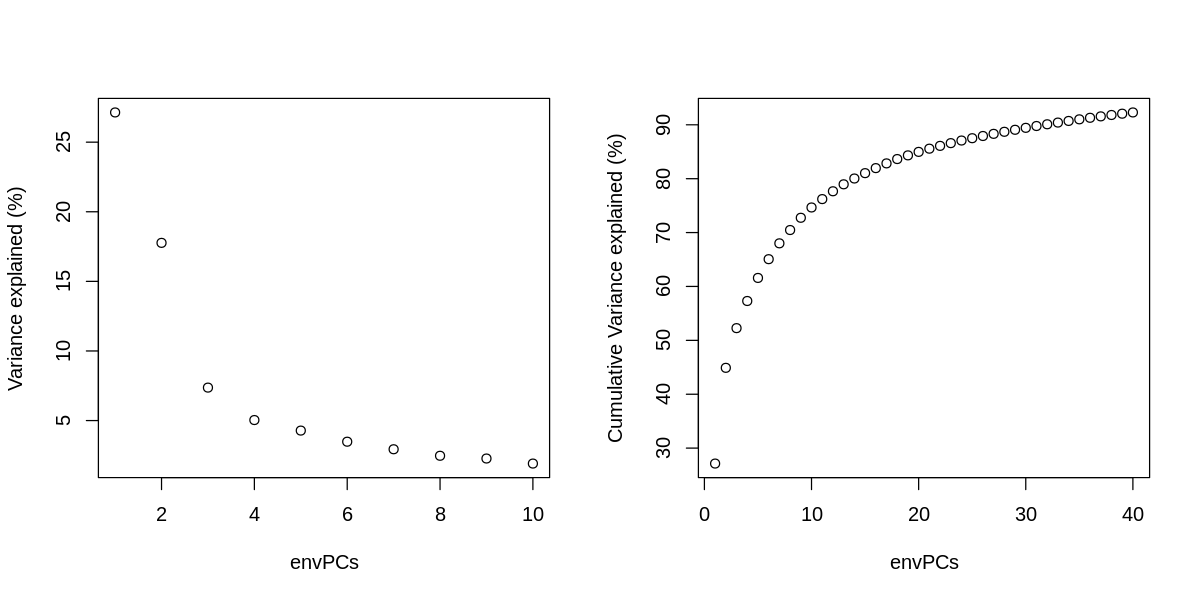

In [14]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow = c(1,2))
plot(ePCs$variance.explained.by.eigen[1:10,2],xlab = 'envPCs',ylab = 'Variance explained (%)')
plot(ePCs$variance.explained.by.eigen[,3],xlab = 'envPCs',ylab = 'Cumulative Variance explained (%)')

In [15]:
ePCs$variance.explained.by.eigen

eigenvalue explained_variance cumulative_explained_variance
envPC_1  76.5173566 27.1338144         27.13381                     
envPC_2  50.0971546 17.7649485         44.89876                     
envPC_3  20.7745231  7.3668522         52.26562                     
envPC_4  14.2035098  5.0367056         57.30232                     
envPC_5  12.0689615  4.2797736         61.58209                     
envPC_6   9.8175847  3.4814130         65.06351                     
envPC_7   8.2872822  2.9387526         68.00226                     
envPC_8   6.9663599  2.4703404         70.47260                     
envPC_9   6.4109554  2.2733884         72.74599                     
envPC_10  5.3898663  1.9113001         74.65729                     
envPC_11  4.3869797  1.5556666         76.21296                     
envPC_12  4.0938629  1.4517244         77.66468                     
envPC_13  3.6435948  1.2920549         78.95673                     
envPC_14  3.0360982  1.0766306         80.03337                     
envPC_15  2.8047780  0.9946021         81.02797                     
envPC_16  2.6326575  0.9335665         81.96153                     
envPC_17  2.4738892  0.8772657         82.83880                     
envPC_18  2.2715077  0.8054992         83.64430                     
envPC_19  1.9293507  0.6841669         84.32847                     
envPC_20  1.8270093  0.6478757         84.97634                     
envPC_21  1.6755776  0.5941764         85.57052                     
envPC_22  1.4671153  0.5202537         86.09077                     
envPC_23  1.4340406  0.5085250         86.59930                     
envPC_24  1.3637358  0.4835943         87.08289                     
envPC_25  1.2129059  0.4301085         87.51300                     
envPC_26  1.1557370  0.4098358         87.92283                     
envPC_27  1.1266773  0.3995310         88.32237                     
envPC_28  1.0749475  0.3811871         88.70355                     
envPC_29  1.0486967  0.3718783         89.07543                     
envPC_30  1.0200888  0.3617336         89.43716                     
envPC_31  0.9568967  0.3393251         89.77649                     
envPC_32  0.9037620  0.3204830         90.09697                     
envPC_33  0.8946855  0.3172644         90.41424                     
envPC_34  0.8538710  0.3027911         90.71703                     
envPC_35  0.8389569  0.2975024         91.01453                     
envPC_36  0.8076243  0.2863916         91.30092                     
envPC_37  0.7425686  0.2633222         91.56424                     
envPC_38  0.7267675  0.2577190         91.82196                     
envPC_39  0.6831200  0.2422411         92.06420                     
envPC_40  0.6469768  0.2294244         92.29363

In [16]:
commonID = intersect(spTre.rooted$tip.label,rownames(ePCs$environmental.features))
commonID = intersect(commonID,metadata$assemblyID)
eTraits_filtered = as.data.frame(ePCs$environmental.features[commonID,])
spTre.rooted.filtered = keep.tip(spTre.rooted,commonID)

In [17]:
dim(eTraits_filtered)

[1] 706 325

In [597]:
write.tree(spTre.rooted.filtered,"/workdir/sh2246/p_phyloGWAS/output/PoaceaeTree_angiosperm353_astral_filtered_withEnvData_20250416.nwk")

In [598]:
write.table(eTraits_filtered,"/workdir/sh2246/p_phyloGWAS/output/envData_706Poaceae_20250416.txt",
            quote = F, col.names = T, row.names = T,sep = "\t")

In [599]:
quantile(eTraits_filtered$envPC_1,seq(0,1,0.05))
table(eTraits_filtered$envPC_1<quantile(eTraits_filtered$envPC_1,0.3),metadata[commonID,]$subtribe)
table(eTraits_filtered$envPC_1>quantile(eTraits_filtered$envPC_1,0.7),metadata[commonID,]$subtribe)

0%         5%        10%        15%        20%        25%        30% 
-3.2921100 -1.7228425 -1.4270500 -1.1871625 -0.8873900 -0.6471750 -0.4387000 
       35%        40%        45%        50%        55%        60%        65% 
-0.2669900 -0.0917100  0.0491775  0.1430100  0.2702100  0.4070100  0.5153425 
       70%        75%        80%        85%        90%        95%       100% 
 0.7084100  0.8475925  0.9718600  1.0967475  1.2246400  1.3410725  2.0574400

       
        Alopecurinae Andropogoninae Anthephorinae Anthistiriinae Apludinae
  FALSE            0            132             2             59        19
  TRUE             2             17             0             20         3
       
        Arthraxoninae Arthrostylidiinae Arundinariinae Aveninae Bambusinae
  FALSE             5                 1              2        9          4
  TRUE              5                 0              8       15          0
       
        Boivinellinae Brachypodiinae Brominae Cenchrinae Chionachninae
  FALSE             6              0        0          2             2
  TRUE              2              7        2         10             0
       
        Chrysopogoninae Coleanthinae Dactylidinae Dichantheliinae Eleusininae
  FALSE              15            0            0               0          12
  TRUE                1            1            2               1           0
       
        Eragrostidinae Germainiinae Guaduinae Hordeinae Hsuehoc

       
        Alopecurinae Andropogoninae Anthephorinae Anthistiriinae Apludinae
  FALSE            2             89             0             60        17
  TRUE             0             60             2             19         5
       
        Arthraxoninae Arthrostylidiinae Arundinariinae Aveninae Bambusinae
  FALSE             9                 0             10       24          4
  TRUE              1                 1              0        0          0
       
        Boivinellinae Brachypodiinae Brominae Cenchrinae Chionachninae
  FALSE             6              7        2         12             2
  TRUE              2              0        0          0             0
       
        Chrysopogoninae Coleanthinae Dactylidinae Dichantheliinae Eleusininae
  FALSE               8            1            2               1          11
  TRUE                8            0            0               0           1
       
        Eragrostidinae Germainiinae Guaduinae Hordeinae Hsuehoc

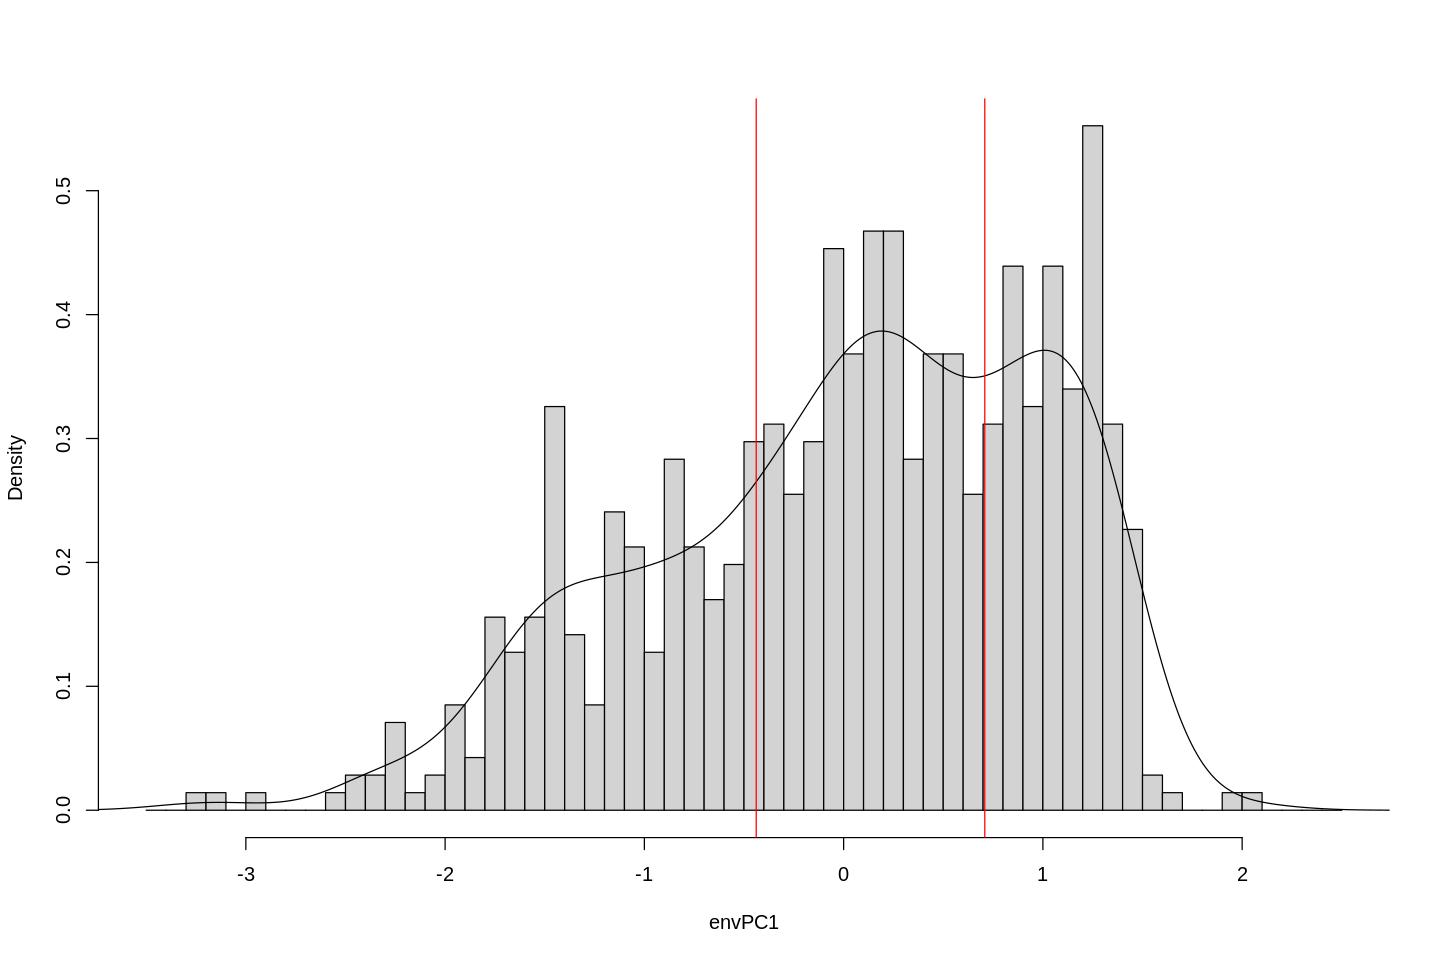

In [192]:
hist(eTraits_filtered$envPC_1,breaks = seq(-3.5,2.5,0.1),freq = F,main = "",xlab = "envPC1")
points(density(eTraits_filtered$envPC_1),type = "l")
abline(v = quantile(eTraits_filtered$envPC_1,c(0.3,0.7)),col = "red")

In [ ]:
plot(eTraits_filtered$envPC_1,eTraits_filtered$n00_quan50)
abline(v = quantile(eTraits_filtered$envPC_1,0.3))

plot(eTraits_filtered$envPC_1,eTraits_filtered$bio05_Max_Temperature_Warmest_Month_quan50)
abline(v = quantile(eTraits_filtered$envPC_1,0.7))

In [177]:
envPC1_coldTolSp = rownames(eTraits_filtered)[eTraits_filtered$envPC_1<quantile(eTraits_filtered$envPC_1,0.3)]
envPC1_warmTolSp = rownames(eTraits_filtered)[eTraits_filtered$envPC_1>quantile(eTraits_filtered$envPC_1,0.7)]

In [195]:
write.table(envPC1_coldTolSp,"/workdir/sh2246/p_phyloGWAS/output/coldAdaptedAssemblies.txt",quote = F,sep = "\t",row.names = F,col.names = F)
write.table(envPC1_warmTolSp,"/workdir/sh2246/p_phyloGWAS/output/warmAdaptedAssemblies.txt",quote = F,sep = "\t",row.names = F,col.names = F)

In [198]:
metadata["AN22TNTL128",]

assemblyID  tracker_sample_name latest_name          
AN22TNTL128 AN22TNTL128 AN22TNTL128         Dichanthium caricosum
            CorrectEcotype                             lifeHistory technology
AN22TNTL128 P Peterson, RJ Soreng, K Romaschenko 23816 perennial   Illumina  
            source complete duplicated fraged ⋯ clade  subfamily  
AN22TNTL128 PanAnd 1742     2811       1038   ⋯ PACMAD Panicoideae
            tribe         subtribe       wrongSample lowTABASCO CHList
AN22TNTL128 Andropogoneae Anthistiriinae TRUE        TRUE       TRUE  
            QCshortread dupSample spTaxa                           
AN22TNTL128 TRUE        TRUE      AN22TNTL128:Dichanthium caricosum

# loading analysis

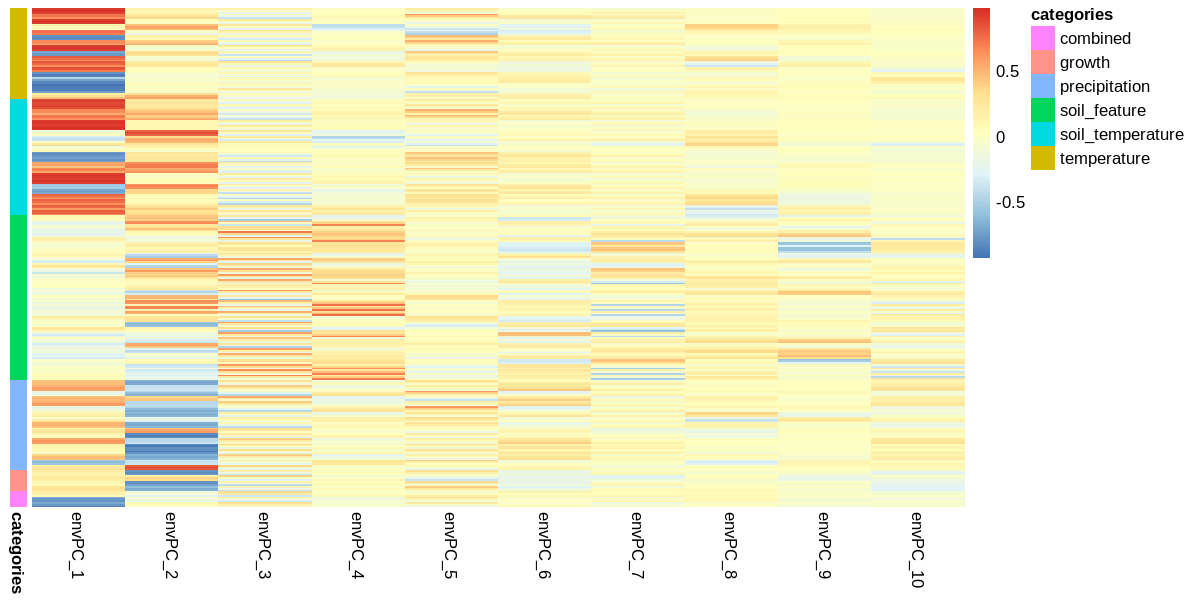

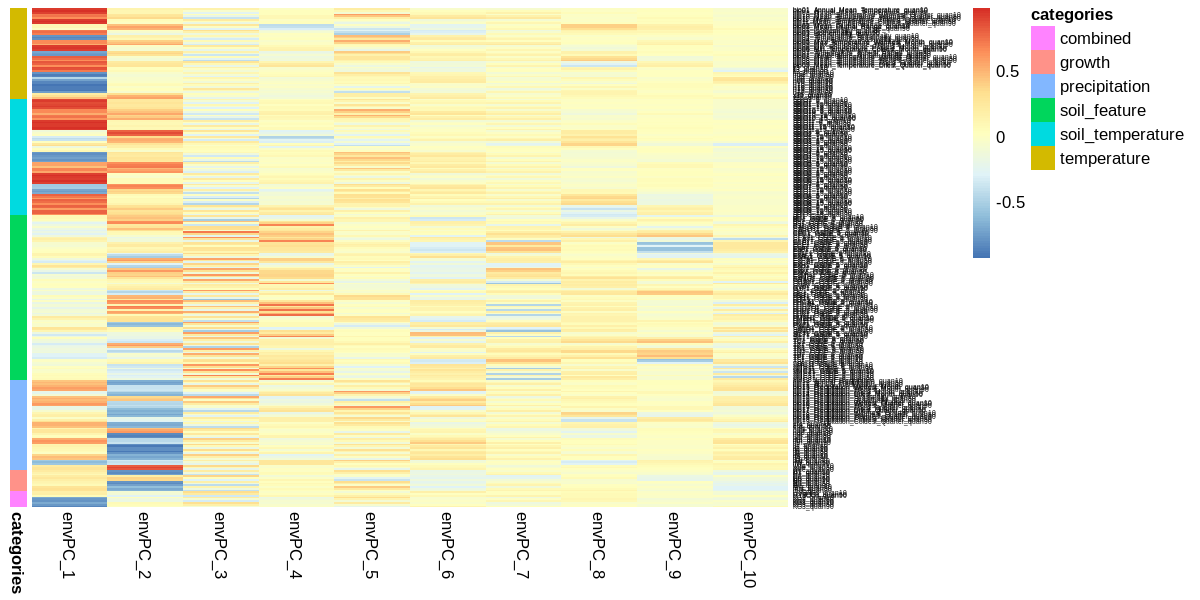

In [12]:
env_metadata = read.table("/workdir/sh2246/p_phyloGWAS/data/env_metadata.txt",sep ="\t",header = T)
ePC_loading_labels = data.frame(categories = rep(env_metadata[,3],each = 3))
rownames(ePC_loading_labels) = paste(rep(env_metadata[,1],each = 3),c("quan10","quan50","quan90"),sep = "_")
envp = pheatmap(na.omit(ePCs$variable.correlation[order(ePC_loading_labels$categories,decreasing = T),1:10]),cluster_rows = F,cluster_cols = F,show_rownames = F,annotation_row = ePC_loading_labels)

# png("/workdir/sh2246/p_phyloGWAS/output/envPC_loading.png",width = 16,height = 16, units = "cm",res = 600,pointsize = 8)
# envp
# dev.off()

envp2 = pheatmap(na.omit(ePCs$variable.correlation[order(ePC_loading_labels$categories,decreasing = T),1:10]),cluster_rows = F,cluster_cols = F,show_rownames = T,annotation_row = ePC_loading_labels,fontsize_row = 4)
# png("/workdir/sh2246/p_phyloGWAS/output/envPC_loading_withName.png",width = 20,height = 30, units = "cm",res = 600,pointsize = 8)
# envp2
# dev.off()

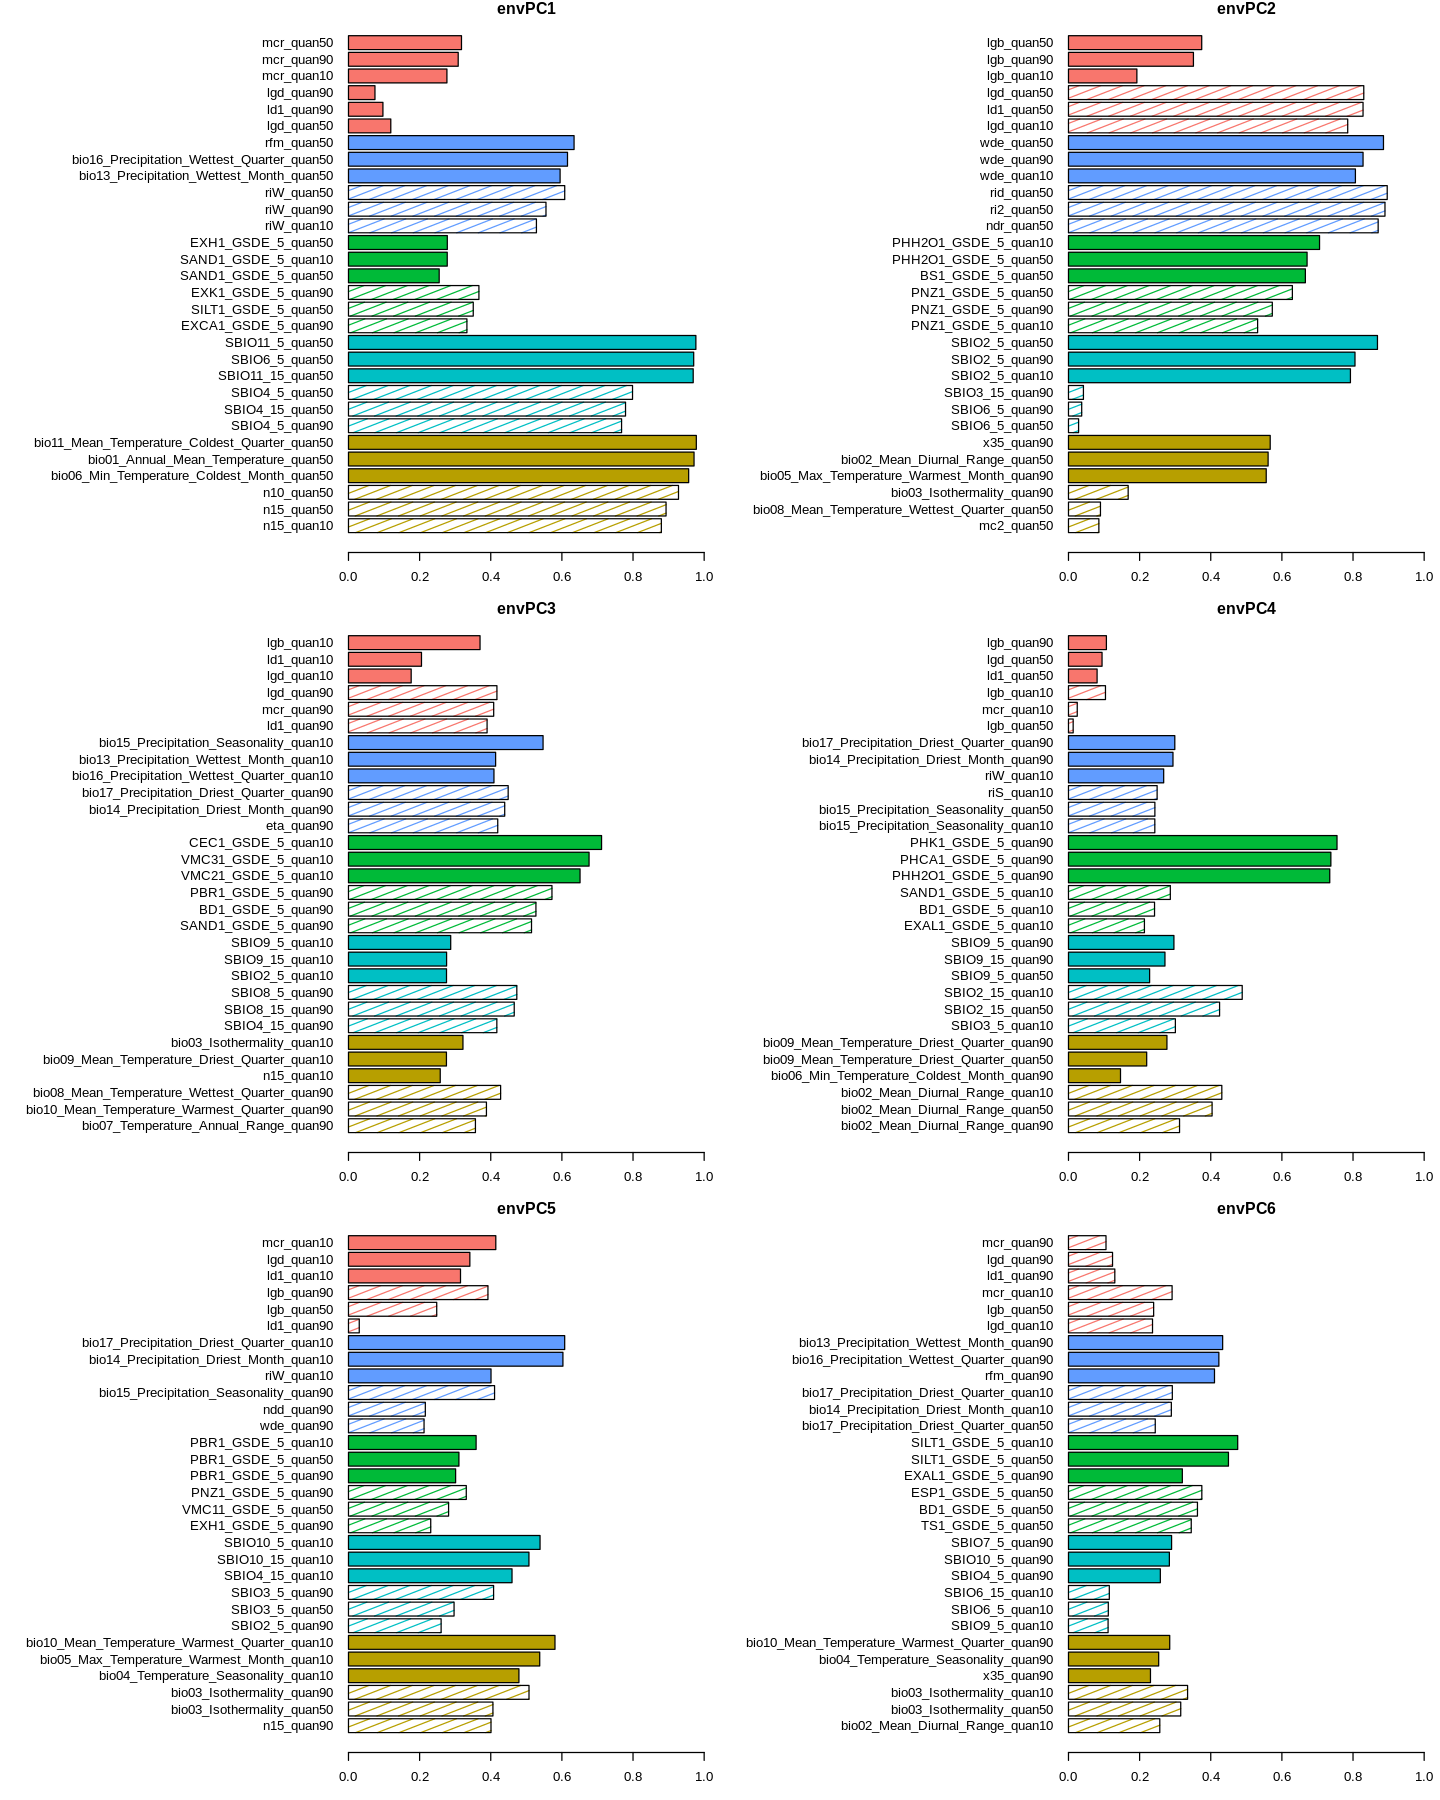

In [347]:
options(repr.plot.width=12, repr.plot.height=15)
par(mar = c(3,22,1,1),mfrow = c(3,2))
for (i in 1:6){
    tmp = ePCs$variable.correlation[,i]
    names(tmp) = rownames(ePCs$variable.correlation)
    idx = tapply(tmp,ePC_loading_labels$categories,function(x) c(sort(x,decreasing = T)[1:3],sort(x,decreasing = F)[1:3]))[-1]
    names(idx) = NULL
    idx = unlist(idx)             
    barplot(rev(abs(idx)),main = paste0("envPC",i),horiz = T,las =1,xlim = c(0,1),
            col = rep(scales::hue_pal()(6)[c(2,4,3,5,1)],each = 6),
            density = ifelse(rev(idx)>0,NA,50),names.arg = rev(names(idx)))
}


In [22]:
head(envTrait_range_merged$KG3)

[1]  7 15  7  7  7  7

In [22]:
KG3_class = tapply(envTrait_range_merged$KG3,envTrait_range_merged$assemblyID,function(x) as.numeric(names(table(x))[which.max(table(x))]))

In [23]:
KG3_class = KG3_class[commonID]

In [24]:
# KG3_class = as.data.frame(ePCs$environmental.features)$KG3_quan50

In [25]:
KG3_class[!KG3_class%in%seq(1,31,1)] = NA

In [26]:
KG3_name = c("Af","Am","As","Aw",
             "BWh","BWk","BSh","BSk",
             "Cfa","Cfb","Cfc","Cwa","Cwb","Cwc","Csa","Csb","Csc",
             "Dfa","Dfb","Dfc","Dfd","Dsa","Dsb","Dsc","Dsd","Dwa","Dwb","Dwc","Dwd",
             "ET","EF")

In [27]:
KG3Col = c(
  "Af" = "#006400", "Am" = "#228B22", "As" = "#FF4500", "Aw" = "#FF8C00",
  "BWh" = "#FFD700", "BWk" = "#DAA520", "BSh" = "#CD853F", "BSk" = "#8B4513",
  "Cfa" = "#32CD32", "Cfb" = "#3CB371", "Cfc" = "#2E8B57", "Cwa" = "#ADFF2F",
  "Cwb" = "#9ACD32", "Cwc" = "#20B2AA", "Csa" = "#00FF7F", "Csb" = "#66CDAA",
  "Csc" = "#008080", "Dfa" = "#4682B4", "Dfb" = "#4169E1", "Dfc" = "#1E90FF",
  "Dfd" = "#00008B", "Dsa" = "#5F9EA0", "Dsb" = "#4682B4", "Dsc" = "#4169E1",
  "Dsd" = "#27408B", "Dwa" = "#708090", "Dwb" = "#4682B4", "Dwc" = "#1E90FF",
  "Dwd" = "#191970", "ET" = "#87CEEB", "EF" = "#ADD8E6"
)

In [28]:
KGpd = data.frame(envPC = c(ePCs$synthetic.environmental.traits[commonID,1],ePCs$synthetic.environmental.traits[commonID,2]),
                  group = rep(c('envPC1','envPC2'),each = nrow(ePCs$synthetic.environmental.traits[commonID,])),
                  KG3Class = rep(KG3_class,2),KG3Name = rep(KG3_name[KG3_class],2))
KGpd = na.omit(KGpd)

In [29]:
sort(unique(KGpd$KG3Name))

[1] "Af"  "Am"  "As"  "Aw"  "BSh" "BSk" "BWh" "BWk" "Cfa" "Cfb" "Csa" "Csb"
[13] "Cwa" "Cwb" "Dfb" "Dwa" "Dwc"

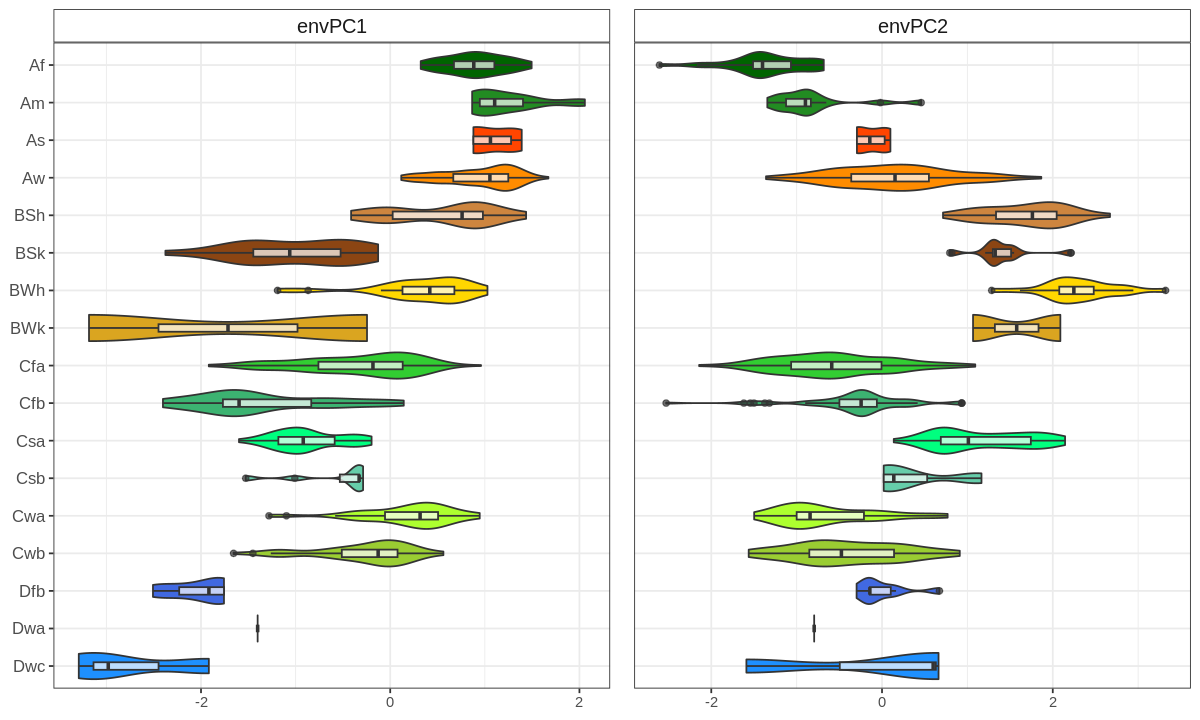

In [40]:
options(repr.plot.width=10, repr.plot.height=6)
p = ggplot(KGpd, aes(x = envPC, y = factor(KG3Name,levels = rev(sort(unique(KG3Name)))),
                     fill = factor(KG3Name,levels = rev(sort(unique(KG3Name)))))) +
    geom_violin(scale = "width", width = .7,orientation = "y") +
    scale_fill_manual(values = KG3Col) +
    geom_boxplot(width = 0.2, fill = "white", alpha = 0.7) +
    facet_wrap(~group,scales = 'free_x') + 
    theme_bw()+
    theme(legend.position = "none",
          axis.title.y = element_blank(),axis.text.y = element_text(size = 10),
          axis.title.x = element_blank(), #axis.text.x = element_blank(),
          strip.placement = "outside",  # Move the strip labels outside the plot
          strip.text.x = element_text(angle = 0,size = 12),  # Rotate text to be horizontal
          panel.spacing = unit(1, "lines"),strip.background = element_rect(fill="NA"))
p

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


pdf 
  2

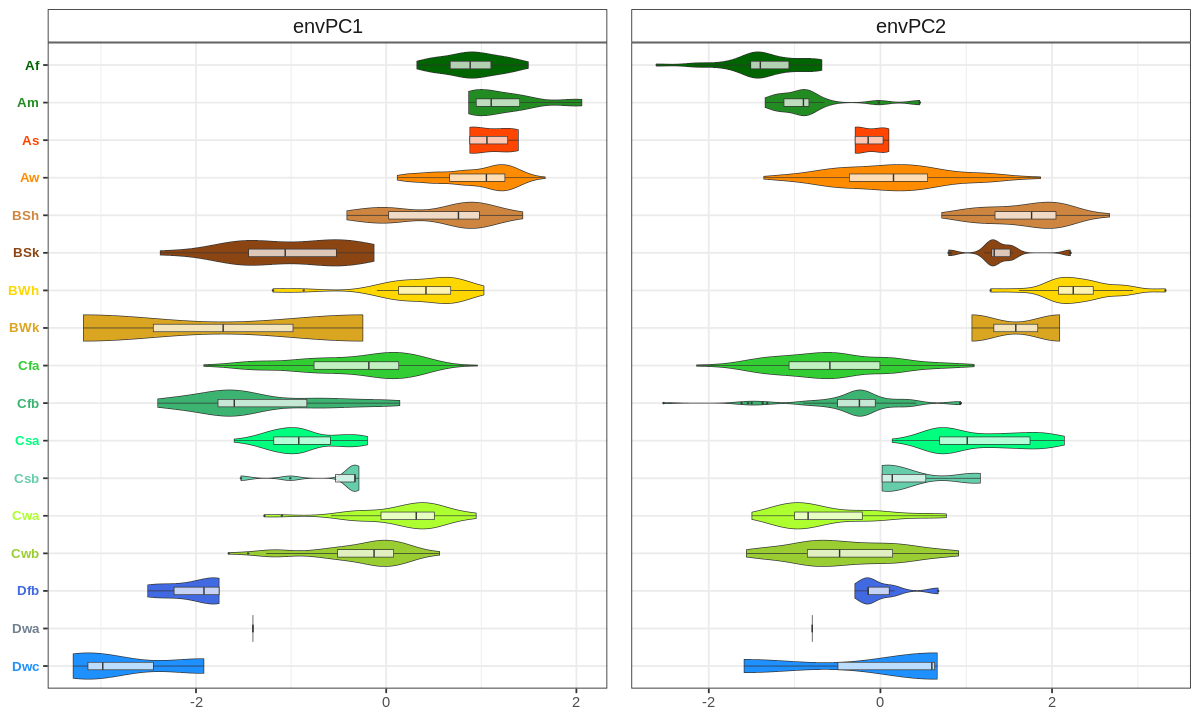

In [43]:
p = ggplot(KGpd, aes(x = envPC, y = factor(KG3Name,levels = rev(sort(unique(KG3Name)))),fill = factor(KG3Name,levels = rev(sort(unique(KG3Name)))))) +
    geom_violin(scale = "width", width = .7,orientation = "y",size = 0.2) +
    scale_fill_manual(values = KG3Col) +
    geom_boxplot(width = 0.2, fill = "white", alpha = 0.7,outlier.size = 0.1,size = 0.2) +
    facet_wrap(~group,scales = 'free_x') + 
    theme_bw()+
    theme(legend.position = "none",
          plot.background = element_rect(fill = "transparent", colour = NA),
          panel.background = element_rect(fill = "transparent", colour = NA),
          axis.title.y = element_blank(),axis.text.y = element_text(face = 'bold',size =8,colour = KG3Col[rev(sort(unique(KGpd$KG3Name)))]),
          axis.title.x = element_blank(), #axis.text.x = element_blank(),
          strip.placement = "outside",  # Move the strip labels outside the plot
          strip.text.x = element_text(angle = 0,size = 12),  # Rotate text to be horizontal
          panel.spacing = unit(1, "lines"),strip.background = element_rect(fill="transparent"))
p
png("/workdir/sh2246/p_phyloGWAS/output/figure/Fig1b.png",width = 8.7*.6,height = 8.7, units = "cm",res = 900,pointsize = 8,bg = "transparent")
p
dev.off()

# tree overlaying

In [30]:
tribeLab = metadata[commonID,]$tribe
names(tribeLab) = commonID

In [31]:
tmpTrait = ePCs$synthetic.environmental.traits[commonID,1]
tmpTrait2 = ePCs$synthetic.environmental.traits[commonID,2]
names(tmpTrait)=commonID
names(tmpTrait2)=commonID

tmpTrait3 = KG3_class[commonID]
tmpTrait3 = KG3_name[tmpTrait3]
names(tmpTrait3)=commonID
# fit <- phytools::fastAnc(spTre.rooted.filtered,tmpTrait , vars=TRUE, CI=TRUE)
# td <- data.frame(node = nodeid(spTre.rooted.filtered, commonID),
#                envPC1 = tmpTrait)
# nd <- data.frame(node = names(fit$ace), envPC1 = fit$ace)
# d <- rbind(td, nd)
# d$node <- as.numeric(d$node)
# plotTree <- full_join(spTre.rooted.filtered, d, by = 'node')

# fit2 <- phytools::fastAnc(spTre.rooted.filtered,tmpTrait2 , vars=TRUE, CI=TRUE)
# td2 <- data.frame(node = nodeid(spTre.rooted.filtered, commonID),
#                envPC2 = tmpTrait2)
# nd2 <- data.frame(node = names(fit2$ace), envPC2 = fit2$ace)
# d2 <- rbind(td2, nd2)
# d2$node <- as.numeric(d2$node)
# plotTree2 <- full_join(spTre.rooted.filtered, d2, by = 'node')

In [140]:
highlightNode = c()
for( i in c("Andropogoneae","Cynodonteae","Oryzeae","Paniceae","Poeae","Triticeae")){
    highlightNode = c(highlightNode,getMRCA(spTre.rooted.filtered,metadata[commonID,][tribeLab==i,1]))
}


highlightNodeDat= data.frame(node = highlightNode,
                             Tribe = c("Andropogoneae","Cynodonteae","Oryzeae","Paniceae","Poeae","Triticeae"))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale

pdf 
  2

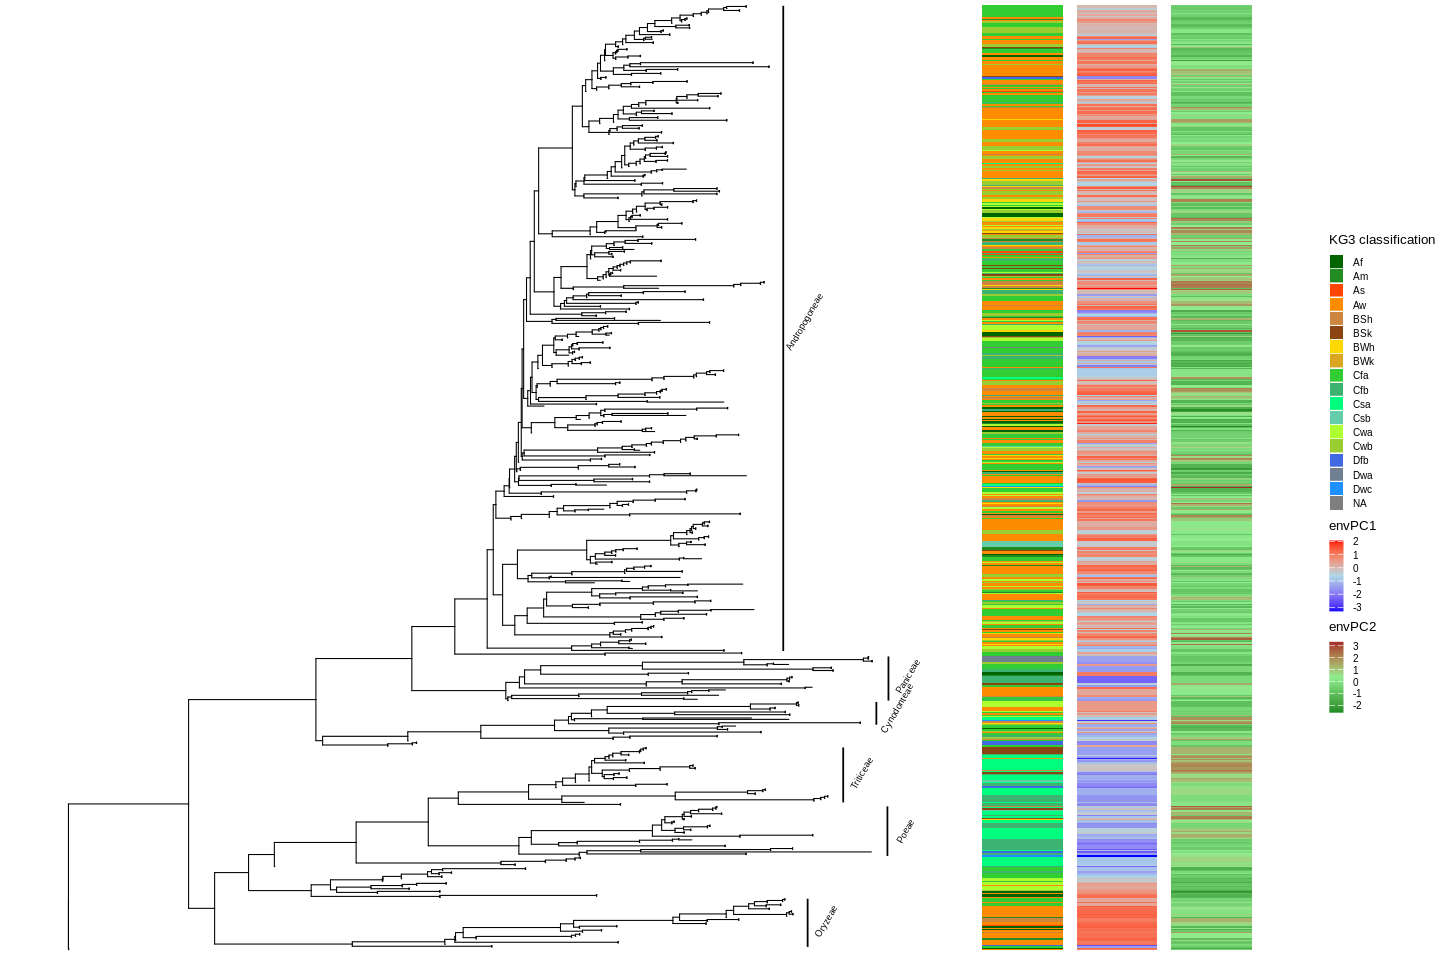

In [142]:
p <- ggtree(spTre.rooted.filtered,layout = "rectangular", ladderize = T,size = .3)
p <- p + geom_cladelab(node=highlightNodeDat$node, align=F,angle = 60,fontsize = 2,offset = 0,hjust = 0.3,vjust =2,
                       label=c("Andropogoneae","Cynodonteae","Oryzeae","Paniceae","Poeae","Triticeae"))
p1 <- p+ new_scale_fill()
p1 <- gheatmap(p1, as.data.frame(tmpTrait3) , offset=1.7, width=0.1,colnames = F,color = NA) +
    scale_x_ggtree() + 
    scale_y_continuous(expand=c(0, 0.3))+
    scale_fill_manual(values = KG3Col,name = "KG3 classification")
p1 <- p1+ new_scale_fill()
p1 <- gheatmap(p1, as.data.frame(tmpTrait) , offset=4.0, width=0.1,colnames = F,color = NA) +
    scale_x_ggtree() + 
    scale_y_continuous(expand=c(0, 0.3))+
    scale_fill_gradientn(colours = c('blue',"lightblue",'red'),name = "envPC1")
p2 <- p1+ new_scale_fill()
p2 <- gheatmap(p2, as.data.frame(tmpTrait2) , offset=6.3, width=0.1,colnames = F,color = NA) +
    scale_y_continuous(expand=c(0, 0.3))+
    scale_fill_gradientn(colours = c('forestgreen',"lightgreen",'brown'),name = "envPC2")+
    theme(axis.text=element_text(size=5),legend.position = "right",legend.key.width = unit(3,units = "mm"),
          legend.key.height = unit(3,units = "mm"),
          legend.margin = margin(t = -2,r =0,b = 0,l =0, unit='mm'),
          plot.margin = margin(t= 1, r= 1,b = 1,l = 1, unit='mm'),
          legend.title = element_text(size = 8),legend.text = element_text(size = 6))
p2
png("/workdir/sh2246/p_phyloGWAS/output/figure/Fig1a.png",width = 8.7*1.5,height = 17.4,units = "cm",
    pointsize = 6,res = 600)
p2
dev.off()


In [143]:
envpd = data.frame(envPC = c(tmpTrait,tmpTrait2),taxagroup = rep(metadata[commonID,]$subtribe,2),
                   group = rep(c('envPC1','envPC2'),each = length(commonID)))
envpd_subset = envpd[envpd$taxagroup%in%names(which(table(envpd$taxagroup)>20)),]

In [144]:
envpd_subset$taxagroup = factor(envpd_subset$taxagroup,
                                levels = c('Andropogoninae','Anthistiriinae',
                                           'Saccharinae','Sorghinae','Apludinae','Ischaeminae',
                                           'Ratzeburgiinae','Chrysopogoninae',
                                           'Rhytachninae','Rottboelliinae','Tripsacinae',
                                           'Arthraxoninae','Cenchrinae','Eleusininae',
                                           'Triticinae','Hordeinae','Aveninae','Oryzinae'))

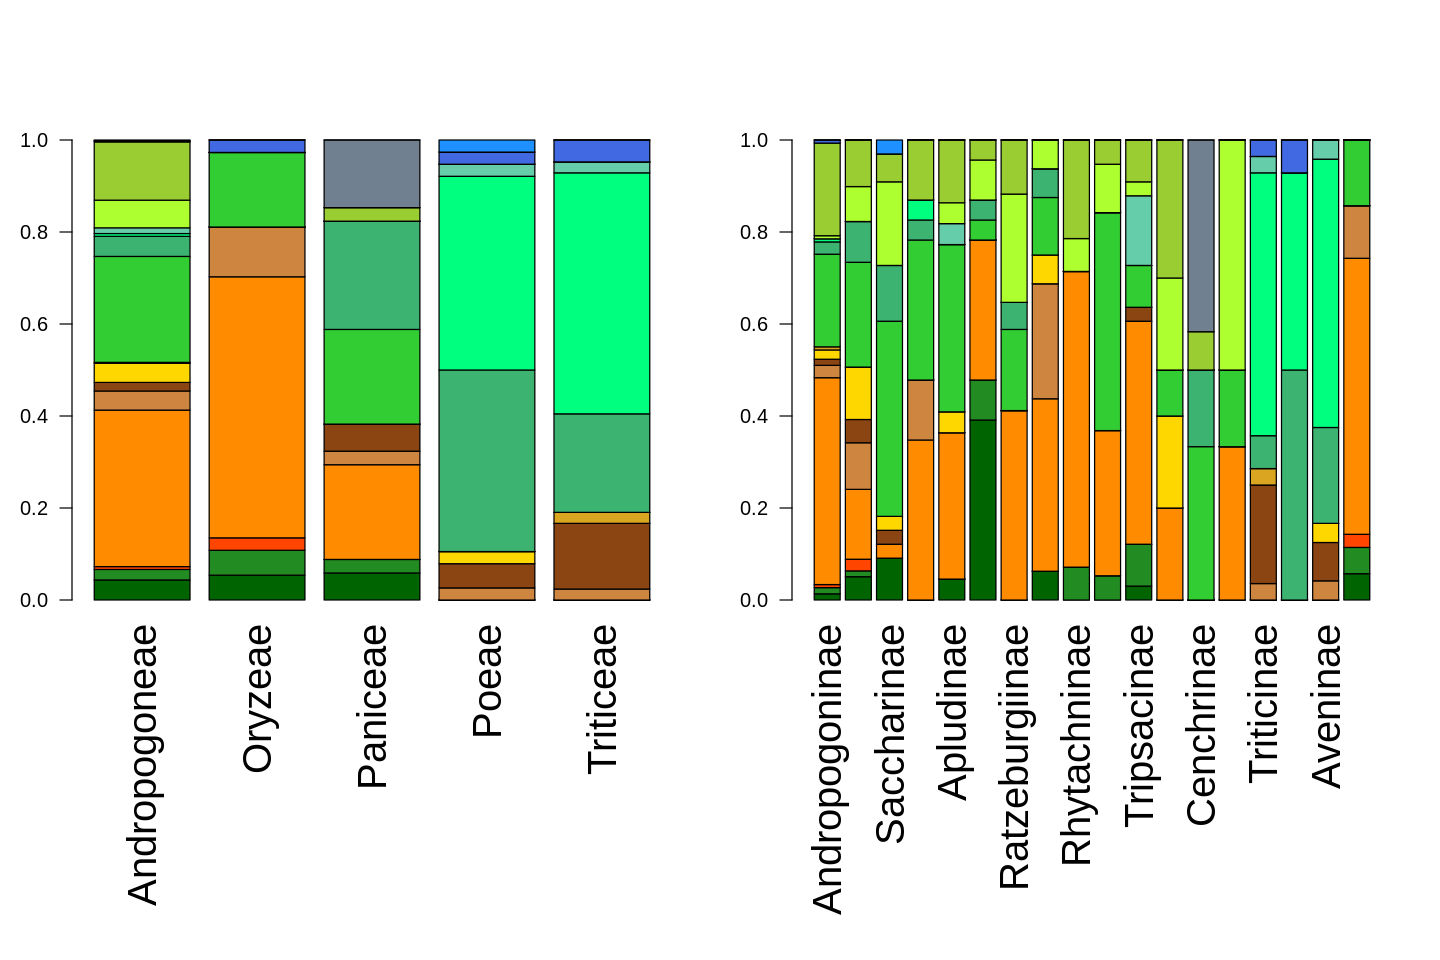

In [145]:
options(repr.plot.width=12, repr.plot.height=8)
par(mar=c(15,3,2,2),mfrow = c(1,2),las =2)
KG3Count = t(table(tmpTrait3,tribeLab))
KG3Freq = KG3Count/rowSums(KG3Count)
bp = barplot(t(KG3Freq[rowSums(KG3Count)>=30,]),col = KG3Col[colnames(KG3Freq[rowSums(KG3Count)>=30,])],ylim = c(0,1.2),
             cex.names = 2,cex.axis =1.5,args.legend = list(x= "top",bty= 'n',horiz =T,cex = 1.5),yaxt = 'n',las = 2)
axis(2,seq(0,1,0.2))

KG3Count = t(table(tmpTrait3,metadata[commonID,]$subtribe))
KG3Freq = KG3Count/rowSums(KG3Count)
bp = barplot(t(KG3Freq[levels(envpd_subset$taxagroup),]),col = KG3Col[colnames(KG3Freq)],ylim = c(0,1.2),
             cex.names = 2,cex.axis =1.5,args.legend = list(x= "top",bty= 'n',horiz =T,cex = 1.5),yaxt = 'n',las = 2)
axis(2,seq(0,1,0.2))


In [148]:
# options(repr.plot.width=8, repr.plot.height=8)
png("/workdir/sh2246/p_phyloGWAS/output/figure/Fig1c.png",width = 8.7*.75,height = 8.7,units = "cm",pointsize = 8,res = 900)
par(mar=c(3,6,2,2),las =2)
barplot(t(KG3Freq[rev(levels(envpd_subset$taxagroup)),]),col = KG3Col[colnames(KG3Freq)],horiz = T,
        cex.names = .75,cex.axis =.75,args.legend = list(x= "top",bty= 'n',horiz =T,cex = 1.5),las = 1)
# axis(2,seq(0,1,0.2),cex.axis = 1)
dev.off()

pdf 
  2

Warning message:
“The `switch` argument of `facet_wrap()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `strip.position` argument instead.”


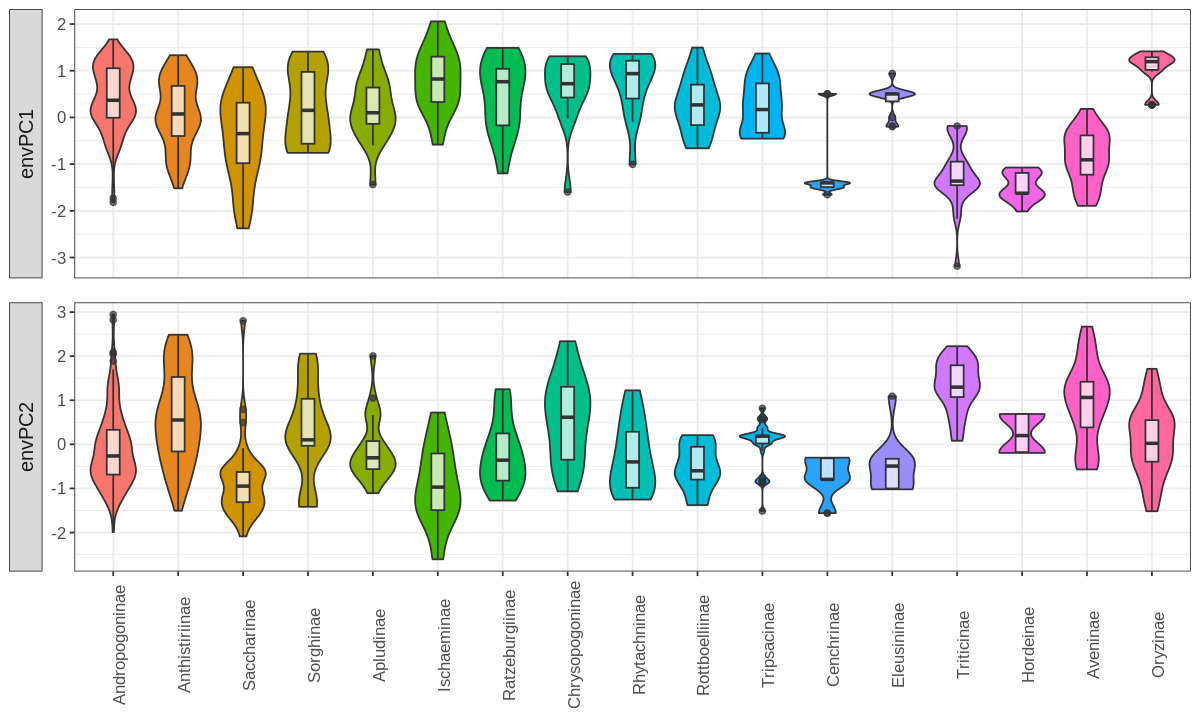

In [78]:
options(repr.plot.width=10, repr.plot.height=6)
p = ggplot(envpd_subset, aes(x = taxagroup, y = envPC,fill = taxagroup)) +
    geom_violin(scale = "width", width = .7) +
    geom_boxplot(width = 0.2, fill = "white", alpha = 0.7) +
    facet_wrap(~group,nrow = 2,switch = 'y',scales = 'free_y') + 
    theme_bw()+
    theme(legend.position = "none",
          axis.title.y = element_blank(),axis.text.y = element_text(size = 10),
          axis.text.x = element_text(angle = 90, size = 10),axis.title.x = element_blank(),
          strip.placement = "outside",  # Move the strip labels outside the plot
          strip.text.y = element_text(angle = 0,size = 12),  # Rotate text to be horizontal
          panel.spacing = unit(1, "lines"))
p

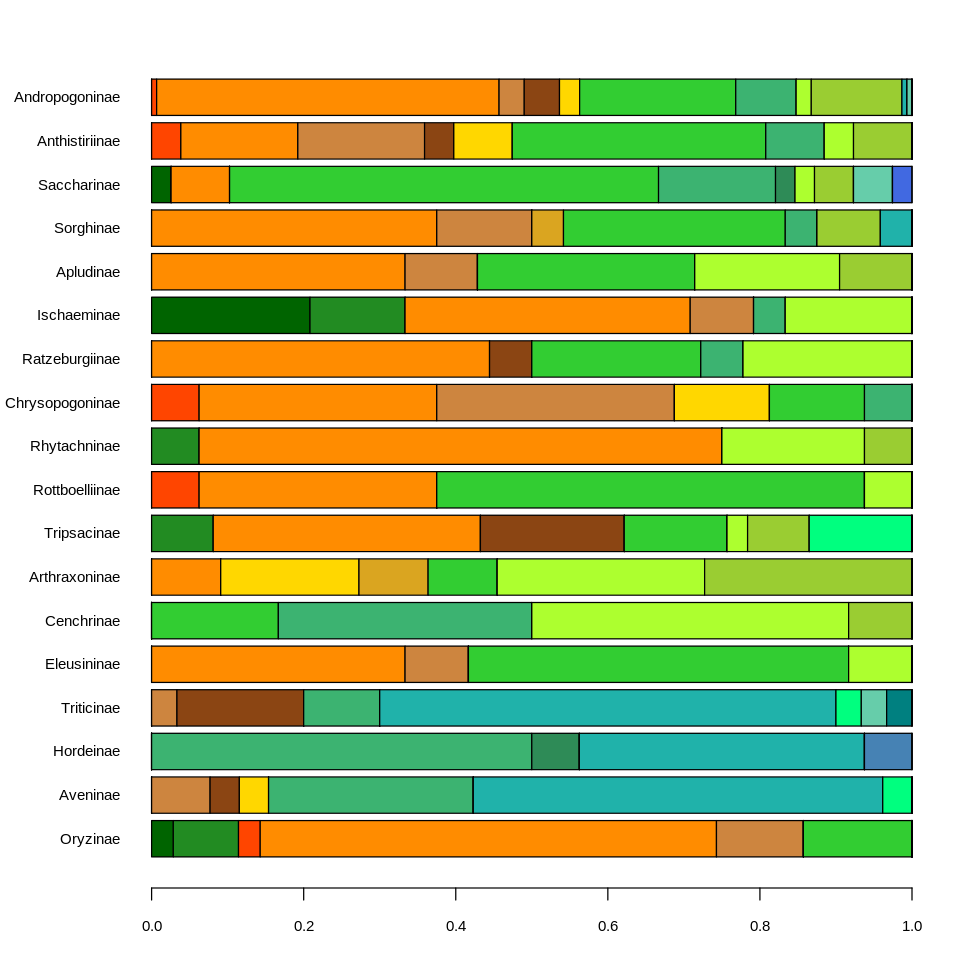

In [252]:
options(repr.plot.width=8, repr.plot.height=8)
par(mar=c(3,6,2,2),las =2)
barplot(t(KG3Freq[rev(levels(envpd_subset$taxagroup)),]),col = KG3Col[colnames(KG3Freq)],horiz = T,
        cex.names = .75,cex.axis =.75,args.legend = list(x= "top",bty= 'n',horiz =T,cex = 1.5),las = 1)


In [254]:
subtribeTopology = '(((((((((Andropogoninae,Anthistiriinae),((Saccharinae,Sorghinae),Apludinae)),Ischaeminae),Ratzeburgiinae),Chrysopogoninae),(((Rhytachninae,Rottboelliinae),Tripsacinae))),Arthraxoninae),(Cenchrinae,Eleusininae)),(((Triticinae,Hordeinae),Aveninae),Oryzinae));'

In [255]:
png("/workdir/sh2246/p_phyloGWAS/output/figure/Fig1c_tree.png",width = 8.7*.25,height = 8.7,units = "cm",pointsize = 8,res = 900)
ggtree(read.tree(text = subtribeTopology),ladderize = F)+
    scale_y_reverse()
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


pdf 
  2

# life history paper Figures

In [32]:
tempTrop = ifelse(tmpTrait3%in%c("Af","Am","Aw","As","BWh","BSh"),"tropical","temperate")
names(tempTrop) = names(tmpTrait3)

In [40]:
write.table(data.frame(assemblyID = names(tmpTrait3),KG3 = tmpTrait3,temp.trop = tempTrop),
            "/workdir/sh2246/p_phyloGWAS/output/assemblyClimateZone.txt",quote = F,col.names =T, row.names = F,sep="\t")

In [615]:
lifeHistoryNumeric = as.numeric(metadata[commonID,]$lifeHistory=="annual")

In [774]:
which(tapply(metadata$lifeHistory,metadata$latest_name,function(x) length(table(x,useNA = "ifany"))>1))

Schizachyrium brevifolium 
                      454

In [616]:
lifeHistoryID = commonID[!is.na(lifeHistoryNumeric)]

In [617]:
names(lifeHistoryNumeric) = commonID

In [618]:
# fit <- phytools::fastAnc(keep.tip(spTre.rooted.filtered,lifeHistoryID),na.omit(lifeHistoryNumeric),
#                          vars=TRUE, CI=TRUE,)
# td <- data.frame(node = nodeid(keep.tip(spTre.rooted.filtered,lifeHistoryID), lifeHistoryID),
#                life_history = na.omit(lifeHistoryNumeric))
# nd <- data.frame(node = names(fit$ace), life_history = fit$ace)
# d <- rbind(td, nd)
# d$node <- as.numeric(d$node)
# plotTree <- full_join(keep.tip(spTre.rooted.filtered,lifeHistoryID), d, by = 'node')

In [688]:
# Subset tree to include only species with trait data
rooted_tree <- root(spTre.rooted.filtered, outgroup = "ASM1935983v1", resolve.root = TRUE)
# rooted_tree$edge.length[rooted_tree$edge.length==0.01] = 0.1 
# Step 2: Make the tree fully dichotomous (resolve polytomies randomly)
dichotomous_tree <- multi2di(rooted_tree)

# Step 3: Subset to match trait data
tree.sub <- keep.tip(dichotomous_tree, names(na.omit(lifeHistoryNumeric)))
# Extract trait data and ensure it's in the right order
trait <- na.omit(lifeHistoryNumeric)
trait <- trait[tree.sub$tip.label]  # match the order of the tips

# Use ace() for discrete traits (method = "ML")
fit <- ace(trait, tree.sub, type = "discrete",model = "ARD")

# Create data frame for tips
td <- data.frame(node = 1:Ntip(tree.sub),
                 life_history = trait)

# Create data frame for internal nodes
nd <- data.frame(node = (Ntip(tree.sub) + 1):(Ntip(tree.sub) + Nnode(tree.sub)),
                 life_history = fit$lik.anc[,2])

# Combine tip and node data
d <- rbind(td, nd)
d$node <- as.numeric(d$node)
plotTree <- full_join(tree.sub, d, by = 'node')

In [689]:
highlightNode2 = c()
for( i in c("Andropogoneae","Cynodonteae","Oryzeae","Paniceae","Poeae","Triticeae")){
    highlightNode2 = c(highlightNode2,getMRCA(tree.sub,metadata[lifeHistoryID,][tribeLab[lifeHistoryID]==i,1]))
}


highlightNodeDat2= data.frame(node = highlightNode2,
                             Tribe = c("Andropogoneae","Cynodonteae","Oryzeae","Paniceae","Poeae","Triticeae"))

In [690]:
edgeState = apply(plotTree@phylo$edge,c(1,2),function(x) d[d$node==x,2])

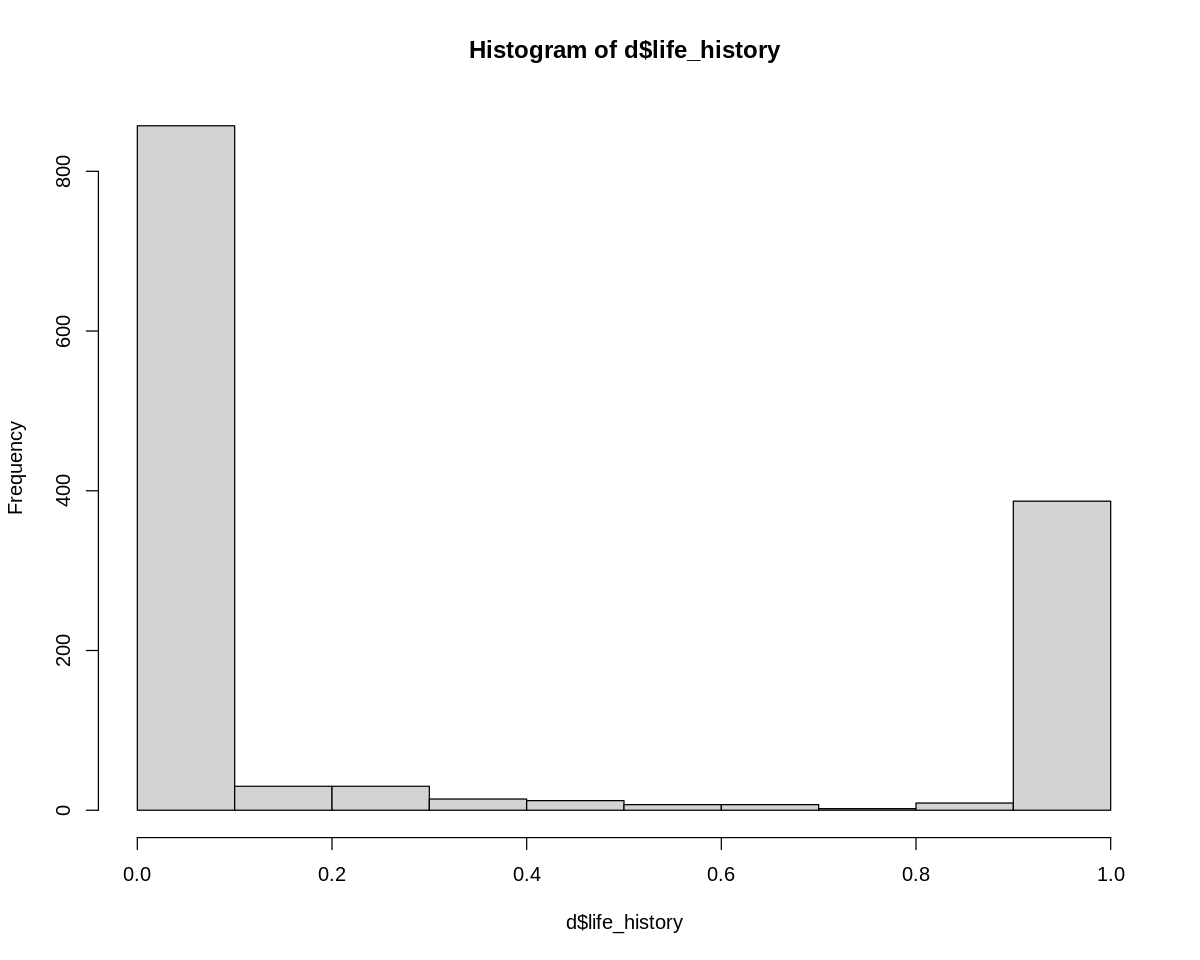

In [693]:
options(repr.plot.width=10, repr.plot.height=8)
hist(d$life_history)

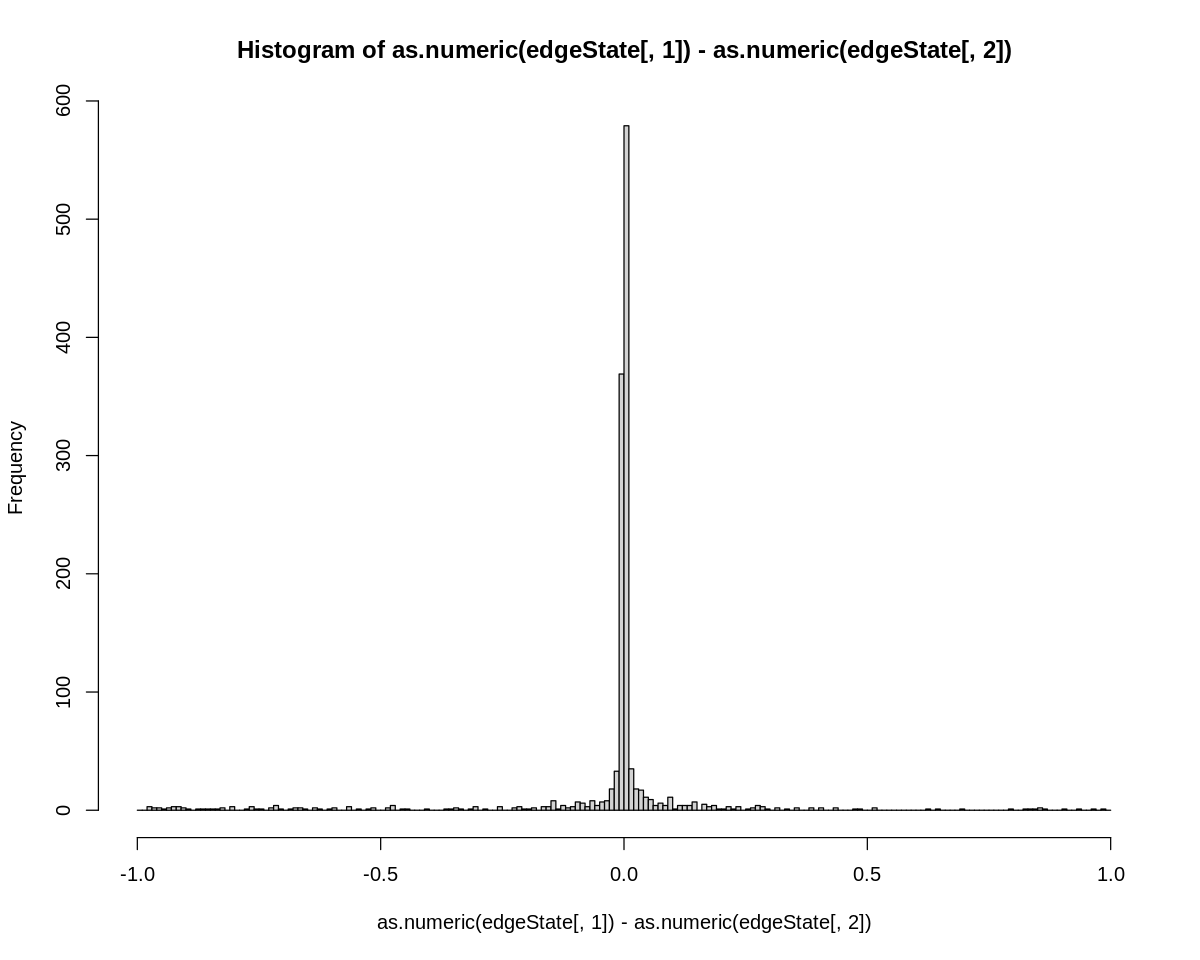

In [694]:
options(repr.plot.width=10, repr.plot.height=8)
hist(as.numeric(edgeState[,1])-as.numeric(edgeState[,2]),breaks = seq(-1,1,0.01))

In [775]:
A2P = as.numeric(edgeState[,1])>0.85&as.numeric(edgeState[,2])<0.15
P2A = as.numeric(edgeState[,1])<0.15&as.numeric(edgeState[,2])>0.85
A2P_soft = as.numeric(edgeState[,1])>0.5&as.numeric(edgeState[,2])<0.5
P2A_soft = as.numeric(edgeState[,1])<0.5&as.numeric(edgeState[,2])>0.5
sum(A2P)
sum(P2A)
sum(A2P_soft)
sum(P2A_soft)

[1] 10

[1] 31

[1] 19

[1] 69

In [625]:
rhizomeDat = data.table::fread("/workdir/sh2246/p_phyloGWAS/data/grassBase_cleaned_rhizome.txt",header = T,data.table = F)

In [626]:
rhizomeDatVec = rhizomeDat[,1102]
names(rhizomeDatVec) = rhizomeDat[,2]
rhizomeDatVec = rhizomeDatVec[lifeHistoryID]

In [627]:
table(rhizomeDatVec)

rhizomeDatVec
  0   1 
482 129 

In [628]:
rhizomeDatVec = na.omit(rhizomeDatVec)

In [629]:
LHbyRZ = table(lifeHistoryNumeric[lifeHistoryID],rhizomeDatVec[lifeHistoryID])

In [630]:
colnames(LHbyRZ) = c("non-rhizomous","rhizomatous")
rownames(LHbyRZ) = c("Perennial","Annual")

In [631]:
LHbyRZ

           
            non-rhizomous rhizomatous
  Perennial           280         128
  Annual              202           1

In [532]:
pheatmap(LHbyRZ,cluster_rows = F,cluster_cols = F,fontsize =18,legend = F,
         display_numbers = T,number_format = '%0d',number_color = "black",
         filename = "/workdir/sh2246/p_phyloGWAS/output/figure/lifeHistory/Fig1c.png",
         width = 8.7*.7,height = 8.7*.7,units = "cm",pointsize = 6,res = 600)


In [632]:
compDupLabel = (metadata[lifeHistoryID,]$complete + metadata[lifeHistoryID,]$duplicated)/5565
names(compDupLabel) = lifeHistoryID

In [740]:
transitionByTribe = c()
for (i in 1:nrow(highlightNodeDat2)){
    tmp1 = table(plotTree@phylo$edge[P2A,1]%in%phangorn::Descendants(plotTree@phylo,node = highlightNodeDat2[i,1],"all"))
    tmp2 = table(plotTree@phylo$edge[A2P,1]%in%phangorn::Descendants(plotTree@phylo,node = highlightNodeDat2[i,1],"all"))
    transitionByTribe = rbind(transitionByTribe,c(tmp1[2],tmp2[2]))
}

colnames(transitionByTribe) = c("P2A","A2P")
rownames(transitionByTribe) = highlightNodeDat2$Tribe

In [741]:
transitionByTribe_soft = c()
for (i in 1:nrow(highlightNodeDat2)){
    tmp1 = table(plotTree@phylo$edge[P2A_soft,1]%in%phangorn::Descendants(plotTree@phylo,node = highlightNodeDat2[i,1],"all"))
    tmp2 = table(plotTree@phylo$edge[A2P_soft,1]%in%phangorn::Descendants(plotTree@phylo,node = highlightNodeDat2[i,1],"all"))
    transitionByTribe_soft = rbind(transitionByTribe_soft,c(tmp1[2],tmp2[2]))
}

colnames(transitionByTribe_soft) = c("P2A","A2P")
rownames(transitionByTribe_soft) = highlightNodeDat2$Tribe

In [742]:
transitionByTribe_soft[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]
transitionByTribe[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]

P2A A2P
Oryzeae        8  NA 
Poeae          3   3 
Triticeae      1   3 
Cynodonteae    3   1 
Paniceae       6   1 
Andropogoneae 44  11

P2A A2P
Oryzeae        2  NA 
Poeae         NA   2 
Triticeae     NA  NA 
Cynodonteae   NA  NA 
Paniceae      NA  NA 
Andropogoneae 23   6

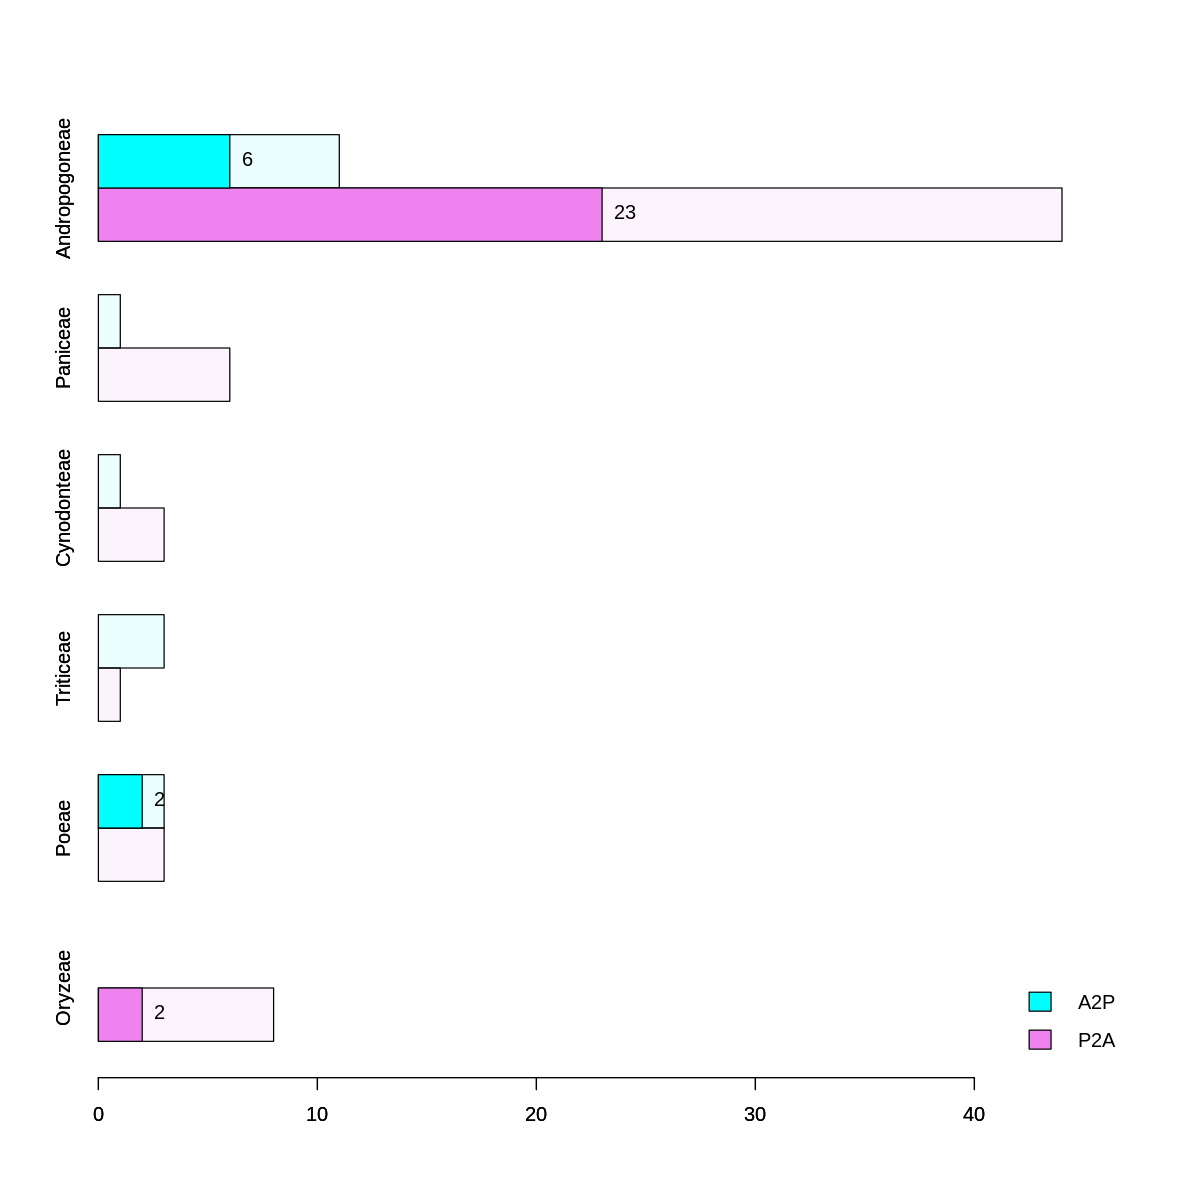

In [753]:
options(repr.plot.width=10, repr.plot.height=10)
bp = barplot(t(transitionByTribe_soft[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]),
             beside = T,horiz = T,col = scales::alpha(c("violet","cyan"),.08),xlim = c(0,48))
# text(t(transitionByTribe_soft[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]),
#       bp,t(transitionByTribe_soft[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]),
#      pos = 4)
bp2 = barplot(t(transitionByTribe[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]),
             beside = T,horiz = T,col = c("violet","cyan"),legend.text = T,
             args.legend = list(x="bottomright",bty = 'n'),add = T)
text(t(transitionByTribe[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]),
      bp2,t(transitionByTribe[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]),
     pos = 4)

In [545]:
png("/workdir/sh2246/p_phyloGWAS/output/figure/lifeHistory/Fig1b.png",width = 8.7,height = 8.7*1.3,units = "cm",
    pointsize = 6,res = 600)
par(mar = c(5,5,1,1))
bp = barplot(t(transitionByTribe[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]),
             beside = T,horiz = T,col = c("violet","cyan"),legend.text = T,
             args.legend = list(x="bottomright",bty = 'n'),xlim = c(0,48))
text(t(transitionByTribe[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]),
      bp,t(transitionByTribe[c("Oryzeae","Poeae","Triticeae","Cynodonteae","Paniceae","Andropogoneae"),]),
     pos = 4)
dev.off()

pdf 
  2

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale

pdf 
  2

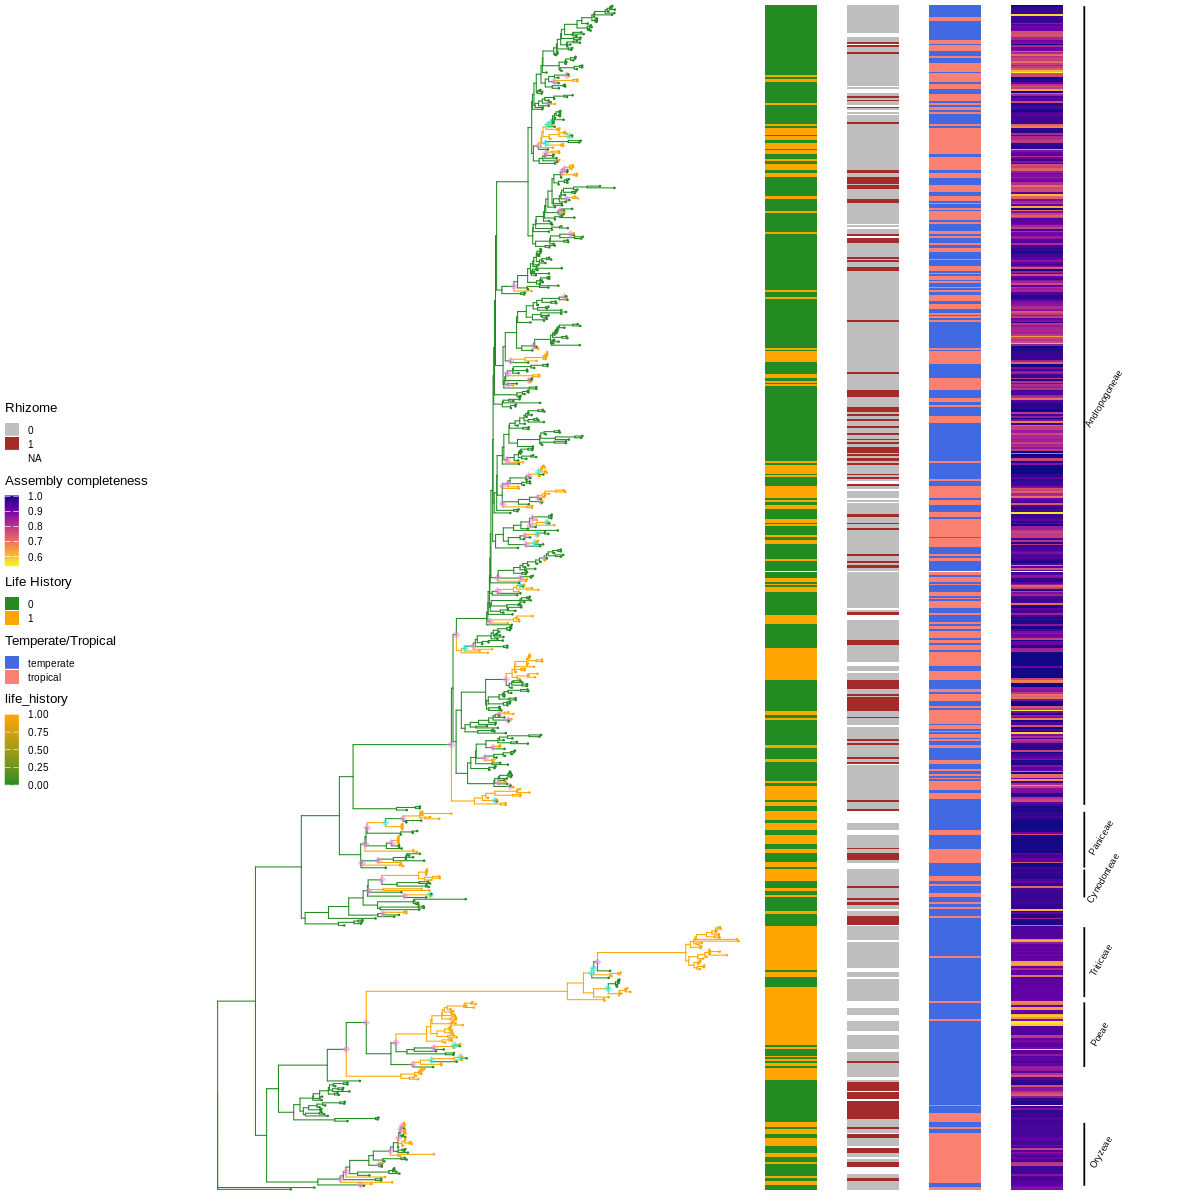

In [666]:
options(repr.plot.width=10, repr.plot.height=10)

p <- ggtree(plotTree,layout = "rectangular", ladderize = T,size = .3,aes(color = life_history))+
        scale_color_continuous(low='forestgreen', high='orange') +
    geom_nodepoint(color=ifelse(679:1355%in%plotTree@phylo$edge[P2A,1],"violet",NA), alpha=1/2, size=2,shape = 18) +  
    geom_nodepoint(color=ifelse(679:1355%in%plotTree@phylo$edge[A2P,1],"cyan",NA), alpha=1/2, size=2,shape = 18) +
    geom_tippoint(color=ifelse(lifeHistoryNumeric[lifeHistoryID]==1,"orange","forestgreen"),
                       shape=19, size=.1)
p <- p + geom_cladelab(node=highlightNodeDat2$node, align=T,angle = 60,fontsize = 2,offset = .45,hjust = 0.3,vjust =2,
                       label=c("Andropogoneae","Cynodonteae","Oryzeae","Paniceae","Poeae","Triticeae"))
p1 <- p+ new_scale_fill()
p1 <- gheatmap(p1, as.data.frame(as.factor(lifeHistoryNumeric[lifeHistoryID])) , offset=0, width=0.1,colnames = F,color = NA) +
    scale_x_ggtree() + 
    scale_y_continuous(expand=c(0, 0.3))+
    scale_fill_manual(values = c('forestgreen','orange'),name = "Life History")
p1 <- p1+ new_scale_fill()
p1 <- gheatmap(p1, as.data.frame(as.factor(rhizomeDatVec)), offset=0.11, width=0.1,colnames = F,color = NA) +
    scale_x_ggtree() + 
    scale_y_continuous(expand=c(0, 0.3))+
    scale_fill_manual(values = c("grey",'brown'),name = "Rhizome",na.value = "white")
p1 <- p1+ new_scale_fill()
p1 <- gheatmap(p1, as.data.frame(tempTrop[lifeHistoryID]) , offset=.22, width=0.1,colnames = F,color = NA) +
    scale_x_ggtree() + 
    scale_y_continuous(expand=c(0, 0.3))+
    scale_fill_manual(values = c("royalblue","salmon"),name = "Temperate/Tropical")
p1 <- p1+ new_scale_fill()
p1 <- gheatmap(p1, as.data.frame(compDupLabel), offset=.33, width=0.1,colnames = F,color = NA) +
    scale_x_ggtree() + 
    scale_y_continuous(expand=c(0, .3))+
    xlim(0,1.25) +
    scale_fill_viridis_c(option = "plasma",direction = -1,name = "Assembly completeness") +
    theme(axis.text=element_text(size=5),legend.position = "left",legend.key.width = unit(3,units = "mm"),
          legend.key.height = unit(3,units = "mm"),
          legend.margin = margin(t = -2,r =0,b = 0,l =0, unit='mm'),
          plot.margin = margin(t= 1, r= 1,b = 1,l = 1, unit='mm'),
          legend.title = element_text(size = 8),legend.text = element_text(size = 6))
p1

png("/workdir/sh2246/p_phyloGWAS/output/figure/lifeHistory/Fig1a.png",width = 8.7*1.6,height = 17.4,units = "cm",
    pointsize = 6,res = 600)
p1
dev.off()


In [744]:
plotTree_relabeled = plotTree@phylo

In [745]:
merge_tab5=data.frame(assemblyID=plotTree_relabeled$tip.label)
merge_tab5=merge(merge_tab5,metadata,by = "assemblyID")
merge_tab5=merge_tab5[!duplicated(merge_tab5$assemblyID),]
rownames(merge_tab5)=merge_tab5$assemblyID
merge_tab5=merge_tab5[plotTree_relabeled$tip.label,]

plotTree_relabeled$tip.label[!is.na(merge_tab5$spTaxa)] = merge_tab5$spTaxa[!is.na(merge_tab5$spTaxa)]

In [746]:
plotTree_relabeled = full_join(plotTree_relabeled, d, by = 'node')

In [747]:
plotTree_relabeled@phylo$node.label[-1] = round(as.numeric(plotTree_relabeled@phylo$node.label[-1]),2)

In [748]:
plotTree_relabeled@phylo$node.label = paste0(plotTree_relabeled@phylo$node.label,"; ",
                                             round(fit$lik.anc[,1],2),"-",round(fit$lik.anc[,2],2))

In [749]:
class(plotTree_relabeled@phylo$node.label)

[1] "character"

Warning message:
“Removed 652 rows containing missing values or values outside the scale range
(`geom_point_g_gtree()`).”
Warning message:
“Removed 669 rows containing missing values or values outside the scale range
(`geom_point_g_gtree()`).”


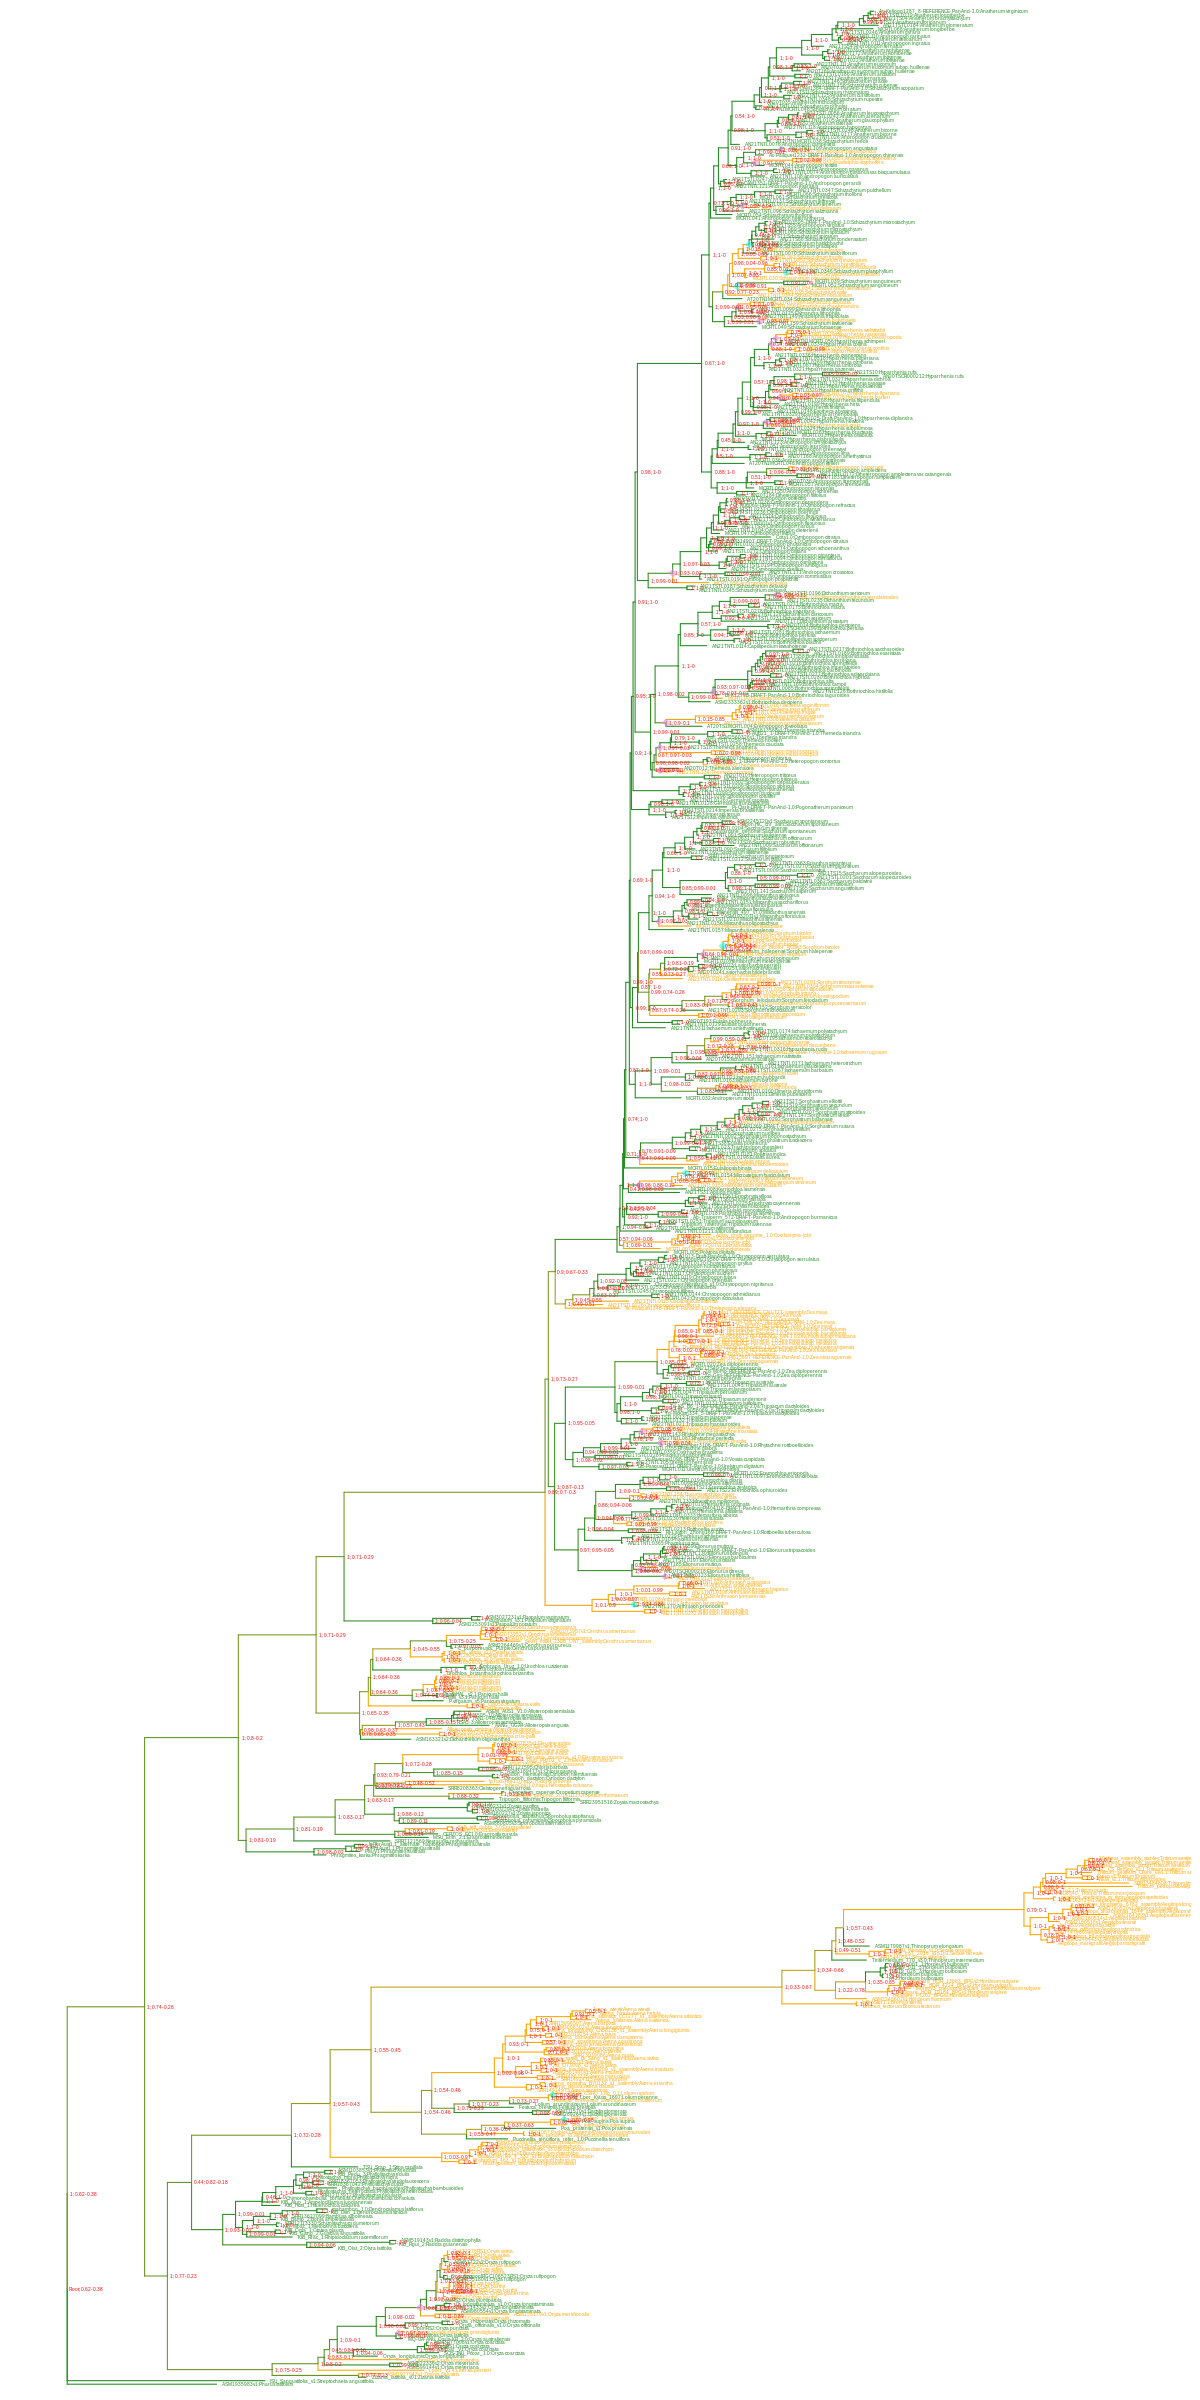

In [750]:
options(repr.plot.width=10, repr.plot.height=20)
p <- ggtree(plotTree_relabeled,layout = "rectangular", ladderize = T,size = .3,aes(color = life_history))+
        scale_color_continuous(low='forestgreen', high='orange') +
    geom_nodepoint(color=ifelse(679:1355%in%plotTree@phylo$edge[P2A,1],"violet",NA), alpha=1/2, size=2,shape = 18) +  
    geom_nodepoint(color=ifelse(679:1355%in%plotTree@phylo$edge[A2P,1],"cyan",NA), alpha=1/2, size=2,shape = 18) +
    geom_tiplab(color=ifelse(lifeHistoryNumeric[lifeHistoryID]==1,"orange","forestgreen"),size = 1)+
    geom_nodelab(vjust=.5,hjust = 0.1, size=1,color = "red") +
    theme(legend.position = "none")

p

In [751]:
png("/workdir/sh2246/p_phyloGWAS/output/angiosperm353_astral3_spLabeled_withLifeHistoryACE_20250416.png",
    height = 60,width = 20, unit = "cm",pointsize = 6,res = 600)
p
dev.off()

Warning message:
“Removed 652 rows containing missing values or values outside the scale range
(`geom_point_g_gtree()`).”
Warning message:
“Removed 669 rows containing missing values or values outside the scale range
(`geom_point_g_gtree()`).”


pdf 
  2

In [287]:
highlightNodeDat2

node Tribe        
1 898  Andropogoneae
2 834  Cynodonteae  
3 793  Oryzeae      
4 863  Paniceae     
5 728  Poeae        
6 687  Triticeae

In [286]:
rownames(coldAdaptCount)[rowSums(coldAdaptCount)>20]


[1] "Andropogoninae" "Anthistiriinae" "Apludinae"      "Ischaeminae"   
[5] "Saccharinae"    "Sorghinae"      "Tripsacinae"

In [53]:
cor(as.data.frame(ePCs$environmental.features)$bio12_Annual_Precipitation_quan50,
    ePCs$synthetic.environmental.traits[,1])^2
cor(as.data.frame(ePCs$environmental.features)$bio12_Annual_Precipitation_quan50,
    ePCs$synthetic.environmental.traits[,2])^2
ppcor::pcor(cbind(ePCs$synthetic.environmental.traits[,1],
                  as.data.frame(ePCs$environmental.features)$bio12_Annual_Precipitation_quan50,
                  as.data.frame(ePCs$environmental.features)$bio01_Annual_Mean_Temperature_quan50))$estimate^2

[1] 0.2469844

[1] 0.5434227

[,1]      [,2]      [,3]     
[1,] 1.0000000 0.1895212 0.9396072
[2,] 0.1895212 1.0000000 0.1090216
[3,] 0.9396072 0.1090216 1.0000000

In [62]:
cor(eTraits_filtered$bio01_Annual_Mean_Temperature_quan50,eTraits_filtered$bio12_Annual_Precipitation_quan50)

[1] 0.408251

In [63]:
length(spTre.rooted.filtered$tip.label)

[1] 759

In [106]:
eTraits_filtered[c("10wheat_assembly_jagger","Hvulgare_FT262_BPGv2",'Pp-Kellogg1297-DRAFT-PanAnd-1.0',
                   "Avena_sativa_cv_Sang_v1_assembly","mabamboo_1.0","Setaria_viridis_v2.0",
                  "P.virgatum_v5","IRGSP-1.0","Ag-CAM1351-DRAFT-PanAnd-1.0",
                   "Sn-CAM1369-DRAFT-PanAnd-1.0","Sorghum_bicolor_NCBIv3",
                  "Td-FL_9056069_6-REFERENCE-PanAnd-2.0a","Zm-B73-REFERENCE-NAM-5.0"),c(2,11)]

bio01_Annual_Mean_Temperature_quan50
10wheat_assembly_jagger               13.107166                           
Hvulgare_FT262_BPGv2                   9.944000                           
Pp-Kellogg1297-DRAFT-PanAnd-1.0        5.928833                           
Avena_sativa_cv_Sang_v1_assembly       9.851333                           
mabamboo_1.0                          21.007500                           
Setaria_viridis_v2.0                  12.338834                           
P.virgatum_v5                         11.643056                           
IRGSP-1.0                             22.983167                           
Ag-CAM1351-DRAFT-PanAnd-1.0            9.587667                           
Sn-CAM1369-DRAFT-PanAnd-1.0           12.271000                           
Sorghum_bicolor_NCBIv3                15.217083                           
Td-FL_9056069_6-REFERENCE-PanAnd-2.0a 17.364666                           
Zm-B73-REFERENCE-NAM-5.0              20.856667                           
                                      bio12_Annual_Precipitation_quan50
10wheat_assembly_jagger                301.0                           
Hvulgare_FT262_BPGv2                   782.0                           
Pp-Kellogg1297-DRAFT-PanAnd-1.0        602.0                           
Avena_sativa_cv_Sang_v1_assembly       780.0                           
mabamboo_1.0                          1819.0                           
Setaria_viridis_v2.0                   833.0                           
P.virgatum_v5                          957.0                           
IRGSP-1.0                             1461.5                           
Ag-CAM1351-DRAFT-PanAnd-1.0            851.0                           
Sn-CAM1369-DRAFT-PanAnd-1.0            952.0                           
Sorghum_bicolor_NCBIv3                 835.5                           
Td-FL_9056069_6-REFERENCE-PanAnd-2.0a 1030.0                           
Zm-B73-REFERENCE-NAM-5.0              1000.0

In [61]:
options(repr.plot.width=10, repr.plot.height=10)

par(mfrow = c(1,2))
plotTraitOnTree(eTraits_filtered$bio01_Annual_Mean_Temperature_quan50,
                commonID,spTre.rooted.filtered,visible_tip_labels = F,
                legend.title = "Annual Mean Temp.",col = c("blue","lightblue","red"))
plotTraitOnTree(eTraits_filtered$bio12_Annual_Precipitation_quan50,
                commonID,spTre.rooted.filtered,visible_tip_labels = F,direction = 'leftwards',
                legend.title = "Annual Precipitation",col = c("brown","lightgreen","forestgreen"))


options(repr.plot.width=10, repr.plot.height=10)

par(mfrow = c(1,2))
plotTraitOnTree(ePCs$synthetic.environmental.traits[commonID,1],
                commonID,spTre.rooted.filtered,visible_tip_labels = F,
                legend.title = "envPC1",col = c("blue","lightblue","red"))
plotTraitOnTree(scale(ePCs$synthetic.environmental.traits[commonID,2],center = T,scale = T),
                commonID,spTre.rooted.filtered,visible_tip_labels = F,direction = 'leftwards',
                legend.title = "envPC2",col = c("forestgreen","lightgreen","brown"))


png("/workdir/sh2246/p_phyloGWAS/output/envAdapt_Bio1Quan50_PhyloTree.png",width = 20,height = 80,units = "cm",res = 600,pointsize = 6)
plotTraitOnTree(eTraits_filtered$bio01_Annual_Mean_Temperature_quan50,
                commonID,spTre.rooted.filtered,visible_tip_labels = T,
                legend.title = "Annual Mean Temp.",col = c("blue","lightblue","red"),fontsize = .5)
dev.off()

png("/workdir/sh2246/p_phyloGWAS/output/envAdapt_Bio12Quan50_PhyloTree.png",width = 20,height = 80,units = "cm",res = 600,pointsize = 6)
plotTraitOnTree(eTraits_filtered$bio12_Annual_Precipitation_quan50,
                commonID,spTre.rooted.filtered,visible_tip_labels = T,
                legend.title = "Annual Mean Temp.",col = c("brown","lightgreen","forestgreen"),fontsize = .5)
dev.off()

png 
  2

In [108]:
eTraits_filtered[which.min(eTraits_filtered[,11]),c(2,11)]

bio01_Annual_Mean_Temperature_quan50
AN21TNTL0121 27.19183                            
             bio12_Annual_Precipitation_quan50
AN21TNTL0121 74

In [105]:
rownames(eTraits_filtered)[grep('Pp',rownames(eTraits_filtered))]

[1] "Pp-Kellogg1297-DRAFT-PanAnd-1.0"

# annualism & env.

In [19]:
eTraits_filtered$assemblyID = rownames(eTraits_filtered)


In [20]:
mergedData = merge(metadata,eTraits_filtered,by ="assemblyID")

In [21]:
dim(eTraits_filtered)

[1] 759 326

In [22]:
colnames(eTraits_filtered)[grep("Seasonality",colnames(eTraits_filtered))]

[1] "bio15_Precipitation_Seasonality_quan10"
[2] "bio15_Precipitation_Seasonality_quan50"
[3] "bio15_Precipitation_Seasonality_quan90"
[4] "bio04_Temperature_Seasonality_quan10"  
[5] "bio04_Temperature_Seasonality_quan50"  
[6] "bio04_Temperature_Seasonality_quan90"

In [23]:
mergedData = mergedData %>% filter(lifeHistory=='annual'|lifeHistory=='perennial')

In [24]:
mergedData$lifeHistoryNumeric = as.numeric(as.factor(mergedData$lifeHistory))

In [40]:
anova(lm(mergedData$lifeHistoryNumeric~mergedData$bio15_Precipitation_Seasonality_quan50))
anova(lm(mergedData$lifeHistoryNumeric~mergedData$bio04_Temperature_Seasonality_quan50))
anova(lm(mergedData$lifeHistoryNumeric~mergedData$bio04_Temperature_Seasonality_quan50+mergedData$bio15_Precipitation_Seasonality_quan50))
anova(lm(mergedData$lifeHistoryNumeric~mergedData$bio04_Temperature_Seasonality_quan50*mergedData$bio15_Precipitation_Seasonality_quan50*mergedData$bio01_Annual_Mean_Temperature_quan50))

Df  Sum Sq     Mean Sq  
mergedData$bio15_Precipitation_Seasonality_quan50   1   2.178637 2.1786370
Residuals                                         724 159.486652 0.2202854
                                                  F value  Pr(>F)     
mergedData$bio15_Precipitation_Seasonality_quan50 9.890064 0.001729674
Residuals                                               NA          NA

Df  Sum Sq     Mean Sq  
mergedData$bio04_Temperature_Seasonality_quan50   1   2.273284 2.2732845
Residuals                                       724 159.392005 0.2201547
                                                F value  Pr(>F)     
mergedData$bio04_Temperature_Seasonality_quan50 10.32585 0.001369933
Residuals                                             NA          NA

Df  Sum Sq     Mean Sq  
mergedData$bio04_Temperature_Seasonality_quan50     1   2.273284 2.2732845
mergedData$bio15_Precipitation_Seasonality_quan50   1   5.334313 5.3343132
Residuals                                         723 154.057692 0.2130812
                                                  F value  Pr(>F)      
mergedData$bio04_Temperature_Seasonality_quan50   10.66863 1.141094e-03
mergedData$bio15_Precipitation_Seasonality_quan50 25.03418 7.078793e-07
Residuals                                               NA           NA

Df 
mergedData$bio04_Temperature_Seasonality_quan50                                                                                                     1
mergedData$bio15_Precipitation_Seasonality_quan50                                                                                                   1
mergedData$bio01_Annual_Mean_Temperature_quan50                                                                                                     1
mergedData$bio04_Temperature_Seasonality_quan50:mergedData$bio15_Precipitation_Seasonality_quan50                                                   1
mergedData$bio04_Temperature_Seasonality_quan50:mergedData$bio01_Annual_Mean_Temperature_quan50                                                     1
mergedData$bio15_Precipitation_Seasonality_quan50:mergedData$bio01_Annual_Mean_Temperature_quan50                                                   1
mergedData$bio04_Temperature_Seasonality_quan50:mergedData$bio15_Precipitation_Seasonality_quan50:mergedData$bio01_Annual_Mean_Temperature_quan50   1
Residuals                                                                                                                                         718
                                                                                                                                                  Sum Sq      
mergedData$bio04_Temperature_Seasonality_quan50                                                                                                   2.273284e+00
mergedData$bio15_Precipitation_Seasonality_quan50                                                                                                 5.334313e+00
mergedData$bio01_Annual_Mean_Temperature_quan50                                                                                                   3.647818e-03
mergedData$bio04_Temperature_Seasonality_quan50:mergedData$bio15_Precipitation_Seasonality_quan50                                                 2.551830e+00
mergedData$bio04_Temperature_Seasonality_quan50:mergedData$bio01_Annual_Mean_Temperature_quan50                                                   5.471557e-01
mergedData$bio15_Precipitation_Seasonality_quan50:mergedData$bio01_Annual_Mean_Temperature_quan50                                                 1.057293e+01
mergedData$bio04_Temperature_Seasonality_quan50:mergedData$bio15_Precipitation_Seasonality_quan50:mergedData$bio01_Annual_Mean_Temperature_quan50 2.055593e-03
Residuals                                                                                                                                         1.403801e+02
                                                                                                                                                  Mean Sq     
mergedData$bio04_Temperature_Seasonality_quan50                                                                                                    2.273284496
mergedData$bio15_Precipitation_Seasonality_quan50                                                                                                  5.334313167
mergedData$bio01_Annual_Mean_Temperature_quan50                                                                                                    0.003647818
mergedData$bio04_Temperature_Seasonality_quan50:mergedData$bio15_Precipitation_Seasonality_quan50                                                  2.551830377
mergedData$bio04_Temperature_Seasonality_quan50:mergedData$bio01_Annual_Mean_Temperature_quan50                                                    0.547155685
mergedData$bio15_Precipitation_Seasonality_quan50:mergedData$bio01_Annual_Mean_Temperature_quan50                                                 10.572926726
mergedData$bio04_Temperature_Seasonality_quan50:mergedData$bio15_Precipitation_Seasonality_quan50:mergedData$bio01_Annual_Mean_Temperature_quan50  0.002055593
Residuals                                                                                    

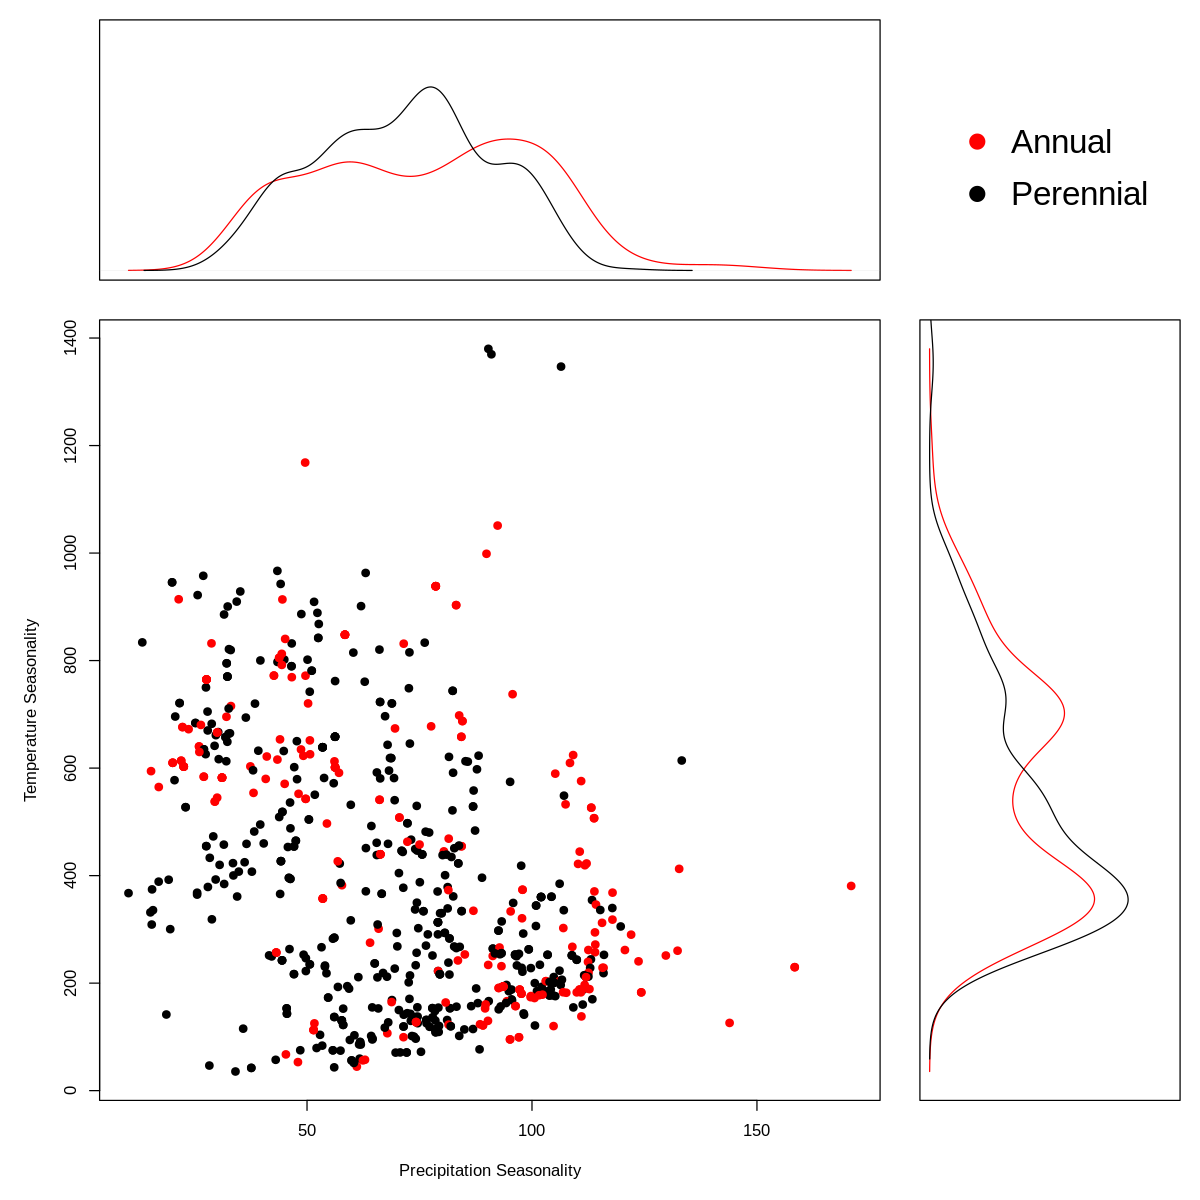

In [41]:
layout(matrix(1:4,2,2),widths = c(3,1),heights = c(1,3))
par(mar = c(1,5,1,1))
plot(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"]),
     type ='l',col = "red",main = '',xaxt ='n',yaxt = 'n',xlab = '',ylab = '',ylim = c(0,.02))
points(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"]),
     type ='l',col = "black")
par(mar = c(5,5,1,1))
plot(mergedData$bio15_Precipitation_Seasonality_quan50,
     mergedData$bio04_Temperature_Seasonality_quan50,
     pch  = 19, col = ifelse(mergedData$lifeHistoryNumeric=="1","red","black"),
     xlab = "Precipitation Seasonality",ylab = "Temperature Seasonality")
plot(1,1,type = 'n',axes = F,xlab = '',ylab ='')
par(mar = c(1,1,1,1))
legend(0.3,1.1,legend = c("Annual","Perennial"),col = c("red","black"),pch = 19,bty ='n',cex = 2)
par(mar = c(5,1,1,1))
d1 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"])
d2 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"])
plot(d1$y,d1$x,type ='l',col = "red",xlim = c(0,.0025),xlab = '',ylab = '',xaxt = 'n',yaxt = 'n')
points(d2$y,d2$x,type ='l',col = "black")

In [25]:
mycol = rep(NA,nrow(mergedData))
mycol[mergedData$bio01_Annual_Mean_Temperature_quan50>18] = "darkred"
mycol[mergedData$bio01_Annual_Mean_Temperature_quan50<18] = "darkblue"
mypch = ifelse(mergedData$lifeHistoryNumeric=="1",1,19)

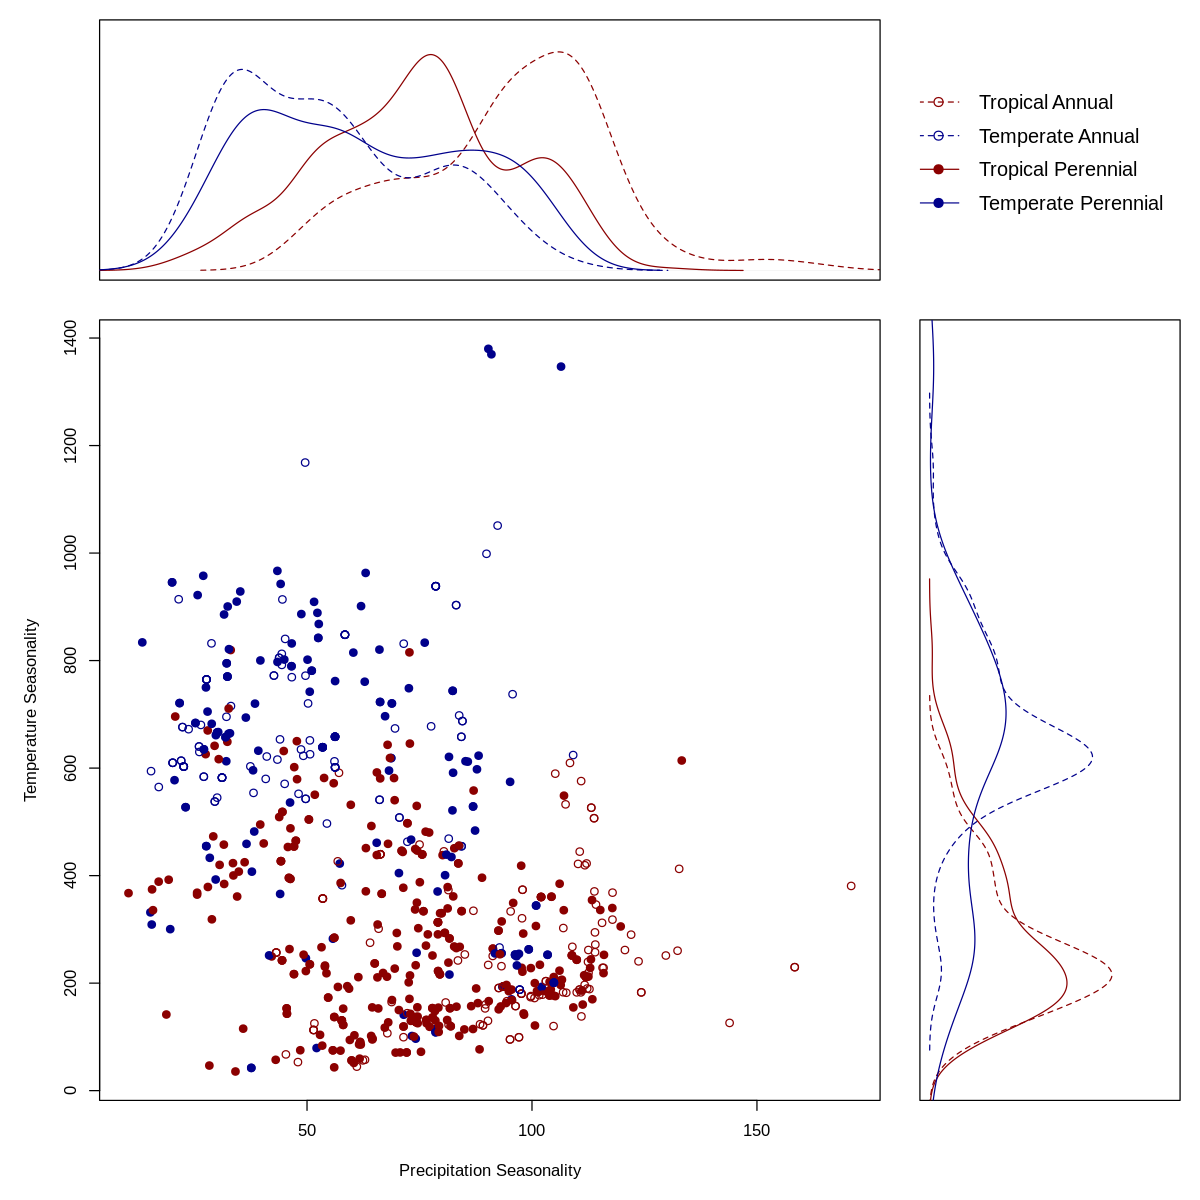

In [28]:
options(repr.plot.width=10, repr.plot.height=10)

layout(matrix(1:4,2,2),widths = c(3,1),heights = c(1,3))
par(mar = c(1,5,1,1))
plot(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18]),
     type ='l',col = "darkred",main = '',xaxt ='n',yaxt = 'n',xlab = '',ylab = '',ylim = c(0,.02),xlim = c(0,180),lty=2)
points(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18]),
     type ='l',col = "darkblue",lty =2)
points(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18]),
     type ='l',col = "darkred")
points(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18]),
     type ='l',col = "darkblue")


par(mar = c(5,5,1,1))
plot(mergedData$bio15_Precipitation_Seasonality_quan50,
     mergedData$bio04_Temperature_Seasonality_quan50,
     pch  = mypch, col = mycol,
     xlab = "Precipitation Seasonality",ylab = "Temperature Seasonality")
plot(1,1,type = 'n',axes = F,xlab = '',ylab ='')
par(mar = c(1,1,1,1))
legend(0.15,1.2,legend = c("Tropical Annual","Temperate Annual","Tropical Perennial","Temperate Perennial"),
       col = c("darkred","darkblue","darkred","darkblue"),pch = c(1,1,19,19),lty=c(2,2,1,1),bty ='n',cex = 1.2)
par(mar = c(5,1,1,1))
d1 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18])
d2 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18])
d3 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18])
d4 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18])
plot(d1$y,d1$x,type ='l',col = "darkred",xlim = c(0,.005),ylim = c(0,1400),xlab = '',ylab = '',xaxt = 'n',yaxt = 'n',lty =2)
points(d2$y,d2$x,type ='l',col = "darkblue",lty= 2)
points(d3$y,d3$x,type ='l',col = "darkred")
points(d4$y,d4$x,type ='l',col = "darkblue")

In [37]:
png("/workdir/sh2246/p_phyloGWAS/output/lifeHistorySeasonalityAss.png",width = 17.4,height = 17.4,units = "cm",res = 600,pointsize = 8)
layout(matrix(1:4,2,2),widths = c(3,1),heights = c(1,3))
par(mar = c(1,5,1,1))
plot(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18]),
     type ='l',col = "darkred",main = '',xaxt ='n',yaxt = 'n',xlab = '',ylab = '',ylim = c(0,.02),xlim = c(0,180),lty=2)
points(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18]),
     type ='l',col = "darkblue",lty =2)
points(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18]),
     type ='l',col = "darkred")
points(density(mergedData$bio15_Precipitation_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18]),
     type ='l',col = "darkblue")


par(mar = c(5,5,1,1))
plot(mergedData$bio15_Precipitation_Seasonality_quan50,
     mergedData$bio04_Temperature_Seasonality_quan50,
     pch  = mypch, col = mycol,
     xlab = "Precipitation Seasonality",ylab = "Temperature Seasonality")
plot(1,1,type = 'n',axes = F,xlab = '',ylab ='')
par(mar = c(1,1,1,1))
legend(0.17,1.1,legend = c("Tropical Annual","Temperate Annual","Tropical Perennial","Temperate Perennial"),y.intersp = 2,
       col = c("darkred","darkblue","darkred","darkblue"),pch = c(1,1,19,19),lty=c(2,2,1,1),bty ='n',pt.cex = 1,cex = 1.25,seg.len = 3)
par(mar = c(5,1,1,1))
d1 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18])
d2 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18])
d3 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18])
d4 = density(mergedData$bio04_Temperature_Seasonality_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18])
plot(d1$y,d1$x,type ='l',col = "darkred",xlim = c(0,.005),ylim = c(0,1400),xlab = '',ylab = '',xaxt = 'n',yaxt = 'n',lty =2)
points(d2$y,d2$x,type ='l',col = "darkblue",lty= 2)
points(d3$y,d3$x,type ='l',col = "darkred")
points(d4$y,d4$x,type ='l',col = "darkblue")
dev.off()

png 
  2

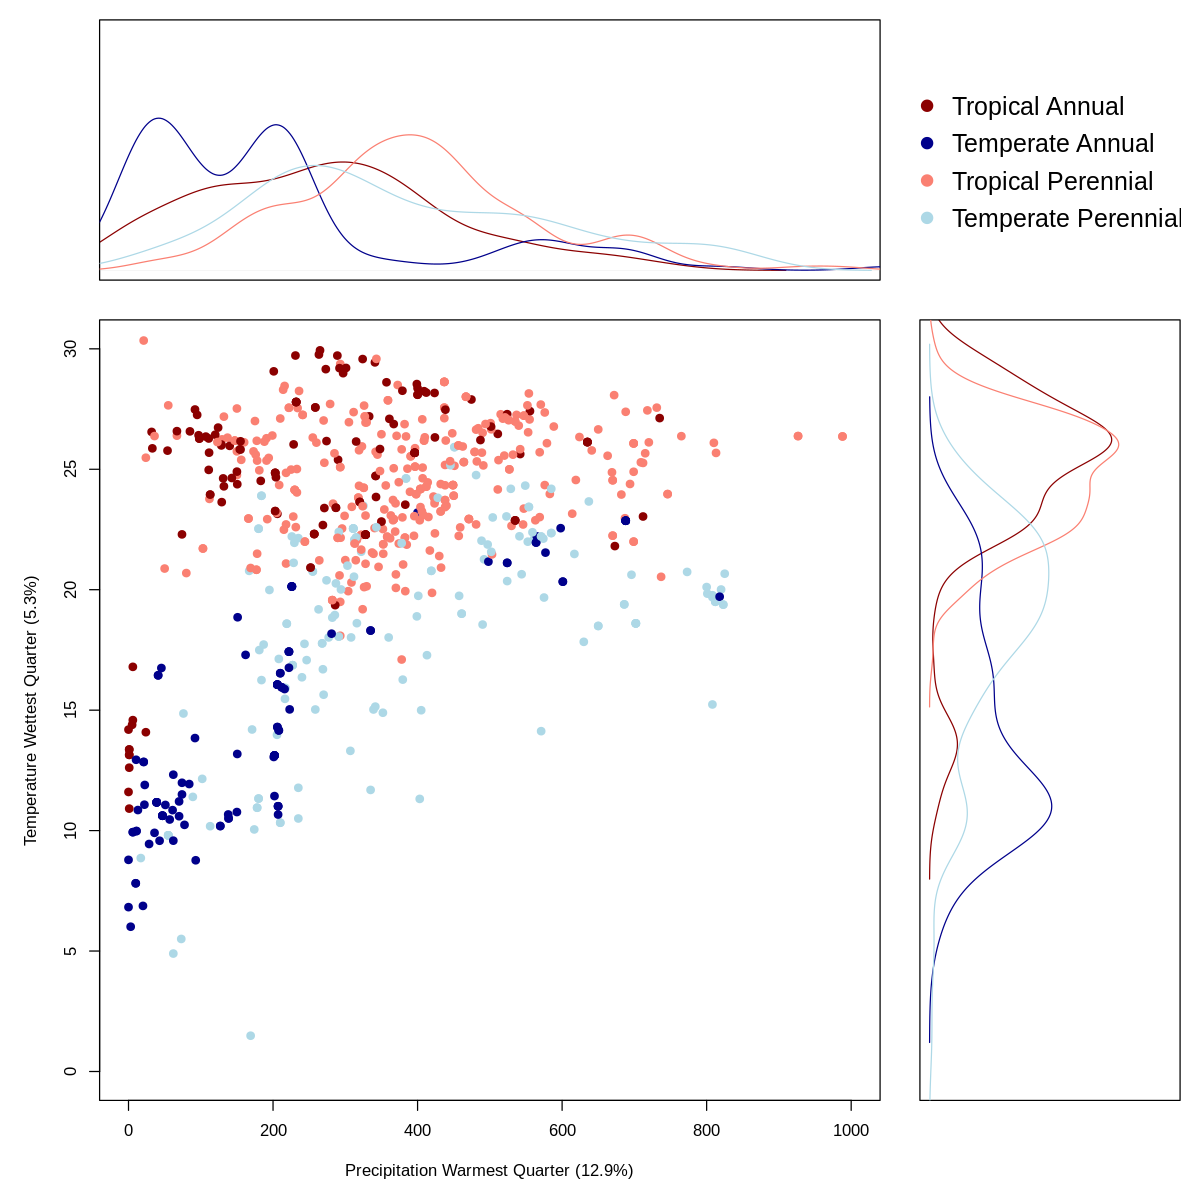

In [145]:
options(repr.plot.width=10, repr.plot.height=10)

layout(matrix(1:4,2,2),widths = c(3,1),heights = c(1,3))
par(mar = c(1,5,1,1))
plot(density(mergedData$bio18_Precipitation_Warmest_Quarter_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18]),
     type ='l',col = "darkred",main = '',xaxt ='n',yaxt = 'n',xlab = '',ylab = '',ylim = c(0,.005),xlim = c(0,1000))
points(density(mergedData$bio18_Precipitation_Warmest_Quarter_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18]),
     type ='l',col = "darkblue")
points(density(mergedData$bio18_Precipitation_Warmest_Quarter_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18]),
     type ='l',col = "salmon")
points(density(mergedData$bio18_Precipitation_Warmest_Quarter_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18]),
     type ='l',col = "lightblue")


par(mar = c(5,5,1,1))
plot(mergedData$bio18_Precipitation_Warmest_Quarter_quan50,
     mergedData$bio08_Mean_Temperature_Wettest_Quarter_quan50,
     pch  = 19, col = mycol,xlim = c(0,1000),ylim = c(0,30),
     xlab = "Precipitation Warmest Quarter (12.9%)",ylab = "Temperature Wettest Quarter (5.3%)")
plot(1,1,type = 'n',axes = F,xlab = '',ylab ='')
par(mar = c(1,1,1,1))
legend(0.1,1.2,legend = c("Tropical Annual","Temperate Annual","Tropical Perennial","Temperate Perennial"),
       col = c("darkred","darkblue","salmon","lightblue"),pch = 19,bty ='n',cex = 1.5)
par(mar = c(5,1,1,1))
d1 = density(mergedData$bio08_Mean_Temperature_Wettest_Quarter_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18])
d2 = density(mergedData$bio08_Mean_Temperature_Wettest_Quarter_quan50[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18])
d3 = density(mergedData$bio08_Mean_Temperature_Wettest_Quarter_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18])
d4 = density(mergedData$bio08_Mean_Temperature_Wettest_Quarter_quan50[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18])
plot(d1$y,d1$x,type ='l',col = "darkred",xlim = c(0,.2),ylim = c(0,30),xlab = '',ylab = '',xaxt = 'n',yaxt = 'n')
points(d2$y,d2$x,type ='l',col = "darkblue")
points(d3$y,d3$x,type ='l',col = "salmon")
points(d4$y,d4$x,type ='l',col = "lightblue")

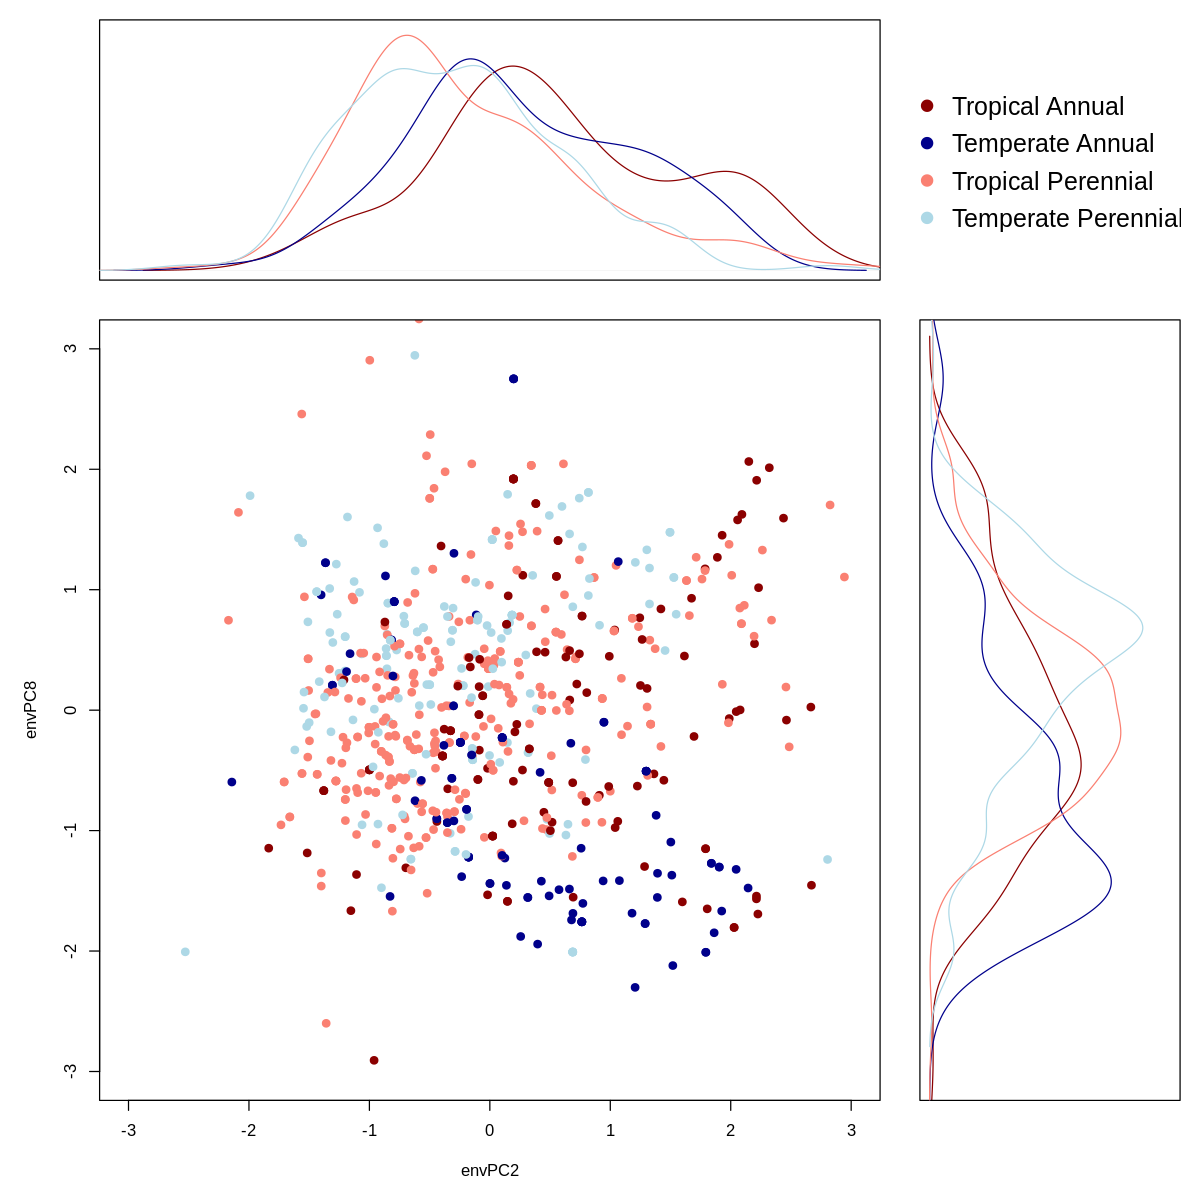

In [141]:
options(repr.plot.width=10, repr.plot.height=10)

layout(matrix(1:4,2,2),widths = c(3,1),heights = c(1,3))
par(mar = c(1,5,1,1))
plot(density(mergedData$envPC_2[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18]),
     type ='l',col = "darkred",main = '',xaxt ='n',yaxt = 'n',xlab = '',ylab = '',ylim = c(0,.5),xlim = c(-3,3))
points(density(mergedData$envPC_2[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18]),
     type ='l',col = "darkblue")
points(density(mergedData$envPC_2[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18]),
     type ='l',col = "salmon")
points(density(mergedData$envPC_2[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18]),
     type ='l',col = "lightblue")


par(mar = c(5,5,1,1))
plot(mergedData$envPC_2,
     mergedData$envPC_8,
     pch  = 19, col = mycol,xlim = c(-3,3),ylim = c(-3,3),
     xlab = "envPC2 (8.9%)",ylab = "envPC8 (5.6%)")
plot(1,1,type = 'n',axes = F,xlab = '',ylab ='')
par(mar = c(1,1,1,1))
legend(0.1,1.2,legend = c("Tropical Annual","Temperate Annual","Tropical Perennial","Temperate Perennial"),
       col = c("darkred","darkblue","salmon","lightblue"),pch = 19,bty ='n',cex = 1.5)
par(mar = c(5,1,1,1))
d1 = density(mergedData$envPC_8[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18])
d2 = density(mergedData$envPC_8[mergedData$lifeHistoryNumeric=="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18])
d3 = density(mergedData$envPC_8[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50>18])
d4 = density(mergedData$envPC_8[mergedData$lifeHistoryNumeric!="1"&mergedData$bio01_Annual_Mean_Temperature_quan50<18])
plot(d1$y,d1$x,type ='l',col = "darkred",xlim = c(0,.6),ylim = c(-3,3),xlab = '',ylab = '',xaxt = 'n',yaxt = 'n')
points(d2$y,d2$x,type ='l',col = "darkblue")
points(d3$y,d3$x,type ='l',col = "salmon")
points(d4$y,d4$x,type ='l',col = "lightblue")

In [135]:
ppcor::pcor(cbind(mergedData$lifeHistoryNumeric,
                  mergedData$bio18_Precipitation_Warmest_Quarter_quan50,
                  mergedData$bio08_Mean_Temperature_Wettest_Quarter_quan50))$estimate^2

[,1]       [,2]       [,3]      
[1,] 1.00000000 0.08741548 0.00852687
[2,] 0.08741548 1.00000000 0.14263935
[3,] 0.00852687 0.14263935 1.00000000

In [142]:
ppcor::pcor(cbind(mergedData$lifeHistoryNumeric,
                  mergedData$envPC_2,
                  mergedData$envPC_8))$estimate^2

[,1]       [,2]        [,3]       
[1,] 1.00000000 0.091935218 0.059122726
[2,] 0.09193522 1.000000000 0.003483384
[3,] 0.05912273 0.003483384 1.000000000

In [108]:
mycol2 = rep(NA,nrow(mergedData))
mycol2[mergedData$latest_name%in%"Zea diploperennis"] = "yellow"
mycol2[mergedData$latest_name%in%"Zea mays"] = "darkorange"
mycol2[mergedData$latest_name%in%"Sorghum halepense"] = "salmon"
mycol2[mergedData$latest_name%in%"Sorghum bicolor"] = "darkred"
mycol2[mergedData$latest_name%in%"Oryza rufipogon"] = "lightgreen"
mycol2[mergedData$latest_name%in%"Oryza sativa"] = "darkgreen"
mycol2[mergedData$latest_name%in%"Panicum hallii"] = "lightblue"
mycol2[mergedData$latest_name%in%"Panicum miliaceum"] = "darkblue"
mycol2[mergedData$latest_name%in%"Thinopyrum elongatum"] = "pink"
mycol2[mergedData$latest_name%in%"Triticum aestivum"] = "purple"

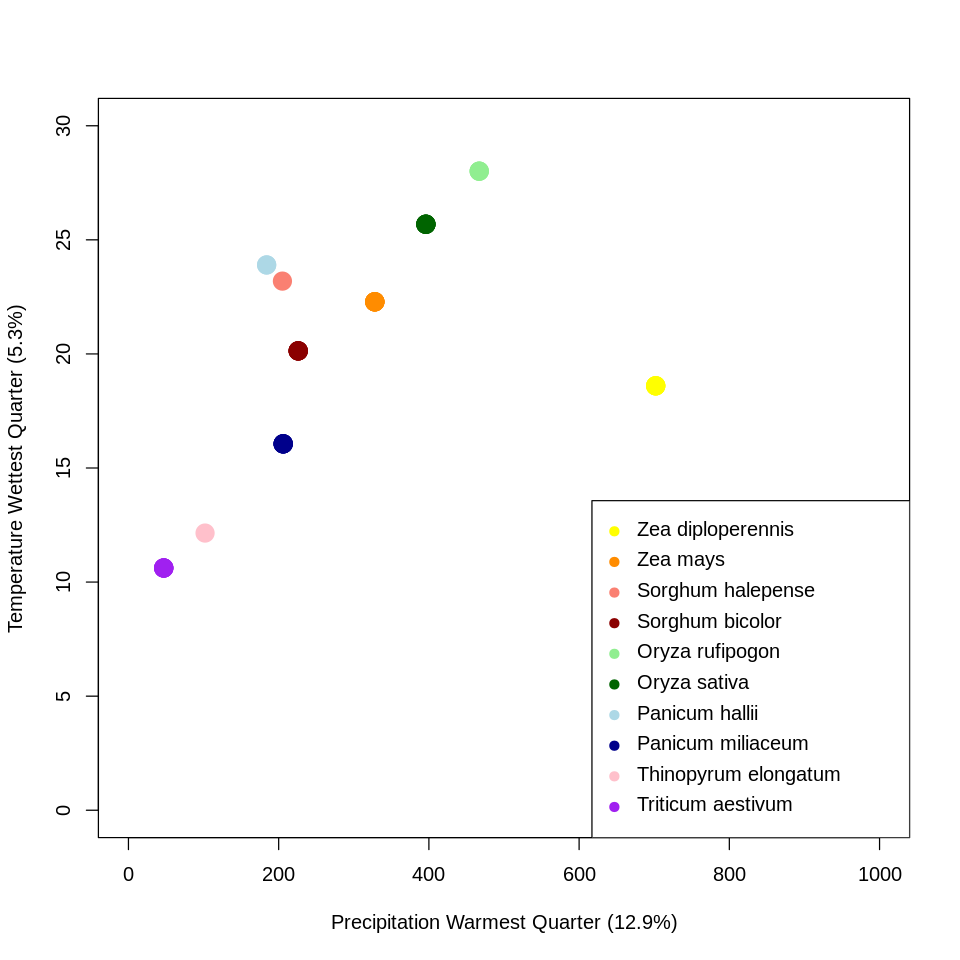

In [144]:
options(repr.plot.width=8, repr.plot.height=8)

plot(mergedData$bio18_Precipitation_Warmest_Quarter_quan50,
     mergedData$bio08_Mean_Temperature_Wettest_Quarter_quan50,
     pch  = 19, col = mycol2,xlim = c(0,1000),ylim = c(0,30),cex = 2,
     xlab = "Precipitation Warmest Quarter (12.9%)",ylab = "Temperature Wettest Quarter (5.3%)")
legend("bottomright",legend = c("Zea diploperennis","Zea mays",
                             "Sorghum halepense","Sorghum bicolor",
                             "Oryza rufipogon","Oryza sativa",
                             "Panicum hallii","Panicum miliaceum",
                             "Thinopyrum elongatum", "Triticum aestivum"),
       col = c("yellow","darkorange","salmon","darkred","lightgreen","darkgreen",
               "lightblue","darkblue","pink","purple"),
       pch = 19,cex = 1)

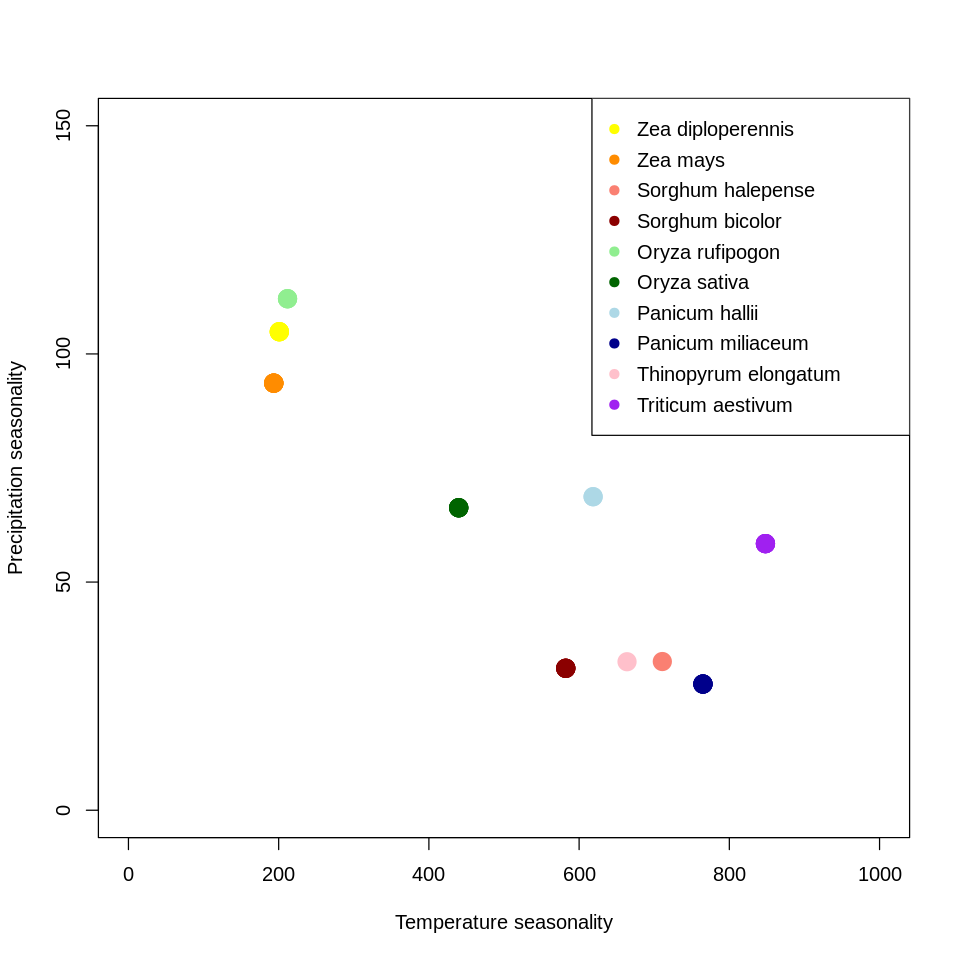

In [153]:
options(repr.plot.width=8, repr.plot.height=8)

plot(mergedData$bio04_Temperature_Seasonality_quan50,
     mergedData$bio15_Precipitation_Seasonality_quan50,
     pch  = 19, col = mycol2,xlim = c(0,1000),ylim = c(0,150),cex = 2,
     xlab = "Temperature seasonality",ylab = "Precipitation seasonality")
legend("topright",legend = c("Zea diploperennis","Zea mays",
                             "Sorghum halepense","Sorghum bicolor",
                             "Oryza rufipogon","Oryza sativa",
                             "Panicum hallii","Panicum miliaceum",
                             "Thinopyrum elongatum", "Triticum aestivum"),
       col = c("yellow","darkorange","salmon","darkred","lightgreen","darkgreen",
               "lightblue","darkblue","pink","purple"),
       pch = 19,cex = 1)

In [45]:
quan50Idx = grep("quan50",colnames(mergedData))

corRes = c()
for (i in quan50Idx){
    tmp = cor.test(mergedData$lifeHistoryNumeric,mergedData[,i])
    corRes = rbind(corRes,c(tmp$estimate,tmp$p.value))
}


Warning message in cor(x, y):
“the standard deviation is zero”


In [51]:
ePCIdx = grep("PC",colnames(mergedData))

corRes2 = c()
for (i in ePCIdx){
    tmp = cor.test(mergedData$lifeHistoryNumeric,mergedData[,i])
    corRes2 = rbind(corRes2,c(tmp$estimate,tmp$p.value))
}


In [52]:
rownames(corRes) = gsub("_quan50","",colnames(mergedData)[quan50Idx])
rownames(corRes2) = colnames(mergedData)[ePCIdx]

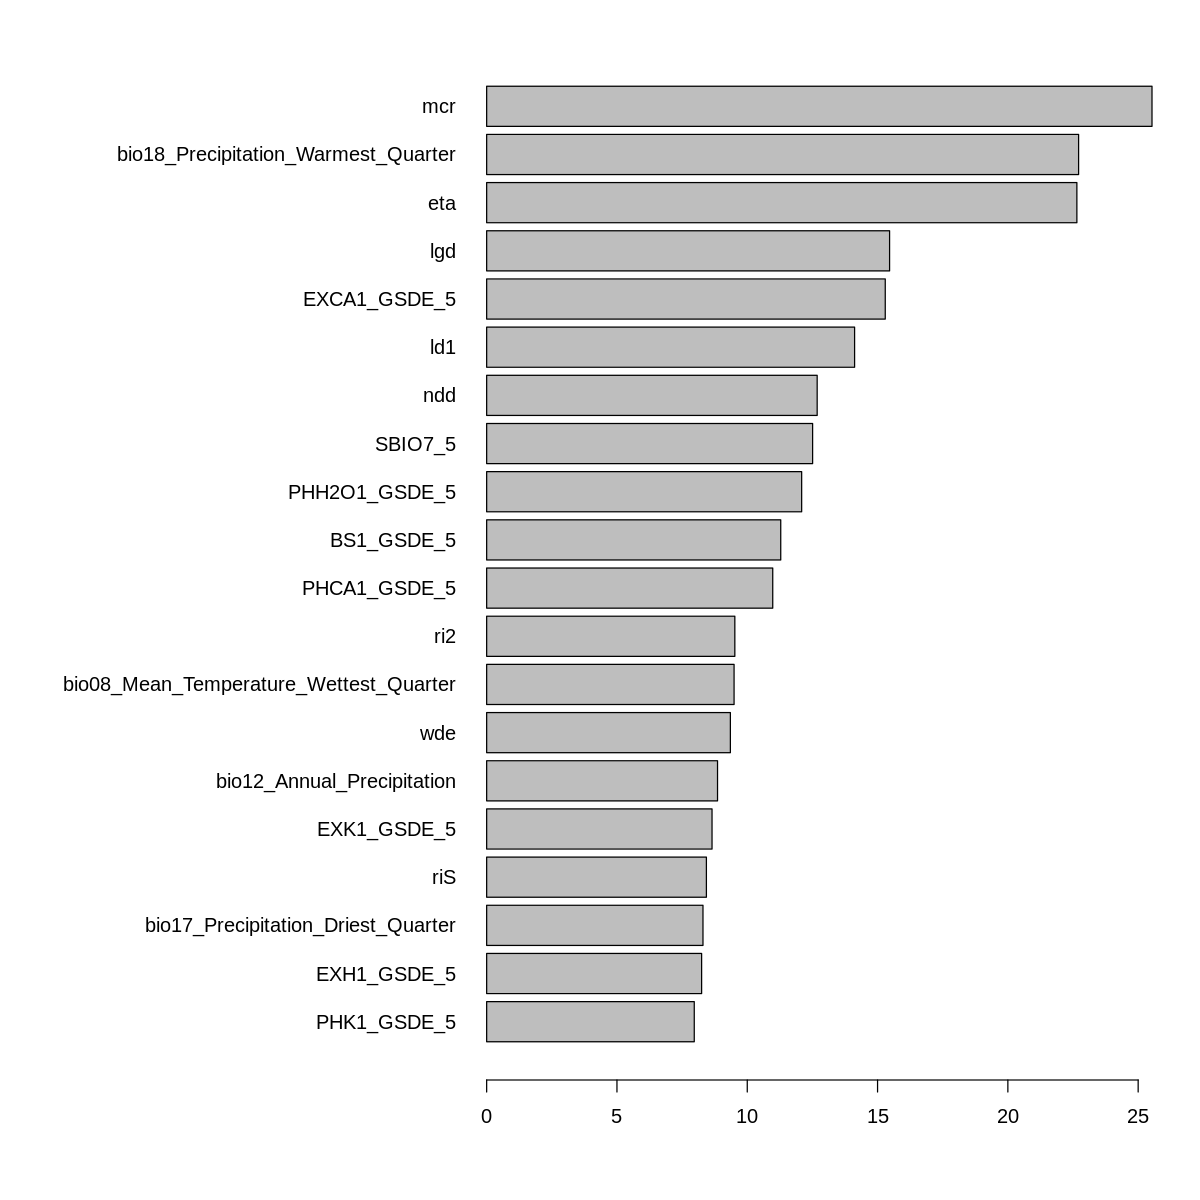

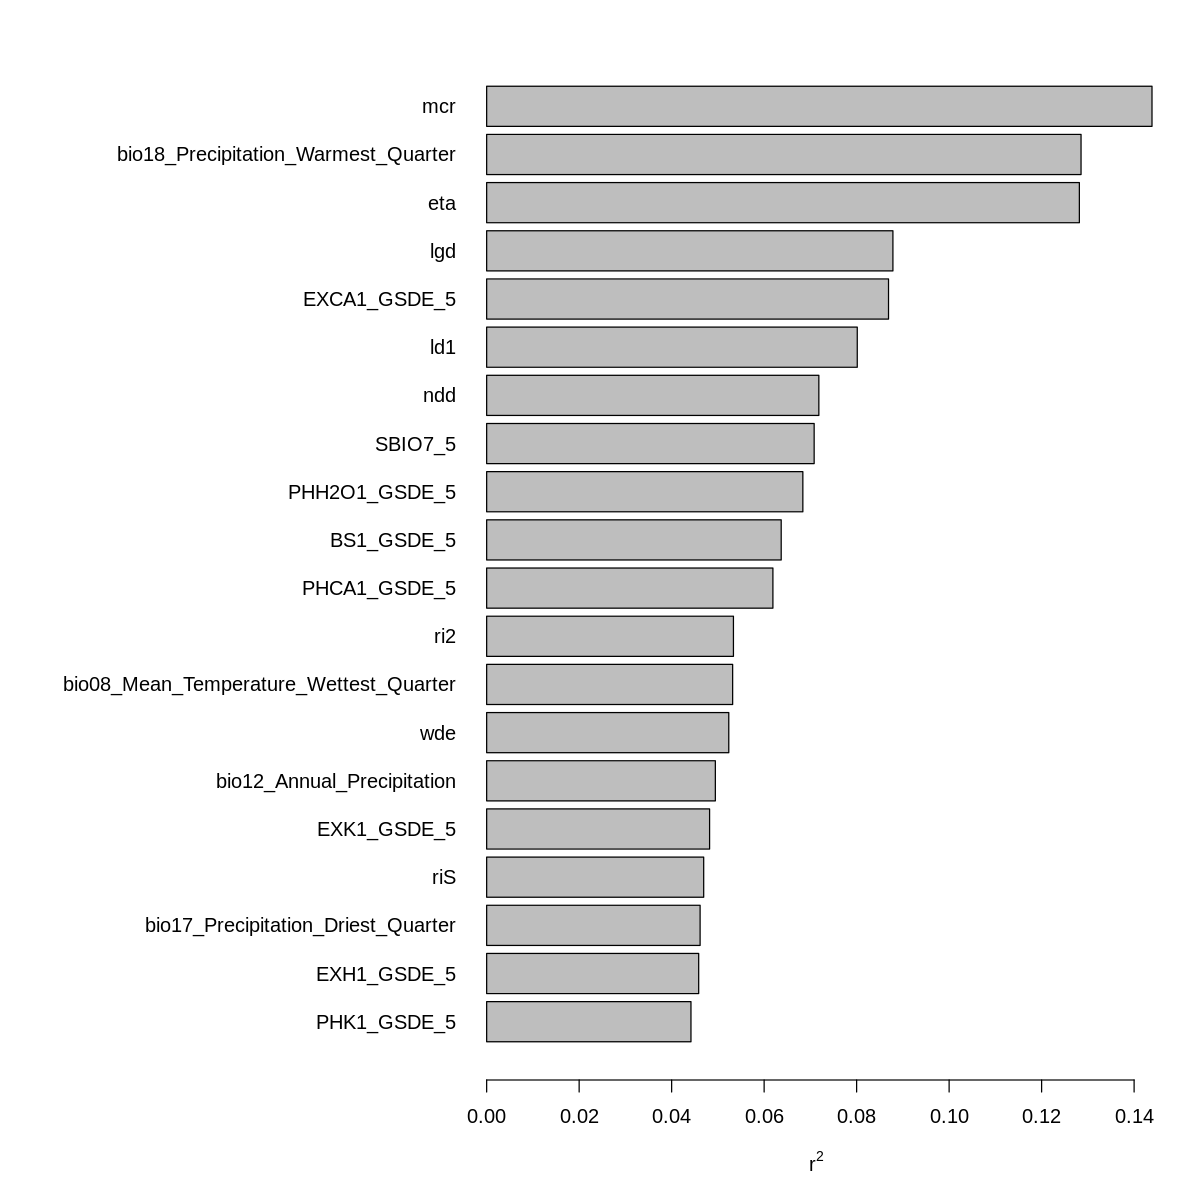

In [53]:
options(repr.plot.width=10, repr.plot.height=10)
par(mar = c(5,20,2,2))
barplot(tail(sort(-log10(corRes[,2])),20),horiz = T,las = 1)
barplot(tail(sort(corRes[,1]^2),20),horiz = T,las = 1,xlab = expression(r^2))

In [143]:
tail(sort(corRes[,1]^2),10)
tail(sort(corRes2[,1]^2),10)

BS1_GSDE_5                       PHH2O1_GSDE_5 
                         0.06369153                          0.06837237 
                            SBIO7_5                                 ndd 
                         0.07081767                          0.07183231 
                                ld1                        EXCA1_GSDE_5 
                         0.08013791                          0.08689732 
                                lgd                                 eta 
                         0.08784780                          0.12816394 
bio18_Precipitation_Warmest_Quarter                                 mcr 
                         0.12852670                          0.14386907

envPC_19    envPC_28     envPC_4     envPC_3    envPC_32    envPC_17 
0.008027028 0.008195189 0.011957758 0.013776192 0.014523861 0.018206663 
    envPC_6     envPC_9     envPC_8     envPC_2 
0.020992118 0.035120000 0.056072807 0.088991663

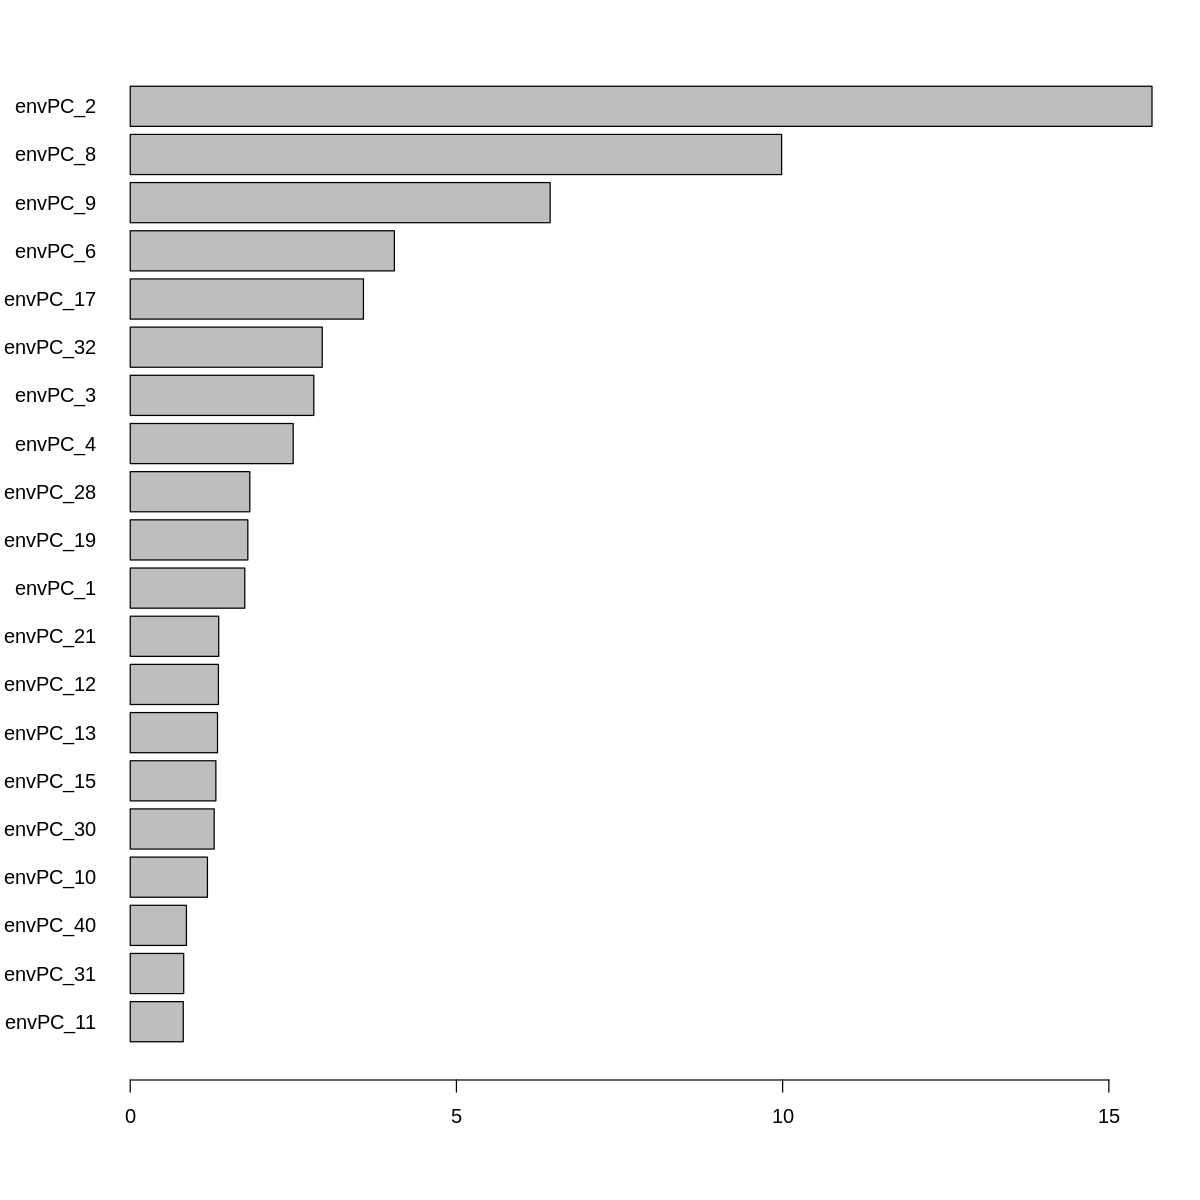

png 
  2

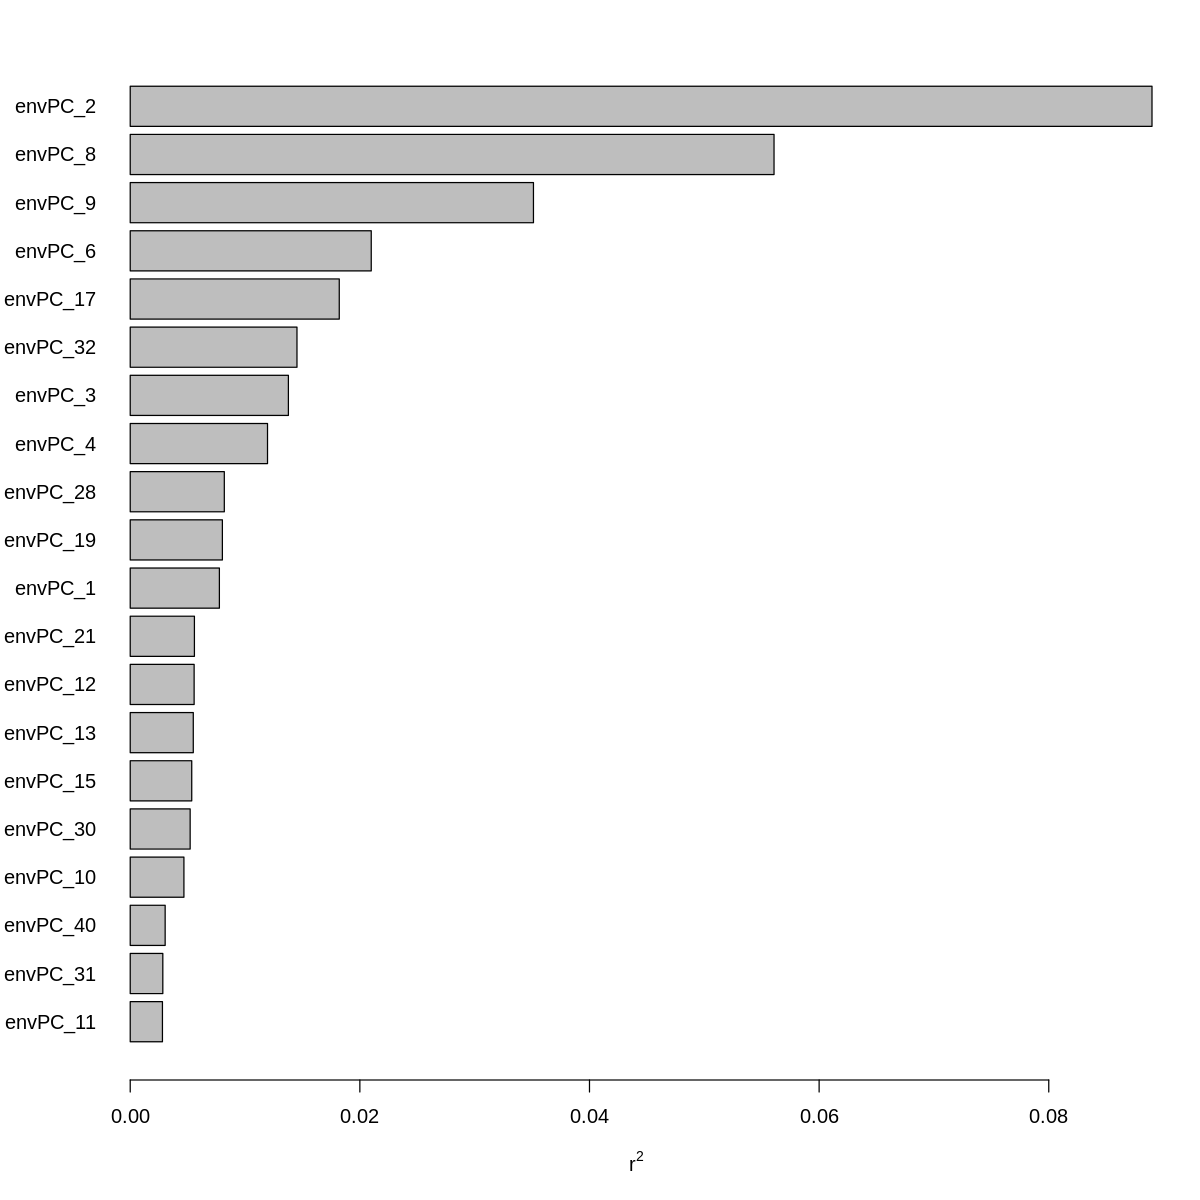

In [54]:
options(repr.plot.width=10, repr.plot.height=10)
par(mar = c(5,5,2,2))
barplot(tail(sort(-log10(corRes2[,2])),20),horiz = T,las = 1)
barplot(tail(sort(corRes2[,1]^2),20),horiz = T,las = 1,xlab = expression(r^2))
png("/workdir/sh2246/p_phyloGWAS/output/envPC_perenniality_association.png",width = 16,height = 16, units = "cm",res = 600,pointsize = 8)
par(mar = c(5,8,2,2))
barplot(tail(sort(corRes2[,1]^2),20),horiz = T,las = 1,xlab = expression(r^2))
dev.off()

In [535]:
write.table(ePCs$variable.components,"/workdir/sh2246/p_phyloGWAS/output/envPC_loading_mat.txt",sep = "\t",col.names = T,row.names = T,quote = F)

In [60]:
tmpX = apply(eTraits_filtered[,1:285],2,function(x) scale(x))
tmpX[is.na(tmpX)] = 0

In [78]:
y2 = ePCs$variable.components[seq(2,285,3),3]%*%t(tmpX[,seq(2,285,3)])

[1] 0.7313954

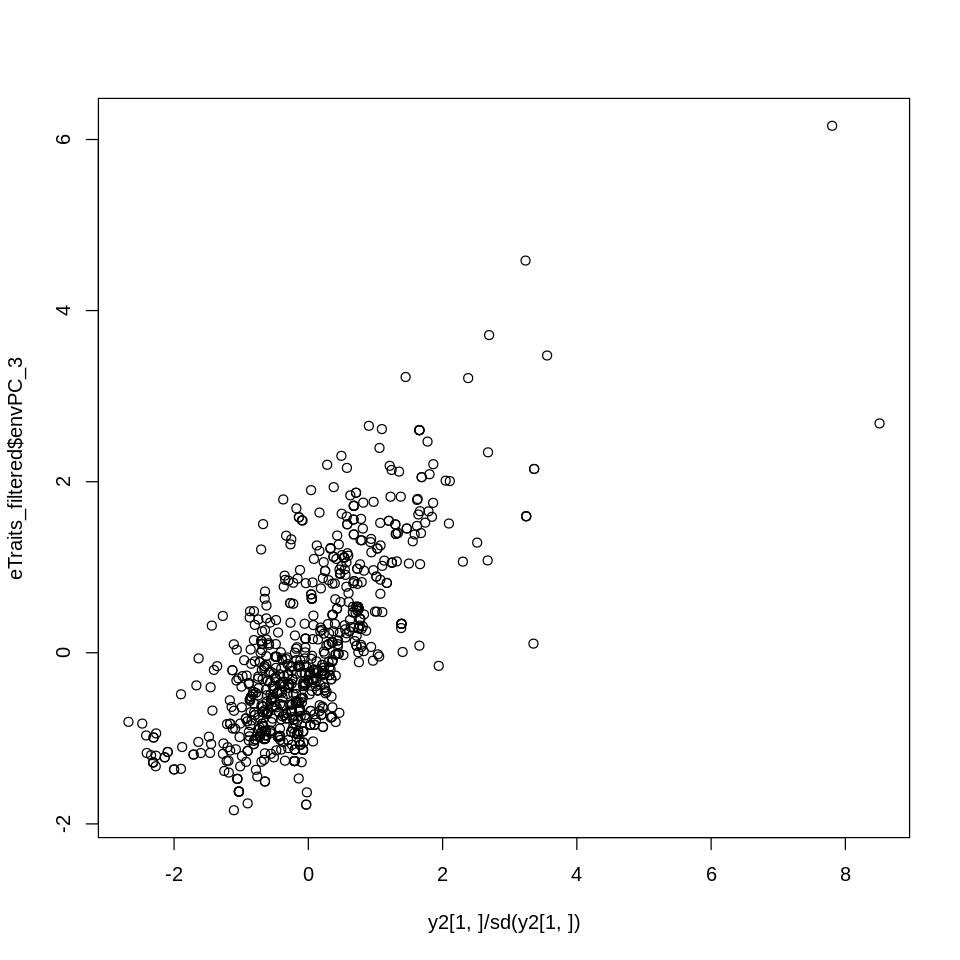

In [79]:
plot(y2[1,]/sd(y2[1,]),eTraits_filtered$envPC_3)
cor(y2[1,],eTraits_filtered$envPC_3)

In [317]:
ePCIdx

[1] 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
[20] 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
[39] 324 325

In [320]:
summary(lm(as.numeric(traitMat[commonID2,2])~eTraits_filtered[commonID2,287]+eTraits_filtered[commonID2,293] +eTraits_filtered[commonID2,294]))

Warning message in eval(predvars, data, env):
“NAs introduced by coercion”



Call:
lm(formula = as.numeric(traitMat[commonID2, 2]) ~ eTraits_filtered[commonID2, 
    287] + eTraits_filtered[commonID2, 293] + eTraits_filtered[commonID2, 
    294])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9952 -0.3953  0.1765  0.3048  0.7585 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       1.66387    0.01606 103.606  < 2e-16 ***
eTraits_filtered[commonID2, 287] -0.13336    0.01597  -8.352 3.59e-16 ***
eTraits_filtered[commonID2, 293]  0.12307    0.01599   7.698 4.71e-14 ***
eTraits_filtered[commonID2, 294] -0.08824    0.01566  -5.635 2.54e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4261 on 700 degrees of freedom
  (19 observations deleted due to missingness)
Multiple R-squared:   0.19,	Adjusted R-squared:  0.1865 
F-statistic: 54.73 on 3 and 700 DF,  p-value: < 2.2e-16


In [122]:
tail(na.omit(ePCs$variable.correlation[order(ePCs$variable.correlation[,2]^2),]),20)

envPC_1  envPC_2  envPC_3  envPC_4  envPC_5 
bio12_Annual_Precipitation_quan50  0.49698 -0.73717  0.05438  0.02163  0.17273
ld1_quan10                         0.21701 -0.78126  0.20526 -0.00128  0.31496
lgd_quan10                         0.13777 -0.78505  0.17629  0.02496  0.34124
rid_quan90                         0.00251 -0.79022 -0.19562  0.12997 -0.08838
SBIO2_5_quan10                    -0.11467  0.79271  0.27561 -0.26190  0.07713
ri2_quan10                         0.12541 -0.79590  0.35543 -0.09972  0.29642
ndr_quan90                         0.06031 -0.80149 -0.28832  0.13739 -0.16726
SBIO2_5_quan90                     0.01552  0.80552 -0.26959 -0.11833 -0.26046
ri2_quan90                         0.11727 -0.80667 -0.17311  0.10078 -0.09989
wde_quan10                         0.21733  0.80672  0.34971 -0.02596  0.09360
rid_quan10                         0.08878 -0.80945  0.34073 -0.08860  0.31405
ndr_quan10                         0.12839 -0.82810  0.24662  0.02520  0.23130
ld1_quan50                         0.15670 -0.82816 -0.13999  0.08046  0.17690
wde_quan90                         0.28978  0.82819 -0.21713  0.01457 -0.21247
lgd_quan50                         0.11895 -0.83022 -0.15221  0.09436  0.17956
SBIO2_5_quan50                    -0.03834  0.86871  0.00233 -0.22211 -0.07242
ndr_quan50                         0.04332 -0.87065 -0.06666  0.12647  0.00059
wde_quan50                         0.27465  0.88562  0.09013 -0.05017 -0.04612
ri2_quan50                         0.15078 -0.88981  0.06595  0.01789  0.11853
rid_quan50                         0.05440 -0.89612  0.03451  0.04301  0.12143
                                  envPC_6  envPC_7  envPC_8  envPC_9  envPC_10
bio12_Annual_Precipitation_quan50  0.17871  0.08826 -0.00052  0.03919  0.13070
ld1_quan10                        -0.19370 -0.03352 -0.01335 -0.01094 -0.15971
lgd_quan10                        -0.23627 -0.03548 -0.04169  0.01569 -0.19695
rid_quan90                         0.26281  0.14334 -0.08572  0.00458  0.18055
SBIO2_5_quan10                    -0.01081 -0.07192  0.20004  0.03661 -0.01090
ri2_quan10                         0.11180  0.01167  0.07200  0.00232  0.02331
ndr_quan90                         0.13754  0.12398 -0.17149 -0.02868  0.01635
SBIO2_5_quan90                     0.09512  0.07067  0.15702 -0.02644 -0.00494
ri2_quan90                         0.27842  0.16331 -0.04047 -0.02606  0.14369
wde_quan10                         0.07073 -0.11354  0.04600  0.05987  0.09584
rid_quan10                         0.09805  0.00740  0.04690  0.01719  0.03685
ndr_quan10                        -0.01800 -0.03790 -0.05371  0.01533 -0.05053
ld1_quan50                        -0.17596  0.07055 -0.05240 -0.03567 -0.22285
wde_quan90                         0.12588  0.01795  0.00828  0.01003  0.08415
lgd_quan50                        -0.18548  0.07513 -0.06135 -0.02965 -0.24276
SBIO2_5_quan50                     0.05010  0.00408  0.20121  0.01470 -0.01864
ndr_quan50                         0.06397  0.02464 -0.17274 -0.00399  0.02304
wde_quan50                         0.09743 -0.05628  0.08268  0.03340  0.07656
ri2_quan50                         0.22943  0.11075 -0.00613 -0.02237  0.09218
rid_quan50                         0.21733  0.09248 -0.05605 -0.00252  0.12771
                                  ⋯ envPC_31 envPC_32 envPC_33 envPC_34
bio12_Annual_Precipitation_quan50 ⋯  0.03223 -0.02841 -0.01952  0.01356
ld1_quan10                        ⋯ -0.01205 -0.05291  0.02948  0.05905
lgd_quan10                        ⋯ -0.02630 -0.07531  0.00841  0.05065
rid_quan90                        ⋯  0.06852  0.10628  0.04694 -0.05944
SBIO2_5_quan10                    ⋯  0.01551 -0.01844 -0.03071 -0.02074
ri2_quan10                        ⋯ -0.01438  0.03758 -0.07915 -0.00797
ndr_quan90                        ⋯  0.03521  0.08627 -0.00090  0.02001
SBIO2_5_quan90                    ⋯  0.05952  0.03247  0.00386 -0.00707
ri2_quan90                        ⋯  0.03183  0.09064  0.04026 -0.07

In [123]:
tail(na.omit(ePCs$variable.correlation[order(ePCs$variable.correlation[,8]^2),]),20)

envPC_1  envPC_2  envPC_3 
CEC1_GSDE_5_quan90                            -0.13844 -0.06339 -0.22971
TN1_GSDE_5_quan90                             -0.10971 -0.37709 -0.18078
SBIO8_5_quan50                                 0.72690  0.02873 -0.30506
bio18_Precipitation_Warmest_Quarter_quan50     0.17726 -0.71546 -0.04241
SBIO9_15_quan90                                0.64459  0.35939 -0.21371
TN1_GSDE_5_quan50                             -0.16114 -0.44337  0.16750
SBIO8_15_quan90                                0.63918  0.12709 -0.46600
TC1_GSDE_5_quan90                             -0.16443 -0.37163 -0.13895
bio08_Mean_Temperature_Wettest_Quarter_quan50  0.76250 -0.08989 -0.24497
bio09_Mean_Temperature_Driest_Quarter_quan90   0.65174  0.27458 -0.18731
SBIO8_5_quan90                                 0.58957  0.08332 -0.47326
SBIO3_5_quan90                                 0.33868  0.18727 -0.01375
bio18_Precipitation_Warmest_Quarter_quan10     0.11707 -0.63233  0.20934
SBIO3_5_quan50                                 0.24556  0.28985  0.09911
bio19_Precipitation_Coldest_Quarter_quan50     0.16763 -0.23798  0.06212
SBIO9_5_quan90                                 0.58712  0.40890 -0.18041
bio02_Mean_Diurnal_Range_quan50                0.08821  0.56127 -0.01250
bio19_Precipitation_Coldest_Quarter_quan90     0.32875 -0.29699 -0.18402
bio02_Mean_Diurnal_Range_quan10                0.09953  0.45946  0.25383
bio08_Mean_Temperature_Wettest_Quarter_quan90  0.63584 -0.08078 -0.42776
                                              envPC_4  envPC_5  envPC_6 
CEC1_GSDE_5_quan90                             0.39332  0.09929 -0.25253
TN1_GSDE_5_quan90                              0.18994  0.00665 -0.25913
SBIO8_5_quan50                                -0.06419  0.30965  0.13225
bio18_Precipitation_Warmest_Quarter_quan50    -0.12466  0.12089  0.17056
SBIO9_15_quan90                                0.27125 -0.10797 -0.03304
TN1_GSDE_5_quan50                              0.09325  0.04730 -0.04636
SBIO8_15_quan90                               -0.07423  0.13750  0.14672
TC1_GSDE_5_quan90                              0.16953  0.08590 -0.23926
bio08_Mean_Temperature_Wettest_Quarter_quan50 -0.11983  0.27010  0.13814
bio09_Mean_Temperature_Driest_Quarter_quan90   0.27681 -0.15832 -0.09602
SBIO8_5_quan90                                -0.06496  0.17377  0.20639
SBIO3_5_quan90                                 0.11463 -0.40797 -0.04612
bio18_Precipitation_Warmest_Quarter_quan10    -0.20066  0.27738  0.08788
SBIO3_5_quan50                                 0.03244 -0.29684 -0.03571
bio19_Precipitation_Coldest_Quarter_quan50     0.16146  0.22381 -0.04656
SBIO9_5_quan90                                 0.29644 -0.12898 -0.05069
bio02_Mean_Diurnal_Range_quan50               -0.40373 -0.15405 -0.23521
bio19_Precipitation_Coldest_Quarter_quan90     0.16928 -0.04996  0.05980
bio02_Mean_Diurnal_Range_quan10               -0.43110  0.00428 -0.25673
bio08_Mean_Temperature_Wettest_Quarter_quan90 -0.14087  0.14491  0.17583
                                              envPC_7  envPC_8  envPC_9 
CEC1_GSDE_5_quan90                             0.20270  0.34769  0.43677
TN1_GSDE_5_quan90                              0.17572  0.34940  0.39898
SBIO8_5_quan50                                 0.09277  0.34982 -0.16007
bio18_Precipitation_Warmest_Quarter_quan50     0.01110  0.35457 -0.20149
SBIO9_15_quan90                                0.14459 -0.35492  0.18511
TN1_GSDE_5_quan50                              0.26705  0.35819  0.42334
SBIO8_15_quan90                                0.14523  0.35944 -0.15839
TC1_GSDE_5_quan90                              0.16322  0.36134  0.45340
bio08_Mean_Temperature_Wettest_Quarter_quan50  0.08242  0.36802 -0.10391
bio09_Mean_Temperature_Driest_Quarter_quan90   0.13723 -0.36882  0.19202
SBIO8_5_quan90                                 0.18192  0.37273 -0.14471
SBIO3_5_quan90                                -0.19899  0.37759 -0.11181
bio18_Precipitation_Warmest_Qua

In [124]:
tail(na.omit(ePCs$variable.correlation[order(ePCs$variable.correlation[,9]^2),]),10)

envPC_1  envPC_2  envPC_3  envPC_4 envPC_5  envPC_6  envPC_7
CEC1_GSDE_5_quan90 -0.13844 -0.06339 -0.22971 0.39332  0.09929 -0.25253 0.20270
OC1_GSDE_5_quan50  -0.16397 -0.45176  0.22784 0.09256 -0.06339  0.06521 0.21360
TC1_GSDE_5_quan90  -0.16443 -0.37163 -0.13895 0.16953  0.08590 -0.23926 0.16322
TP1_GSDE_5_quan50  -0.29012 -0.07698  0.27507 0.23647 -0.05093  0.16261 0.12380
TS1_GSDE_5_quan50  -0.00445  0.06652  0.31783 0.28866  0.04378 -0.34513 0.45139
ECE1_GSDE_5_quan50 -0.06666  0.23122  0.26688 0.28272  0.18940 -0.29008 0.44145
TS1_GSDE_5_quan10  -0.02690  0.06861  0.30310 0.23696  0.09625 -0.33653 0.44602
ESP1_GSDE_5_quan10 -0.01778  0.09826  0.29511 0.25493  0.05374 -0.33383 0.43932
ECE1_GSDE_5_quan10 -0.05694  0.15034  0.31016 0.27914  0.11976 -0.26322 0.43314
ESP1_GSDE_5_quan50  0.02150  0.13310  0.27459 0.25423  0.00235 -0.37490 0.44852
                   envPC_8  envPC_9  envPC_10 ⋯ envPC_31 envPC_32 envPC_33
CEC1_GSDE_5_quan90  0.34769  0.43677  0.11741 ⋯  0.07509  0.02412 -0.05445
OC1_GSDE_5_quan50   0.24647  0.43909  0.16466 ⋯ -0.03640 -0.20842 -0.11211
TC1_GSDE_5_quan90   0.36134  0.45340  0.17342 ⋯ -0.03369  0.06320 -0.02629
TP1_GSDE_5_quan50   0.17537  0.46810 -0.02456 ⋯ -0.02583  0.05390  0.08551
TS1_GSDE_5_quan50   0.03268 -0.52312  0.21747 ⋯ -0.01989 -0.05697  0.01342
ECE1_GSDE_5_quan50  0.03848 -0.52861  0.24689 ⋯ -0.02858 -0.00969  0.01314
TS1_GSDE_5_quan10   0.03678 -0.56616  0.23717 ⋯  0.01492  0.00085  0.02030
ESP1_GSDE_5_quan10  0.05832 -0.57822  0.23568 ⋯ -0.00133 -0.01851  0.01026
ECE1_GSDE_5_quan10 -0.01402 -0.58155  0.25339 ⋯ -0.01498 -0.03387 -0.02155
ESP1_GSDE_5_quan50  0.06598 -0.58430  0.21430 ⋯ -0.00031 -0.02460  0.01554
                   envPC_34 envPC_35 envPC_36 envPC_37 envPC_38 envPC_39
CEC1_GSDE_5_quan90  0.09601 -0.09223 -0.04558  0.03279  0.03976  0.05290
OC1_GSDE_5_quan50  -0.03722 -0.04951  0.07935 -0.05680 -0.01664  0.04187
TC1_GSDE_5_quan90  -0.01148  0.09691 -0.11706  0.08227  0.05566  0.01182
TP1_GSDE_5_quan50  -0.09266 -0.07328  0.15098  0.00696  0.04582 -0.04576
TS1_GSDE_5_quan50   0.00278  0.05738  0.01822  0.02789  0.02079  0.06315
ECE1_GSDE_5_quan50 -0.05631 -0.07978  0.03156  0.08121  0.01217 -0.00978
TS1_GSDE_5_quan10  -0.01893 -0.05273 -0.02347  0.04867 -0.01660 -0.02300
ESP1_GSDE_5_quan10 -0.00650 -0.02222 -0.03660  0.02861 -0.01012 -0.04537
ECE1_GSDE_5_quan10 -0.03776 -0.07615  0.00353  0.05360  0.00889 -0.02388
ESP1_GSDE_5_quan50  0.01710 -0.00903 -0.03764  0.02007  0.00570 -0.02538
                   envPC_40
CEC1_GSDE_5_quan90  0.04784
OC1_GSDE_5_quan50  -0.01602
TC1_GSDE_5_quan90  -0.04146
TP1_GSDE_5_quan50  -0.05069
TS1_GSDE_5_quan50   0.02988
ECE1_GSDE_5_quan50 -0.00471
TS1_GSDE_5_quan10   0.00430
ESP1_GSDE_5_quan10  0.00424
ECE1_GSDE_5_quan10 -0.00477
ESP1_GSDE_5_quan50 -0.00126

In [323]:
head(na.omit(ePCs$variable.correlation[order(ePCs$variable.correlation[,1]),]),10)
tail(na.omit(ePCs$variable.correlation[order(ePCs$variable.correlation[,1]),]),10)

envPC_1  envPC_2  envPC_3  envPC_4 
n10_quan50                           -0.92707  0.07670  0.05802 -0.04043
n15_quan50                           -0.89243  0.03433  0.08488 -0.09526
n15_quan10                           -0.88017  0.04860  0.25782 -0.06894
n10_quan90                           -0.87540 -0.01518 -0.13680  0.01269
mc2_quan50                           -0.87163 -0.07872 -0.08639  0.05189
mc2_quan90                           -0.84708 -0.08359 -0.25173  0.08193
n10_quan10                           -0.84463  0.05867  0.18142  0.01360
n00_quan90                           -0.83532 -0.02099 -0.11156 -0.01442
bio04_Temperature_Seasonality_quan50 -0.82707  0.16183 -0.14624  0.00360
KG3_quan90                           -0.81770  0.00452 -0.09144 -0.01696
                                     envPC_5  envPC_6  envPC_7  envPC_8 
n10_quan50                           -0.02413 -0.04090 -0.05054  0.01258
n15_quan50                           -0.15829 -0.12974 -0.04401  0.11550
n15_quan10                            0.05989 -0.11732 -0.13890 -0.02286
n10_quan90                           -0.24017  0.01046  0.08951  0.10022
mc2_quan50                            0.19502  0.09811 -0.03584 -0.04924
mc2_quan90                            0.10699  0.16851  0.06809 -0.10305
n10_quan10                            0.11167 -0.01646 -0.12545 -0.14342
n00_quan90                            0.04591  0.22727  0.00908 -0.04360
bio04_Temperature_Seasonality_quan50  0.39178  0.23602  0.06810  0.01534
KG3_quan90                           -0.23270  0.13651  0.03193  0.02165
                                     envPC_9  envPC_10 ⋯ envPC_31 envPC_32
n10_quan50                            0.04398  0.04334 ⋯  0.01371  0.08282
n15_quan50                           -0.00375 -0.06527 ⋯ -0.00562  0.05945
n15_quan10                            0.02731  0.00032 ⋯  0.01896  0.05785
n10_quan90                            0.04894 -0.01953 ⋯ -0.02177  0.01026
mc2_quan50                            0.02759  0.08434 ⋯  0.04837  0.03174
mc2_quan90                            0.02149  0.03688 ⋯ -0.04316 -0.03394
n10_quan10                            0.03662  0.12480 ⋯  0.07604  0.04288
n00_quan90                            0.01673  0.18705 ⋯ -0.05447 -0.02485
bio04_Temperature_Seasonality_quan50 -0.02980 -0.03037 ⋯ -0.00716 -0.00872
KG3_quan90                           -0.06797  0.06512 ⋯  0.04691  0.01054
                                     envPC_33 envPC_34 envPC_35 envPC_36
n10_quan50                           -0.06746  0.06358  0.00148  0.02075
n15_quan50                           -0.01788  0.03207  0.00050  0.00673
n15_quan10                           -0.04764  0.05008 -0.01715  0.01408
n10_quan90                           -0.04353  0.03534 -0.02502  0.01780
mc2_quan50                            0.03474 -0.02349  0.06627  0.05133
mc2_quan90                            0.04014  0.04472  0.01791 -0.04293
n10_quan10                           -0.02847  0.01855 -0.04519  0.03823
n00_quan90                           -0.07083  0.06880  0.00941 -0.02223
bio04_Temperature_Seasonality_quan50 -0.01572 -0.00100  0.00873 -0.02544
KG3_quan90                            0.11987 -0.07631  0.03280  0.01457
                                     envPC_37 envPC_38 envPC_39 envPC_40
n10_quan50                            0.02922  0.00028 -0.03835  0.02691
n15_quan50                           -0.00513 -0.01513  0.00637 -0.01539
n15_quan10                            0.05997  0.04832 -0.00535 -0.05574
n10_quan90                            0.07219  0.00454 -0.04039 -0.00261
mc2_quan50                           -0.01585 -0.02613 -0.00153  0.01078
mc2_quan90                           -0.00925 -0.00466 -0.03314  0.01619
n10_quan10                            0.03702  0.04780 -0.00017  0.00402
n00_quan90                            0.02374  0.03745 -0.01175  0.05563
bio04_Temperature_Seasonality_quan50  0.01319 -0.02805 -0.01378  0.03669
KG3_quan90                            0.05640 -0.00345  0.02032  0.01702

envPC_1 envPC_2  envPC_3 
bio11_Mean_Temperature_Coldest_Quarter_quan10 0.93657  0.04951  0.22245
SBIO11_5_quan90                               0.93760  0.07797 -0.19372
SBIO1_15_quan50                               0.93865  0.22939 -0.08796
bio06_Min_Temperature_Coldest_Month_quan50    0.95271 -0.07661  0.03998
SBIO6_15_quan50                               0.96385  0.03294  0.02456
SBIO11_15_quan50                              0.96856  0.08836  0.01833
SBIO6_5_quan50                                0.96925 -0.04068  0.02906
bio01_Annual_Mean_Temperature_quan50          0.97228  0.10361 -0.04532
bio11_Mean_Temperature_Coldest_Quarter_quan50 0.97614  0.01582  0.03385
SBIO11_5_quan50                               0.97644  0.07380  0.01741
                                              envPC_4  envPC_5  envPC_6 
bio11_Mean_Temperature_Coldest_Quarter_quan10 -0.00851  0.02093 -0.13844
SBIO11_5_quan90                                0.05005 -0.16190  0.01755
SBIO1_15_quan50                                0.06526  0.13848  0.05264
bio06_Min_Temperature_Coldest_Month_quan50     0.12708 -0.05436 -0.07071
SBIO6_15_quan50                                0.11194 -0.01106 -0.04558
SBIO11_15_quan50                               0.06859 -0.00241 -0.01684
SBIO6_5_quan50                                 0.08307 -0.03661 -0.05336
bio01_Annual_Mean_Temperature_quan50           0.03901  0.09384  0.03698
bio11_Mean_Temperature_Coldest_Quarter_quan50  0.03500 -0.08182 -0.06808
SBIO11_5_quan50                                0.03593 -0.03748 -0.02677
                                              envPC_7  envPC_8  envPC_9
bio11_Mean_Temperature_Coldest_Quarter_quan10 -0.07395 -0.00955 0.03735
SBIO11_5_quan90                                0.09850  0.04693 0.01036
SBIO1_15_quan50                                0.04562 -0.00157 0.02167
bio06_Min_Temperature_Coldest_Month_quan50    -0.00875 -0.12178 0.04309
SBIO6_15_quan50                               -0.01122 -0.08254 0.05325
SBIO11_15_quan50                               0.01526 -0.02586 0.06098
SBIO6_5_quan50                                -0.01281 -0.05479 0.03574
bio01_Annual_Mean_Temperature_quan50           0.05120  0.00156 0.03534
bio11_Mean_Temperature_Coldest_Quarter_quan50  0.00608 -0.02318 0.05073
SBIO11_5_quan50                                0.00131 -0.00239 0.03206
                                              envPC_10 ⋯ envPC_31 envPC_32
bio11_Mean_Temperature_Coldest_Quarter_quan10 -0.03667 ⋯  0.03068  0.04193
SBIO11_5_quan90                               -0.00224 ⋯ -0.00970 -0.01119
SBIO1_15_quan50                               -0.03825 ⋯  0.00177 -0.02074
bio06_Min_Temperature_Coldest_Month_quan50    -0.01802 ⋯ -0.00462 -0.02307
SBIO6_15_quan50                                0.02177 ⋯  0.00238  0.00344
SBIO11_15_quan50                               0.02951 ⋯  0.00055 -0.00753
SBIO6_5_quan50                                 0.02960 ⋯  0.01242  0.00161
bio01_Annual_Mean_Temperature_quan50          -0.02968 ⋯ -0.01527 -0.02241
bio11_Mean_Temperature_Coldest_Quarter_quan50  0.00192 ⋯ -0.01334 -0.01760
SBIO11_5_quan50                                0.02815 ⋯  0.00869 -0.01456
                                              envPC_33 envPC_34 envPC_35
bio11_Mean_Temperature_Coldest_Quarter_quan10 -0.02143 -0.01128 -0.00694
SBIO11_5_quan90                                0.02711  0.00158 -0.00406
SBIO1_15_quan50                                0.02547  0.01013 -0.00435
bio06_Min_Temperature_Coldest_Month_quan50     0.02155 -0.02124 -0.02181
SBIO6_15_quan50                                0.01002  0.00404 -0.01560
SBIO11_15_quan50                               0.02561  0.00445 -0.02563
SBIO6_5_quan50                                 0.01019 -0.00270 -0.00744
bio01_Annual_Mean_Temperature_quan50           0.01772 -0.00583 -0.02013
bio11_Mean_Temperature_Coldest_Quarter_quan50  0.02241 -0.00064 -0.01869
SBIO11_5_quan50                                0.02742  0.00949 -0.01514
                               

In [337]:
head(na.omit(ePCs$variable.correlation[order(ePCs$variable.correlation[,2]),]),20)
tail(na.omit(ePCs$variable.correlation[order(ePCs$variable.correlation[,2]),]),20)

envPC_1  envPC_2  envPC_3  envPC_4 
rid_quan50                                  0.03416 -0.89940  0.03303  0.03651
ri2_quan50                                  0.13092 -0.89350  0.06221  0.01202
ndr_quan50                                  0.02902 -0.87512 -0.06591  0.12508
lgd_quan50                                  0.10422 -0.83241 -0.15394  0.08775
ld1_quan50                                  0.14127 -0.83190 -0.13856  0.07179
ndr_quan10                                  0.09683 -0.82997  0.25719  0.01651
rid_quan10                                  0.06053 -0.81064  0.34685 -0.09197
ri2_quan90                                  0.10916 -0.80592 -0.17921  0.10298
ndr_quan90                                  0.05585 -0.80181 -0.29205  0.14424
ri2_quan10                                  0.10268 -0.79623  0.36065 -0.10332
rid_quan90                                 -0.00458 -0.79046 -0.19821  0.13128
lgd_quan10                                  0.11607 -0.78606  0.18410  0.01846
ld1_quan10                                  0.19149 -0.78414  0.21371 -0.00577
bio12_Annual_Precipitation_quan50           0.48966 -0.74273  0.05268  0.01590
ld1_quan90                                  0.09632 -0.73052 -0.39678  0.05387
lgd_quan90                                  0.07305 -0.72632 -0.42549  0.06203
riS_quan50                                  0.45915 -0.72467  0.16127 -0.16511
bio18_Precipitation_Warmest_Quarter_quan50  0.17179 -0.71040 -0.04760 -0.13260
mcr_quan50                                  0.31119 -0.69645 -0.15196  0.05644
eta_quan50                                  0.50905 -0.69199 -0.18228  0.06635
                                           envPC_5  envPC_6  envPC_7  envPC_8 
rid_quan50                                  0.12128  0.22291  0.07360 -0.05576
ri2_quan50                                  0.11588  0.23892  0.09475 -0.00521
ndr_quan50                                  0.01432  0.05762  0.00555 -0.17286
lgd_quan50                                  0.18440 -0.17744  0.09516 -0.05232
ld1_quan50                                  0.18286 -0.16949  0.08735 -0.04430
ndr_quan10                                  0.23233 -0.03183 -0.04210 -0.05094
rid_quan10                                  0.31236  0.09611  0.00562  0.05074
ri2_quan90                                 -0.09744  0.29003  0.13493 -0.04912
ndr_quan90                                 -0.15512  0.14040  0.10209 -0.18439
ri2_quan10                                  0.29330  0.11418  0.01307  0.07944
rid_quan90                                 -0.08253  0.27029  0.11159 -0.09462
lgd_quan10                                  0.34082 -0.23581 -0.01010 -0.02670
ld1_quan10                                  0.31712 -0.19136 -0.01259 -0.00203
bio12_Annual_Precipitation_quan50           0.16983  0.19517  0.07774  0.00068
ld1_quan90                                 -0.02983 -0.11943  0.13724  0.02418
lgd_quan90                                 -0.02542 -0.11124  0.15010  0.02706
riS_quan50                                 -0.00863  0.28983  0.04290  0.04706
bio18_Precipitation_Warmest_Quarter_quan50  0.11369  0.18068  0.01905  0.36318
mcr_quan50                                  0.24419 -0.13702  0.09149  0.08697
eta_quan50                                  0.22726 -0.12921  0.06393  0.15435
                                           envPC_9  envPC_10 ⋯ envPC_31
rid_quan50                                 -0.00962  0.12556 ⋯  0.03084
ri2_quan50                                 -0.02789  0.09026 ⋯ -0.01048
ndr_quan50                                 -0.00711  0.02765 ⋯  0.06306
lgd_quan50                                 -0.02945 -0.24878 ⋯ -0.07278
ld1_quan50                                 -0.03624 -0.22868 ⋯ -0.09015
ndr_quan10                                  0.02231 -0.04691 ⋯  0.05032
rid_quan10                                  0.02061  0.03817 ⋯  0.00719
ri2_quan90                                 -0.02858  0.14684 ⋯  0.04012
ndr_quan90                                 -0.02286  0.01895 ⋯  0.02528
ri2_q

envPC_1  envPC_2 envPC_3  envPC_4  envPC_5  envPC_6 
EXCA1_GSDE_5_quan50  -0.27168 0.60525  0.23231  0.40904  0.01118 -0.06059
TK1_GSDE_5_quan50    -0.19839 0.60715 -0.17646  0.12423  0.07932  0.21721
PHCA1_GSDE_5_quan50  -0.19017 0.60933  0.13528  0.45677 -0.07574  0.19639
SBIO7_5_quan10       -0.53909 0.63208  0.23124 -0.12565  0.32371  0.13057
SBIO5_5_quan10        0.56176 0.64046  0.17057 -0.03469  0.36597  0.08863
BS1_GSDE_5_quan10    -0.10566 0.64242  0.43353  0.27114  0.09933  0.17431
PHCA1_GSDE_5_quan10  -0.01292 0.64301  0.45367  0.27012 -0.00752  0.21670
SBIO7_5_quan90       -0.49525 0.64450 -0.30046 -0.00106  0.03576  0.30402
BS1_GSDE_5_quan50    -0.25334 0.66737 -0.01873  0.37308 -0.07442  0.16891
PHH2O1_GSDE_5_quan50 -0.21063 0.67152  0.12748  0.44097 -0.06190  0.13045
SBIO7_5_quan50       -0.52728 0.69040 -0.03682 -0.09217  0.21395  0.25918
SBIO5_5_quan50        0.57488 0.69413 -0.01610  0.00695  0.19842  0.20766
SBIO5_5_quan90        0.47575 0.70366 -0.21376  0.06035 -0.04984  0.25185
PHH2O1_GSDE_5_quan10 -0.09785 0.71053  0.43864  0.27228  0.05121  0.06315
SBIO2_5_quan10       -0.11293 0.79136  0.27644 -0.26238  0.06867 -0.01970
SBIO2_5_quan90        0.02956 0.80309 -0.28095 -0.11632 -0.26736  0.09876
wde_quan10            0.22273 0.80335  0.35701 -0.02628  0.09051  0.06695
wde_quan90            0.31451 0.82018 -0.21996  0.01541 -0.20887  0.12791
SBIO2_5_quan50       -0.03163 0.86891  0.00247 -0.22310 -0.07843  0.04856
wde_quan50            0.28551 0.88366  0.08995 -0.04684 -0.04774  0.09271
                     envPC_7  envPC_8  envPC_9  envPC_10 ⋯ envPC_31 envPC_32
EXCA1_GSDE_5_quan50   0.21229  0.12021  0.21177 -0.02772 ⋯ -0.06323  0.01548
TK1_GSDE_5_quan50    -0.03222  0.03823 -0.07682 -0.14789 ⋯  0.10580 -0.06780
PHCA1_GSDE_5_quan50  -0.04085  0.13422 -0.08418 -0.29391 ⋯ -0.00977 -0.00338
SBIO7_5_quan10       -0.05945  0.00033  0.05878  0.00538 ⋯  0.03529 -0.03365
SBIO5_5_quan10       -0.07833 -0.03607  0.05840  0.00314 ⋯ -0.00606  0.01350
BS1_GSDE_5_quan10     0.07504  0.05254  0.09261 -0.08926 ⋯  0.08380 -0.04644
PHCA1_GSDE_5_quan10   0.14129 -0.01428 -0.07092 -0.11592 ⋯  0.05583 -0.07117
SBIO7_5_quan90        0.09894 -0.07179  0.01201 -0.03500 ⋯  0.01984 -0.00729
BS1_GSDE_5_quan50     0.03559  0.12172  0.03933 -0.13682 ⋯  0.00133 -0.03205
PHH2O1_GSDE_5_quan50 -0.08286  0.14711 -0.05245 -0.20437 ⋯ -0.05305  0.03434
SBIO7_5_quan50        0.04599 -0.02542  0.05322 -0.01555 ⋯  0.02813 -0.02873
SBIO5_5_quan50        0.02983 -0.07037  0.08443 -0.00406 ⋯  0.04505 -0.02588
SBIO5_5_quan90        0.09685 -0.14898  0.08333  0.00342 ⋯  0.08003  0.00987
PHH2O1_GSDE_5_quan10  0.10063  0.03765  0.01363 -0.00882 ⋯  0.02744 -0.03624
SBIO2_5_quan10       -0.06978  0.20600  0.03799 -0.01434 ⋯  0.01685 -0.04040
SBIO2_5_quan90        0.05372  0.14450 -0.03001 -0.01299 ⋯  0.07004  0.02160
wde_quan10           -0.11540  0.03976  0.06314  0.09867 ⋯ -0.01690 -0.00565
wde_quan90            0.00560  0.00164  0.00532  0.08226 ⋯  0.00407  0.07991
SBIO2_5_quan50       -0.00352  0.19390  0.01953 -0.02139 ⋯  0.04682 -0.04497
wde_quan50           -0.06793  0.07283  0.03833  0.07901 ⋯  0.00790  0.03851
                     envPC_33 envPC_34 envPC_35 envPC_36 envPC_37 envPC_38
EXCA1_GSDE_5_quan50  -0.02884  0.05321  0.01031  0.04620  0.01242  0.05421
TK1_GSDE_5_quan50    -0.04439  0.03262  0.13270  0.09930  0.07085  0.10390
PHCA1_GSDE_5_quan50  -0.02794 -0.03522 -0.02941 -0.00282  0.00087  0.03462
SBIO7_5_quan10       -0.01362 -0.01670  0.00730  0.02960  0.02129 -0.05430
SBIO5_5_quan10        0.04399  0.05993  0.01417  0.00886 -0.04592 -0.05295
BS1_GSDE_5_quan10     0.10088  0.03411 -0.01502 -0.00130 -0.01942 -0.06667
PHCA1_GSDE_5_quan10   0.05333 -0.01288 -0.02229  0.01394  0.03930 -0.09599
SBIO7_5_quan90        0.05924  0.01501  0.00415 -0.01147  0.02346 -0.00647
BS1_GSDE_5_quan50     0.06694 -0.05899 -0.02113  0.00950 -0.05915  0.06946
PHH2O1_GSDE_5_quan50  0.00679 -0.06007  0.01208  0.05438 -0.01613  0.05815
SBIO7_5_quan50        0.0

In [343]:
ePCs$variable.correlation["bio01_Annual_Mean_Temperature_quan50",2]

[1] 0.10361

In [368]:
corMat = cor(eTraits_filtered[,!apply(eTraits_filtered,2, function(x) all(x==0))])
corMat2 = cor(eTraits_filtered[,!apply(eTraits_filtered,2, function(x) all(x==0))])^2

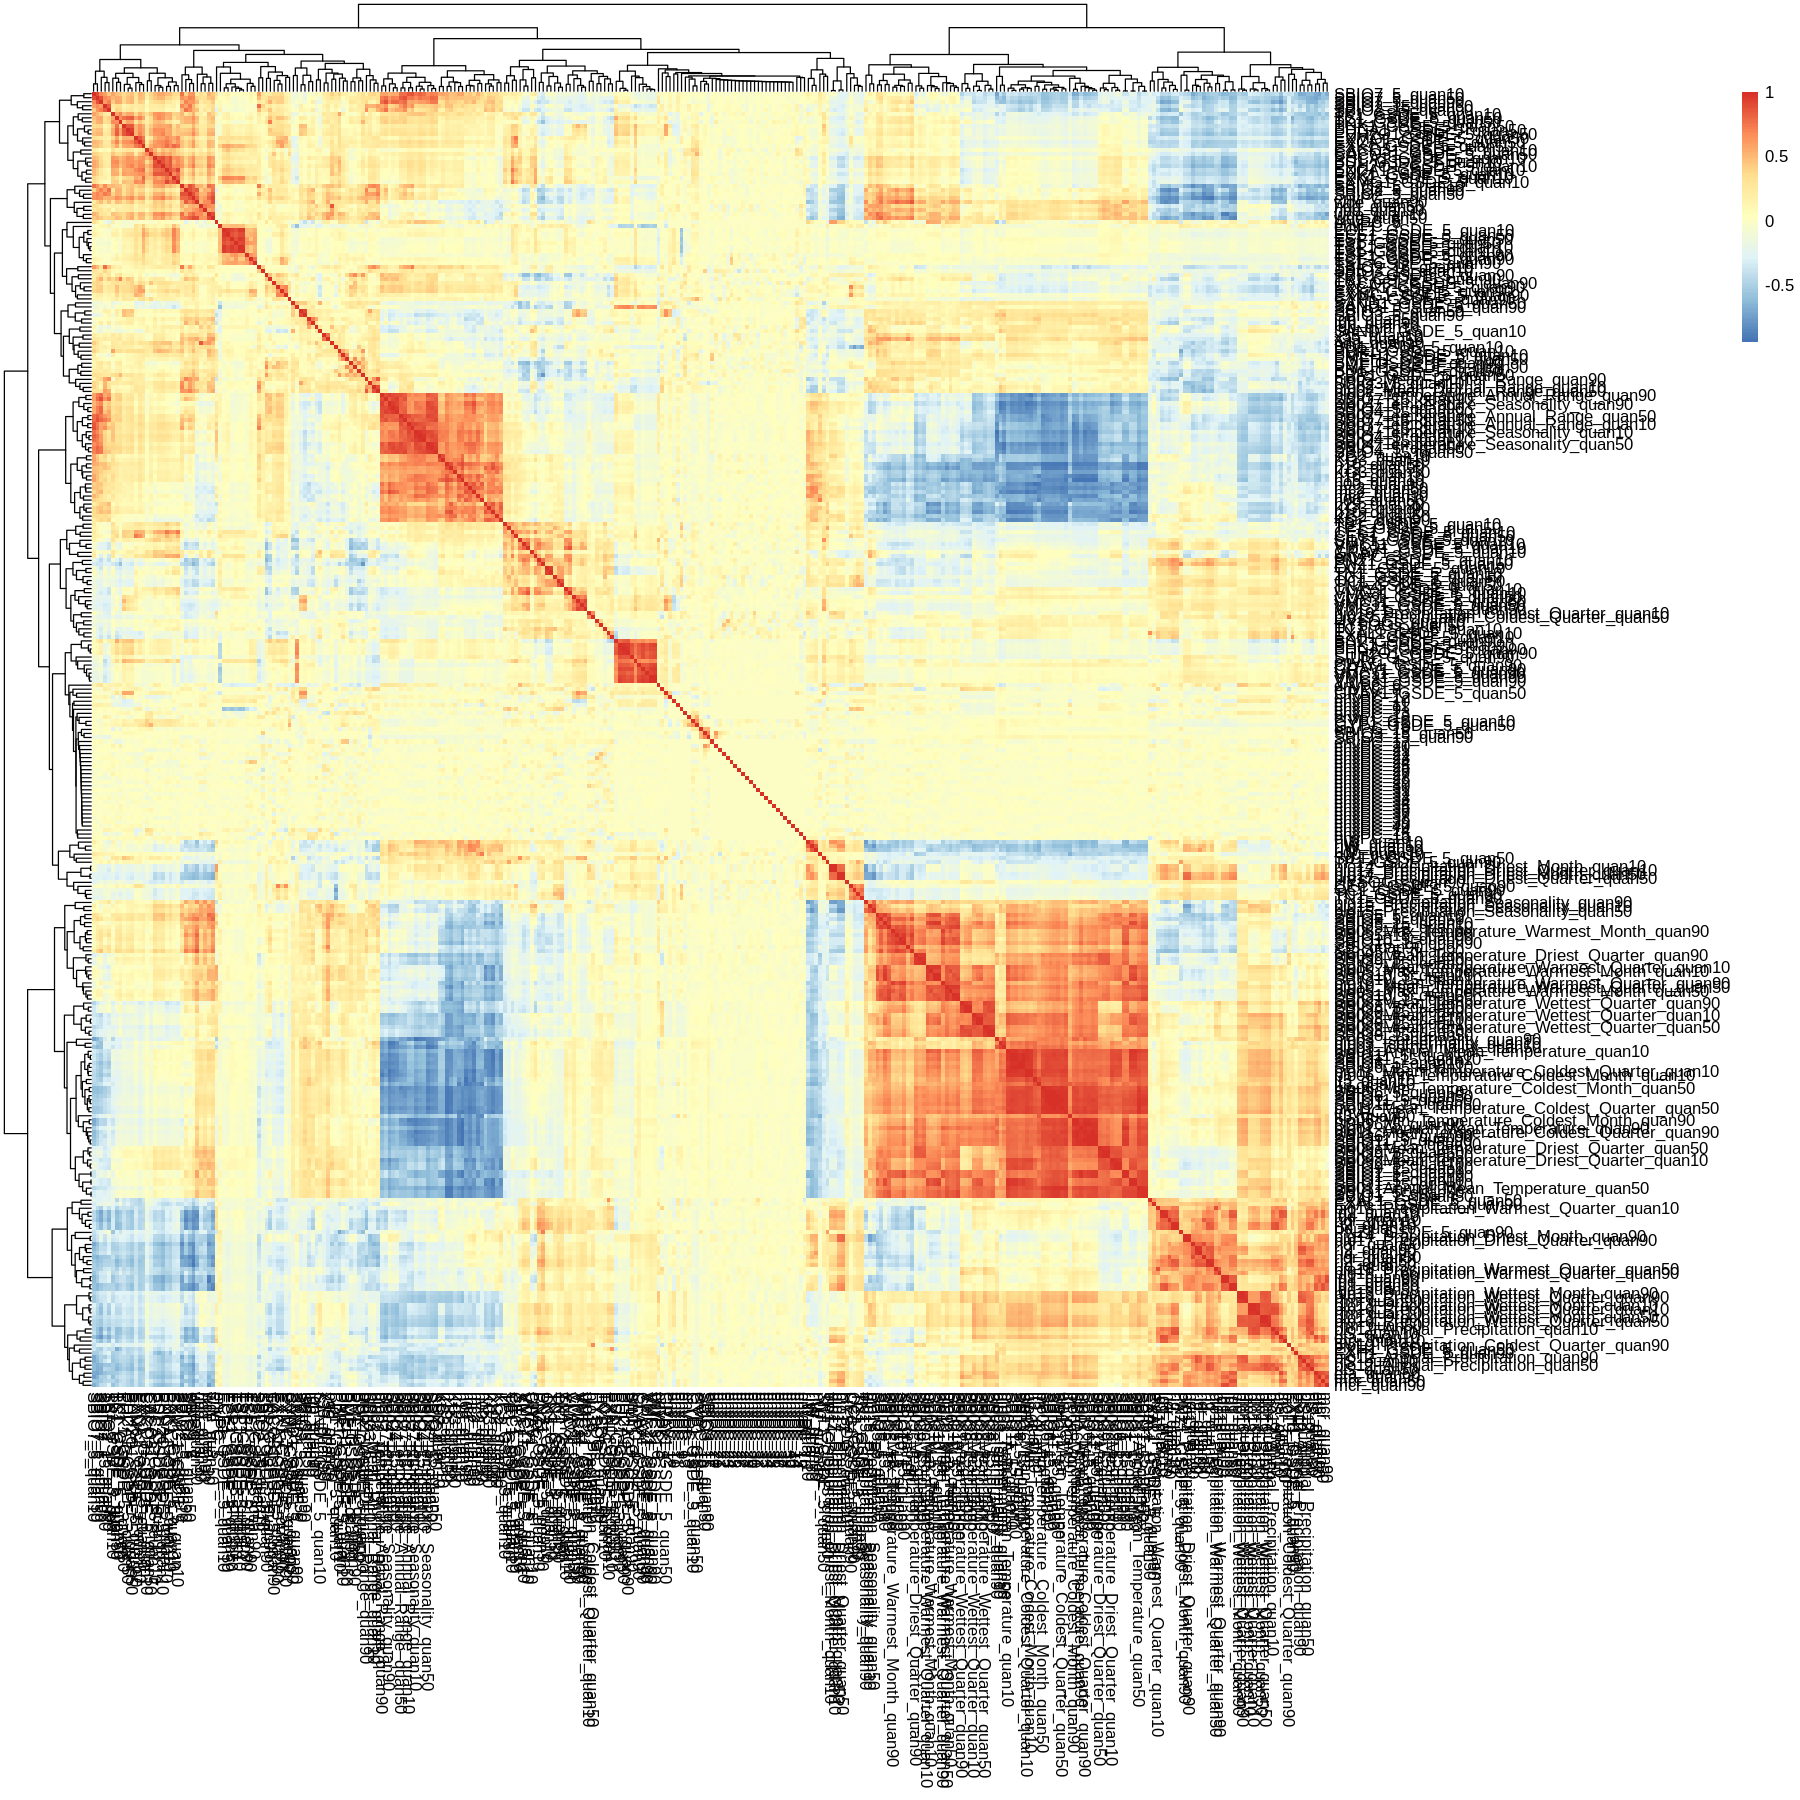

In [363]:
options(repr.plot.width = 15,repr.plot.height = 15)
pheatmap(corMat)

In [367]:
pheatmap(corMat,filename = "/workdir/sh2246/p_phyloGWAS/output/corMat_env.png",width = 30,height = 30,units = "cm",res = 600,border_color = NA,fontsize_row = 6,fontsize_col = 6)

In [369]:
pheatmap(corMat2,filename = "/workdir/sh2246/p_phyloGWAS/output/corMat2_env.png",width = 30,height = 30,units = "cm",res = 600,border_color = NA,fontsize_row = 6,fontsize_col = 6)

In [372]:
annot_labels = data.frame(categories = c(rep(env_metadata[,3],each = 3),rep("envPC",40)))
rownames(annot_labels) = c(paste(rep(env_metadata[,1],each = 3),c("quan10","quan50","quan90"),sep = "_"),paste0("envPC_",1:40))

In [384]:
annot_colors = list(categories = c(combined = "grey", 
                                   envPC = "purple", 
                                   growth = "forestgreen",
                                   precipitation = "cyan",
                                   soil_feature = "peru",
                                   soil_temperature = "salmon",
                                   temperature = "brown"))

In [387]:
pheatmap(corMat2,border_color = NA,fontsize_row = 4,fontsize_col = 4,annotation_row = annot_labels,
         annotation_col = annot_labels,annotation_colors = annot_colors,
         filename = "/workdir/sh2246/p_phyloGWAS/output/corMat2_env_labeled.png",width = 20,height = 20,units = "cm",res = 600)

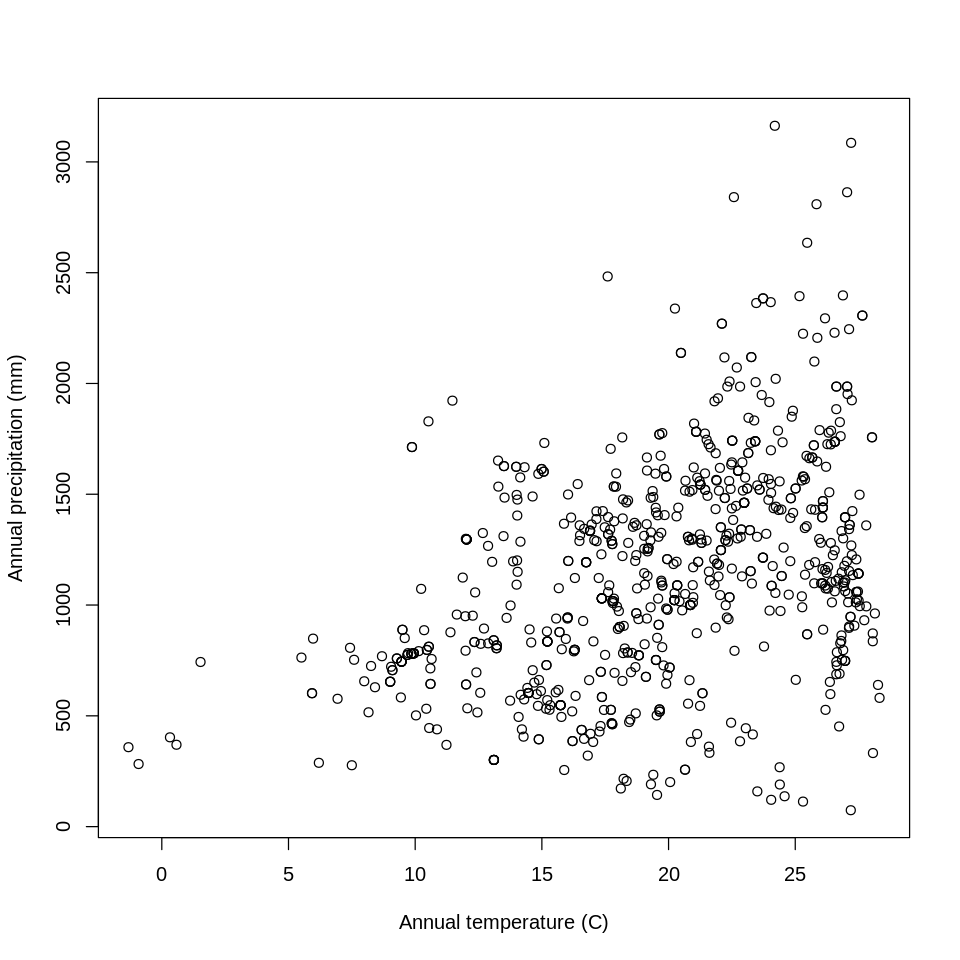

In [389]:
options(repr.plot.width = 8,repr.plot.height = 8)
plot(eTraits_filtered$bio01_Annual_Mean_Temperature_quan50,eTraits_filtered$bio12_Annual_Precipitation_quan50,
     xlab = "Annual temperature (C)",ylab = "Annual precipitation (mm)",pch = 19 ,col = )

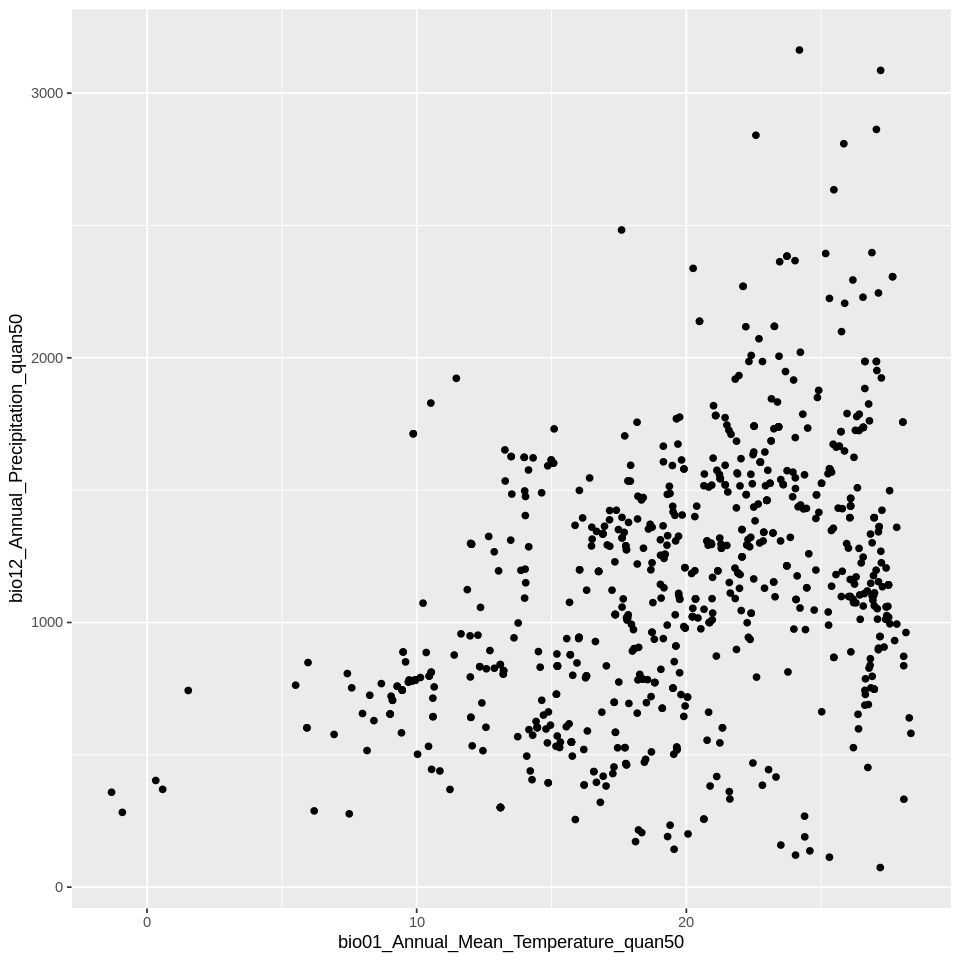

In [414]:
ggplot(eTraits_filtered, aes(x = bio01_Annual_Mean_Temperature_quan50, 
                             y = bio12_Annual_Precipitation_quan50)) +
  geom_point()

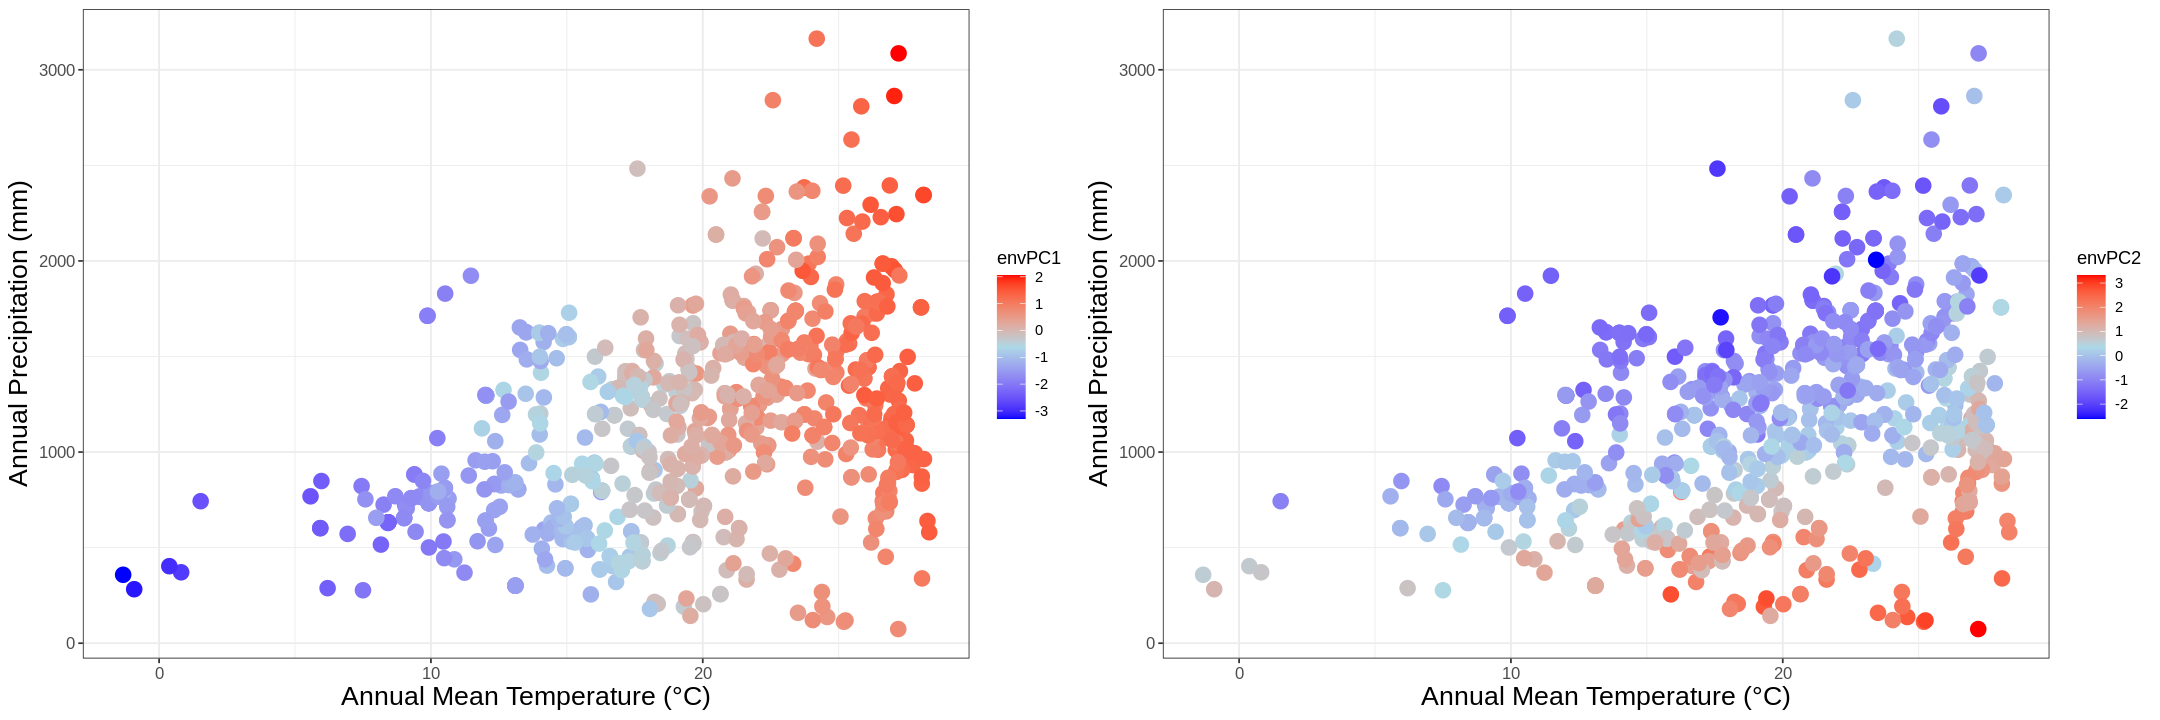

In [314]:
library(gridExtra)
options(repr.plot.width = 18,repr.plot.height = 6)
p1 = ggplot(eTraits_filtered, aes(x = bio01_Annual_Mean_Temperature_quan50, 
                             y = bio12_Annual_Precipitation_quan50, colour = envPC_1)) +
    geom_point(size = 4)+
    xlab("Annual Mean Temperature (\u00B0C)")+
    ylab("Annual Precipitation (mm)")+
    scale_color_gradientn(colors = c("blue","lightblue","red"),name = "envPC1")+
    theme_bw()+
    theme(axis.title = element_text(size = 16),axis.text = element_text(size = 10))
p2 = ggplot(eTraits_filtered, aes(x = bio01_Annual_Mean_Temperature_quan50, 
                             y = bio12_Annual_Precipitation_quan50, colour = envPC_2)) +
    geom_point(size = 4)+
    xlab("Annual Mean Temperature (\u00B0C)")+
    ylab("Annual Precipitation (mm)")+
    scale_color_gradientn(colors = c("blue","lightblue","red"),name = "envPC2")+
    theme_bw()+
    theme(axis.title = element_text(size = 16),axis.text = element_text(size = 10))
grid.arrange(p1, p2, nrow = 1)

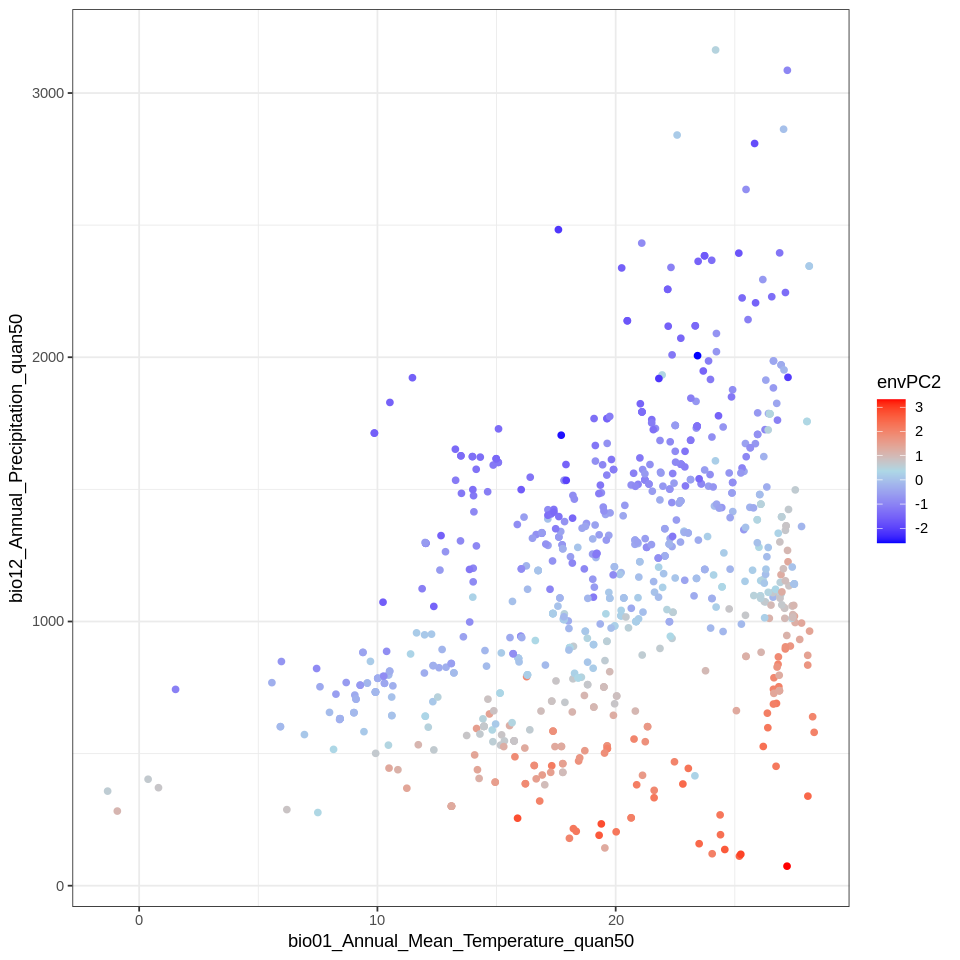

In [295]:
ggplot(eTraits_filtered, aes(x = bio01_Annual_Mean_Temperature_quan50, 
                             y = bio12_Annual_Precipitation_quan50, colour = envPC_2)) +
    geom_point()+
    xlab("Annual Mean Temperature (\u00B0C)")+
    ylab("Annual Precipitation (mm)")+
    scale_color_gradientn(colors = c("blue","lightblue","red"),name = "envPC2")+
    theme_bw()

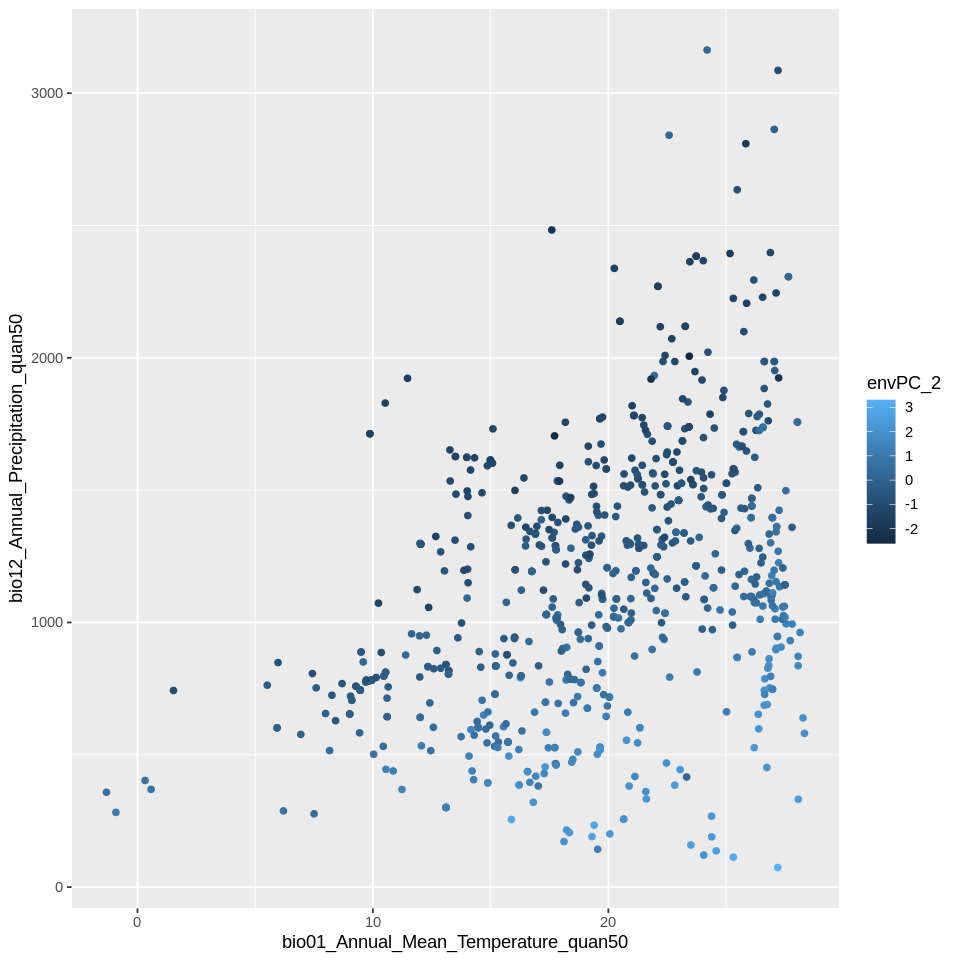

In [399]:
ggplot(eTraits_filtered, aes(x = bio01_Annual_Mean_Temperature_quan50, 
                             y = bio12_Annual_Precipitation_quan50, colour = envPC_2)) +
  geom_point()

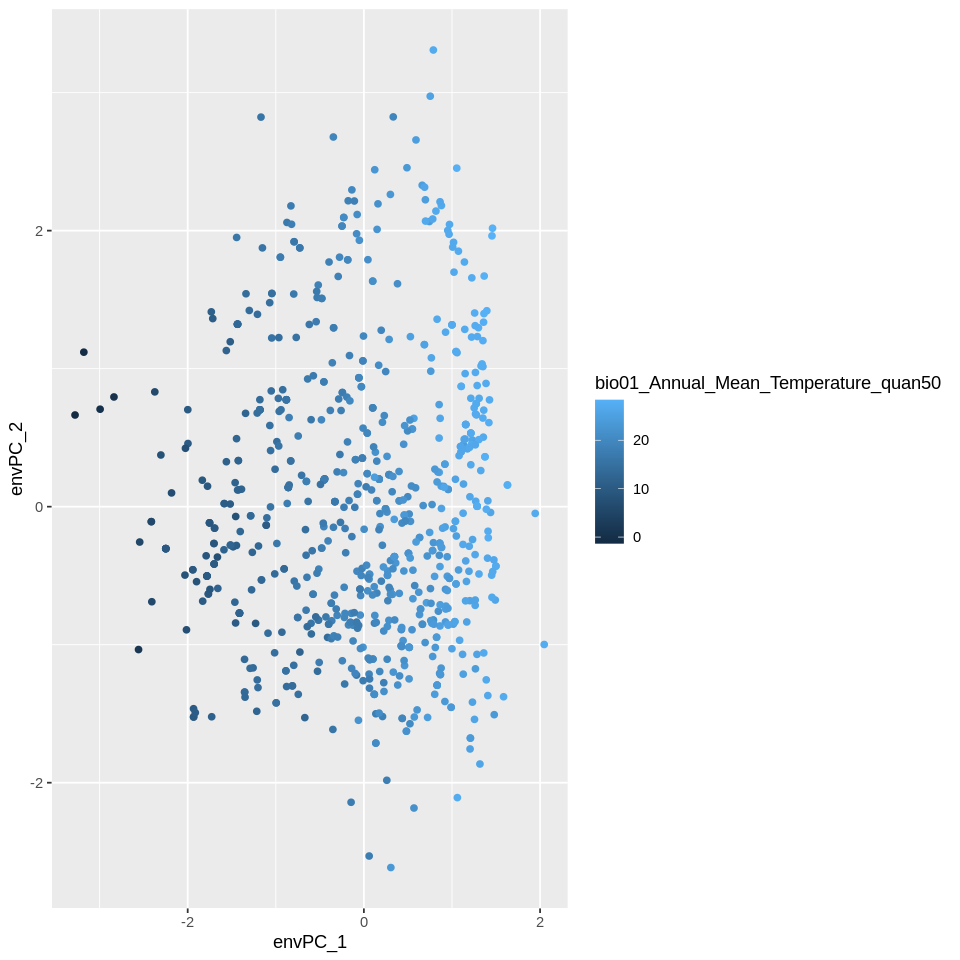

In [394]:
ggplot(eTraits_filtered, aes(x = envPC_1, 
                             y = envPC_2, colour = bio01_Annual_Mean_Temperature_quan50)) +
  geom_point()

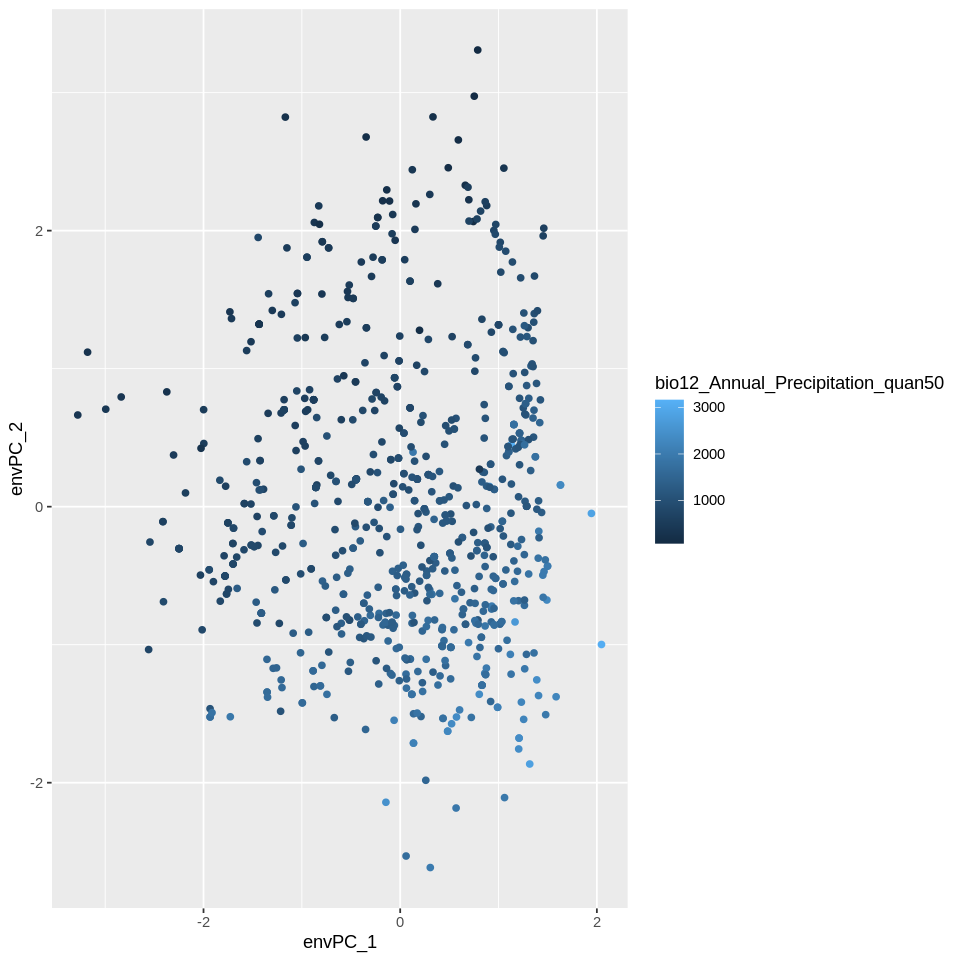

In [395]:
ggplot(eTraits_filtered, aes(x = envPC_1, 
                             y = envPC_2, colour = bio12_Annual_Precipitation_quan50)) +
  geom_point()

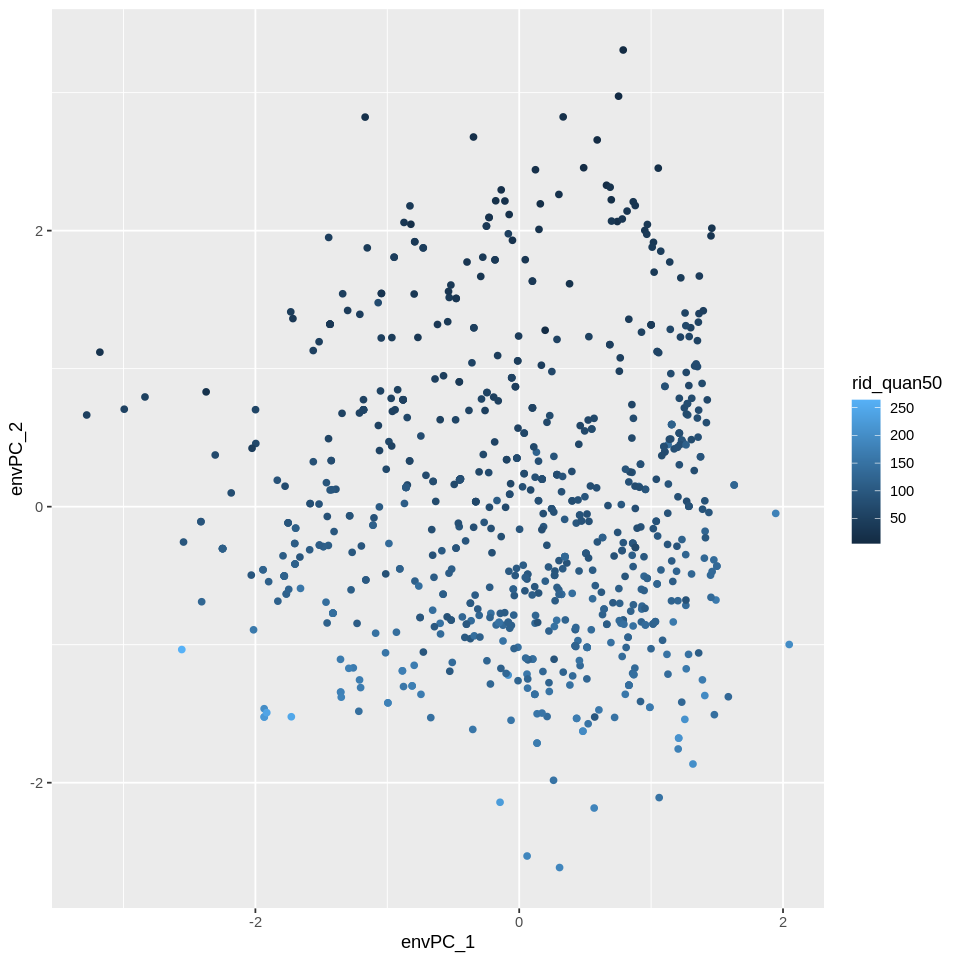

In [397]:
ggplot(eTraits_filtered, aes(x = envPC_1, 
                             y = envPC_2, colour = rid_quan50)) +
  geom_point()

In [295]:
colnames(eTraits_filtered)

[1] "bio01_Annual_Mean_Temperature_quan10"         
  [2] "bio01_Annual_Mean_Temperature_quan50"         
  [3] "bio01_Annual_Mean_Temperature_quan90"         
  [4] "bio10_Mean_Temperature_Warmest_Quarter_quan10"
  [5] "bio10_Mean_Temperature_Warmest_Quarter_quan50"
  [6] "bio10_Mean_Temperature_Warmest_Quarter_quan90"
  [7] "bio11_Mean_Temperature_Coldest_Quarter_quan10"
  [8] "bio11_Mean_Temperature_Coldest_Quarter_quan50"
  [9] "bio11_Mean_Temperature_Coldest_Quarter_quan90"
 [10] "bio12_Annual_Precipitation_quan10"            
 [11] "bio12_Annual_Precipitation_quan50"            
 [12] "bio12_Annual_Precipitation_quan90"            
 [13] "bio13_Precipitation_Wettest_Month_quan10"     
 [14] "bio13_Precipitation_Wettest_Month_quan50"     
 [15] "bio13_Precipitation_Wettest_Month_quan90"     
 [16] "bio14_Precipitation_Driest_Month_quan10"      
 [17] "bio14_Precipitation_Driest_Month_quan50"      
 [18] "bio14_Precipitation_Driest_Month_quan90"      
 [19] "bio15_Precipitation_Seasonality_quan10"       
 [20] "bio15_Precipitation_Seasonality_quan50"       
 [21] "bio15_Precipitation_Seasonality_quan90"       
 [22] "bio16_Precipitation_Wettest_Quarter_quan10"   
 [23] "bio16_Precipitation_Wettest_Quarter_quan50"   
 [24] "bio16_Precipitation_Wettest_Quarter_quan90"   
 [25] "bio17_Precipitation_Driest_Quarter_quan10"    
 [26] "bio17_Precipitation_Driest_Quarter_quan50"    
 [27] "bio17_Precipitation_Driest_Quarter_quan90"    
 [28] "bio18_Precipitation_Warmest_Quarter_quan10"   
 [29] "bio18_Precipitation_Warmest_Quarter_quan50"   
 [30] "bio18_Precipitation_Warmest_Quarter_quan90"   
 [31] "bio19_Precipitation_Coldest_Quarter_quan10"   
 [32] "bio19_Precipitation_Coldest_Quarter_quan50"   
 [33] "bio19_Precipitation_Coldest_Quarter_quan90"   
 [34] "bio02_Mean_Diurnal_Range_quan10"              
 [35] "bio02_Mean_Diurnal_Range_quan50"              
 [36] "bio02_Mean_Diurnal_Range_quan90"              
 [37] "bio03_Isothermality_quan10"                   
 [38] "bio03_Isothermality_quan50"                   
 [39] "bio03_Isothermality_quan90"                   
 [40] "bio04_Temperature_Seasonality_quan10"         
 [41] "bio04_Temperature_Seasonality_quan50"         
 [42] "bio04_Temperature_Seasonality_quan90"         
 [43] "bio05_Max_Temperature_Warmest_Month_quan10"   
 [44] "bio05_Max_Temperature_Warmest_Month_quan50"   
 [45] "bio05_Max_Temperature_Warmest_Month_quan90"   
 [46] "bio06_Min_Temperature_Coldest_Month_quan10"   
 [47] "bio06_Min_Temperature_Coldest_Month_quan50"   
 [48] "bio06_Min_Temperature_Coldest_Month_quan90"   
 [49] "bio07_Temperature_Annual_Range_quan10"        
 [50] "bio07_Temperature_Annual_Range_quan50"        
 [51] "bio07_Temperature_Annual_Range_quan90"        
 [52] "bio08_Mean_Temperature_Wettest_Quarter_quan10"
 [53] "bio08_Mean_Temperature_Wettest_Quarter_quan50"
 [54] "bio08_Mean_Temperature_Wettest_Quarter_quan90"
 [55] "bio09_Mean_Temperature_Driest_Quarter_quan10" 
 [56] "bio09_Mean_Temperature_Driest_Quarter_quan50" 
 [57] "bio09_Mean_Temperature_Driest_Quarter_quan90" 
 [58] "HYSOGs_quan10"                                
 [59] "HYSOGs_quan50"                                
 [60] "HYSOGs_quan90"                                
 [61] "eta_quan10"                                   
 [62] "eta_quan50"                                   
 [63] "eta_quan90"                                   
 [64] "KG2_quan10"                                   
 [65] "KG2_quan50"                                   
 [66] "KG2_quan90"                                   
 [67] "KG3_quan10"                                   
 [68] "KG3_quan50"                                   
 [69] "KG3_quan90"                                   
 [70] "ld1_quan10"                                   
 [71] "ld1_quan50"                                   
 [72] "ld1_quan90"                                   
 [73] "lgb_quan10"                                   
 [74] "lgb_quan50"                                   
 [75] 

In [201]:
tmp$estimate

cor 
0.05590863

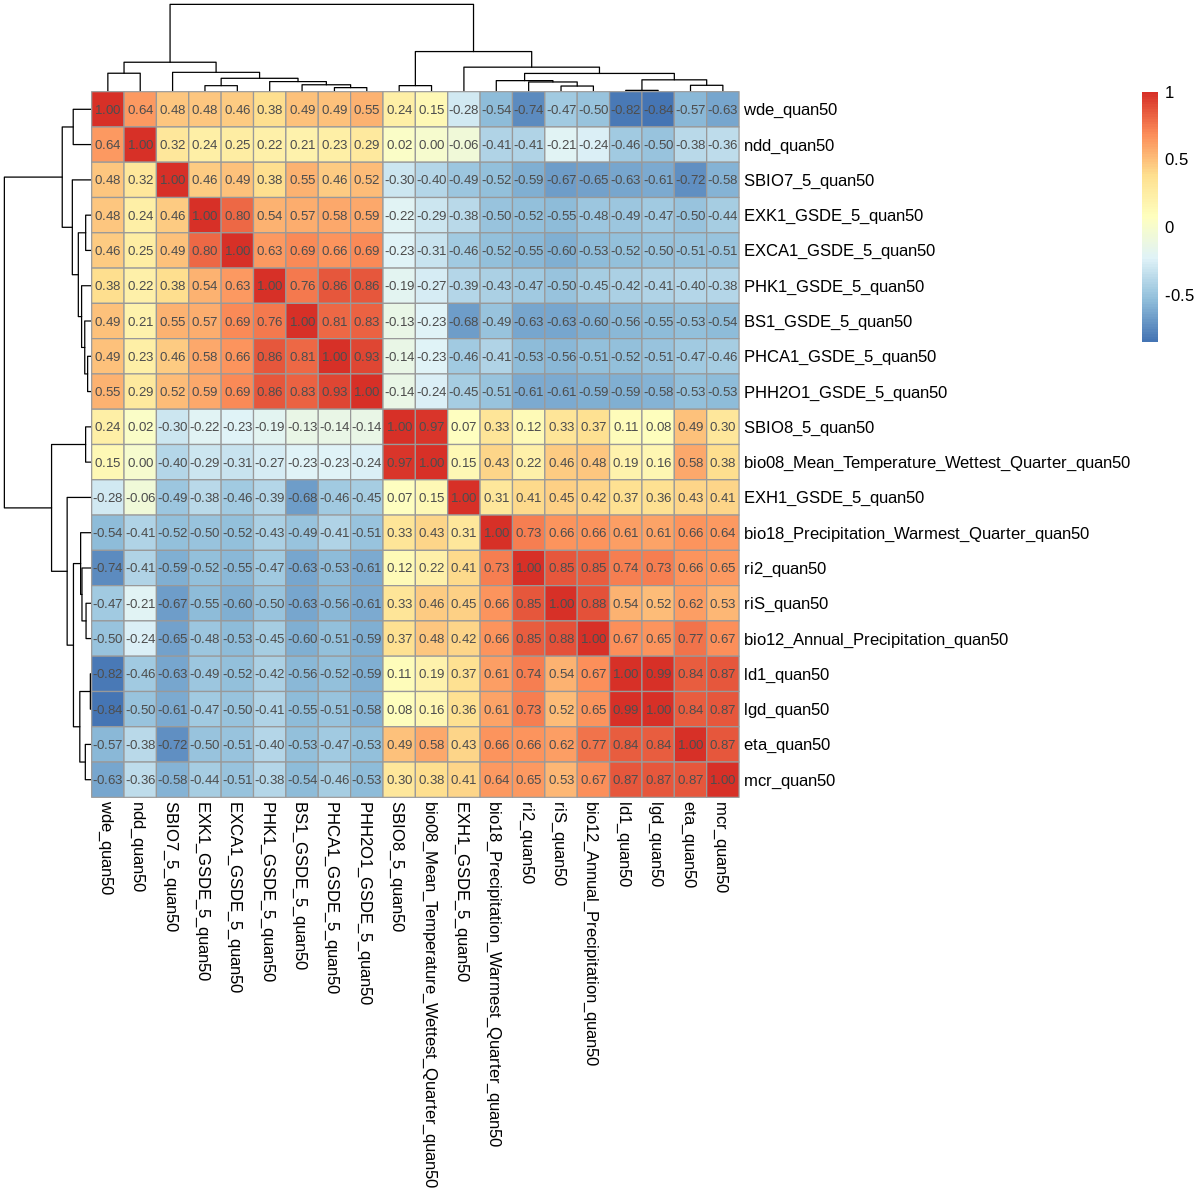

In [236]:
pheatmap(cor(eTraits_filtered[,paste0(names(tail(sort(corRes[,1]^2),20)),"_quan50")],use = "complete"),
         display_numbers = T,cluster_rows = T,cluster_cols = T)

Warning message in eval(predvars, data, env):
“NAs introduced by coercion”
Warning message in eval(predvars, data, env):
“NAs introduced by coercion”


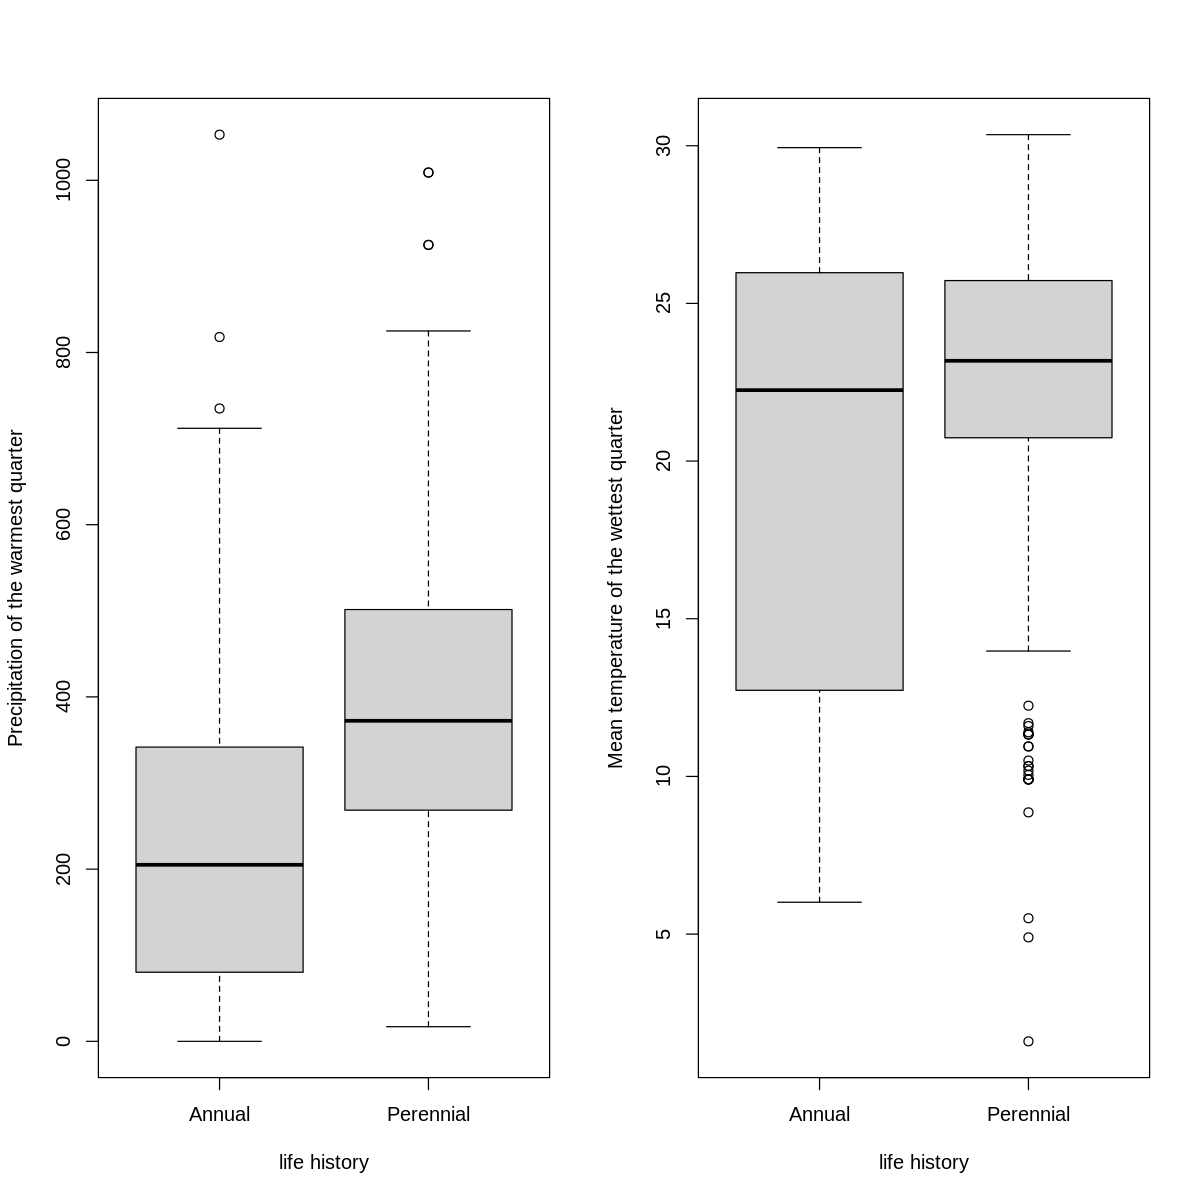

In [247]:
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow = c(1,2))
boxplot(eTraits_filtered[commonID2,]$bio18_Precipitation_Warmest_Quarter_quan50~as.numeric(traitMat[commonID2,2]),
        names = c("Annual","Perennial"),xlab = "life history",ylab = "Precipitation of the warmest quarter")
boxplot(eTraits_filtered[commonID2,]$bio08_Mean_Temperature_Wettest_Quarter_quan50~as.numeric(traitMat[commonID2,2]),
        names = c("Annual","Perennial"),xlab = "life history",ylab = "Mean temperature of the wettest quarter")


In [124]:
table(as.numeric(traitMat[,2]))

Warning message in table(as.numeric(traitMat[, 2])):
“NAs introduced by coercion”



  1   2 
241 487 

In [260]:
testFile = data.table::fread("/workdir/sh2246/p_phyloGWAS/data/allOGs_withHeaders_dnds.txt",header = F,sep = "\t")

Warning message in data.table::fread("/workdir/sh2246/p_phyloGWAS/data/allOGs_withHeaders_dnds.txt", :
“Previous fread() session was not cleaned up properly. Cleaned up ok at the beginning of this fread() call.”


In [261]:
head(testFile)

V1                       V2                                   V3  V4  V5 V6
1 OG0000508:ASM1935983v1:0 OG0000508:10wheat_assembly_jagger:0  347 343  4  4
2 OG0000508:ASM1935983v1:0 OG0000508:10wheat_assembly_jagger:1  347 343  4  4
3 OG0000508:ASM1935983v1:0 OG0000508:10wheat_assembly_lancer:0  347 343  4  4
4 OG0000508:ASM1935983v1:0 OG0000508:10wheat_assembly_stanley:0 347 343  4  4
5 OG0000508:ASM1935983v1:0 OG0000508:10wheat_assembly_stanley:1 347 343  4  4
6 OG0000508:ASM1935983v1:0 OG0000508:4AgS:0                     347 336 11 11
  V7 V8        V9       V10      V11      V12       V13        V14      
1 0  116.50000 53.50000 243.1667 785.8333 0.4790953 0.06808059 0.1421024
2 0  118.50000 56.50000 243.8333 785.1667 0.4859877 0.07195924 0.1480680
3 0  117.50000 55.50000 243.5000 785.5000 0.4825462 0.07065563 0.1464225
4 0  116.50000 53.50000 243.1667 785.8333 0.4790953 0.06808059 0.1421024
5 0  117.50000 55.50000 243.5000 785.5000 0.4825462 0.07065563 0.1464225
6 0   77.33333 98.66667 128.8333 879.1667 0.6002587 0.11222749 0.1869652
  V15       V16        V17        V18      
1 0.7637295 0.07137130 0.09345101 0.9942363
2 0.7830581 0.07564936 0.09660759 0.9942363
3 0.7733448 0.07420878 0.09595821 0.9942363
4 0.7637295 0.07137130 0.09345101 0.9942363
5 0.7733448 0.07420878 0.09595821 0.9942363
6 1.2083732 0.12156866 0.10060523 0.5331412

In [262]:
hist(table(strsplit2(testFile[,1],":")[,1]))

In [265]:
numSeqPerOG = read.table("/workdir/sh2246/p_phyloGWAS/output/numSeq_allOG.txt",header = T)

In [267]:
dim(numSeqPerOG)

[1] 17886     2

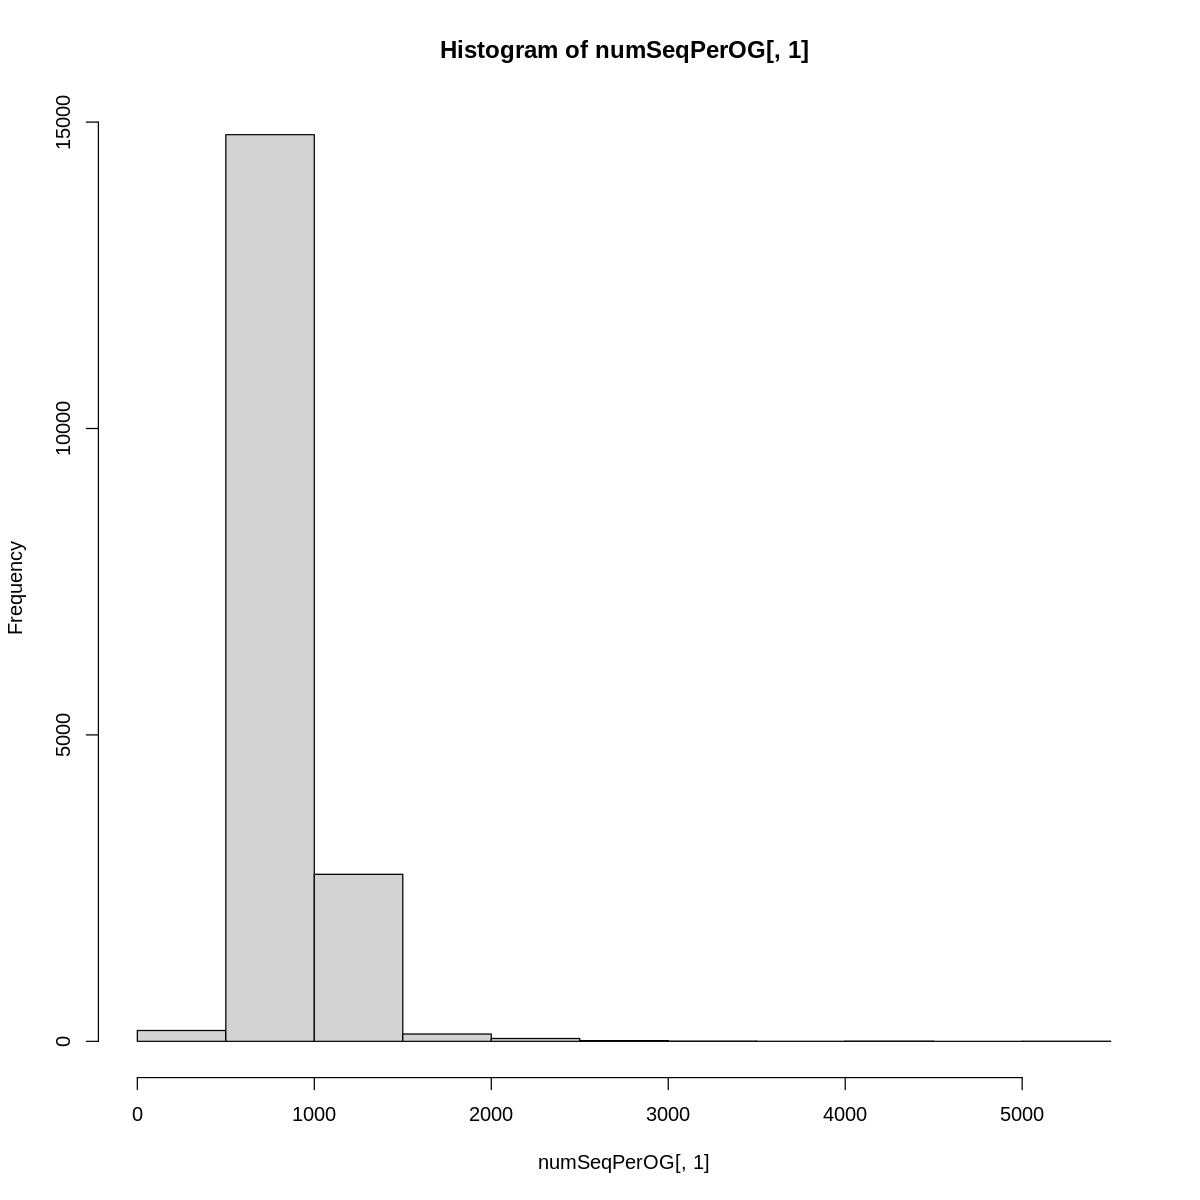

In [269]:
hist(numSeqPerOG[,1])

In [282]:
numTaxaPerOG = read.table("/workdir/sh2246/p_phyloGWAS/output/numTaxa_allOG.txt",header = F)

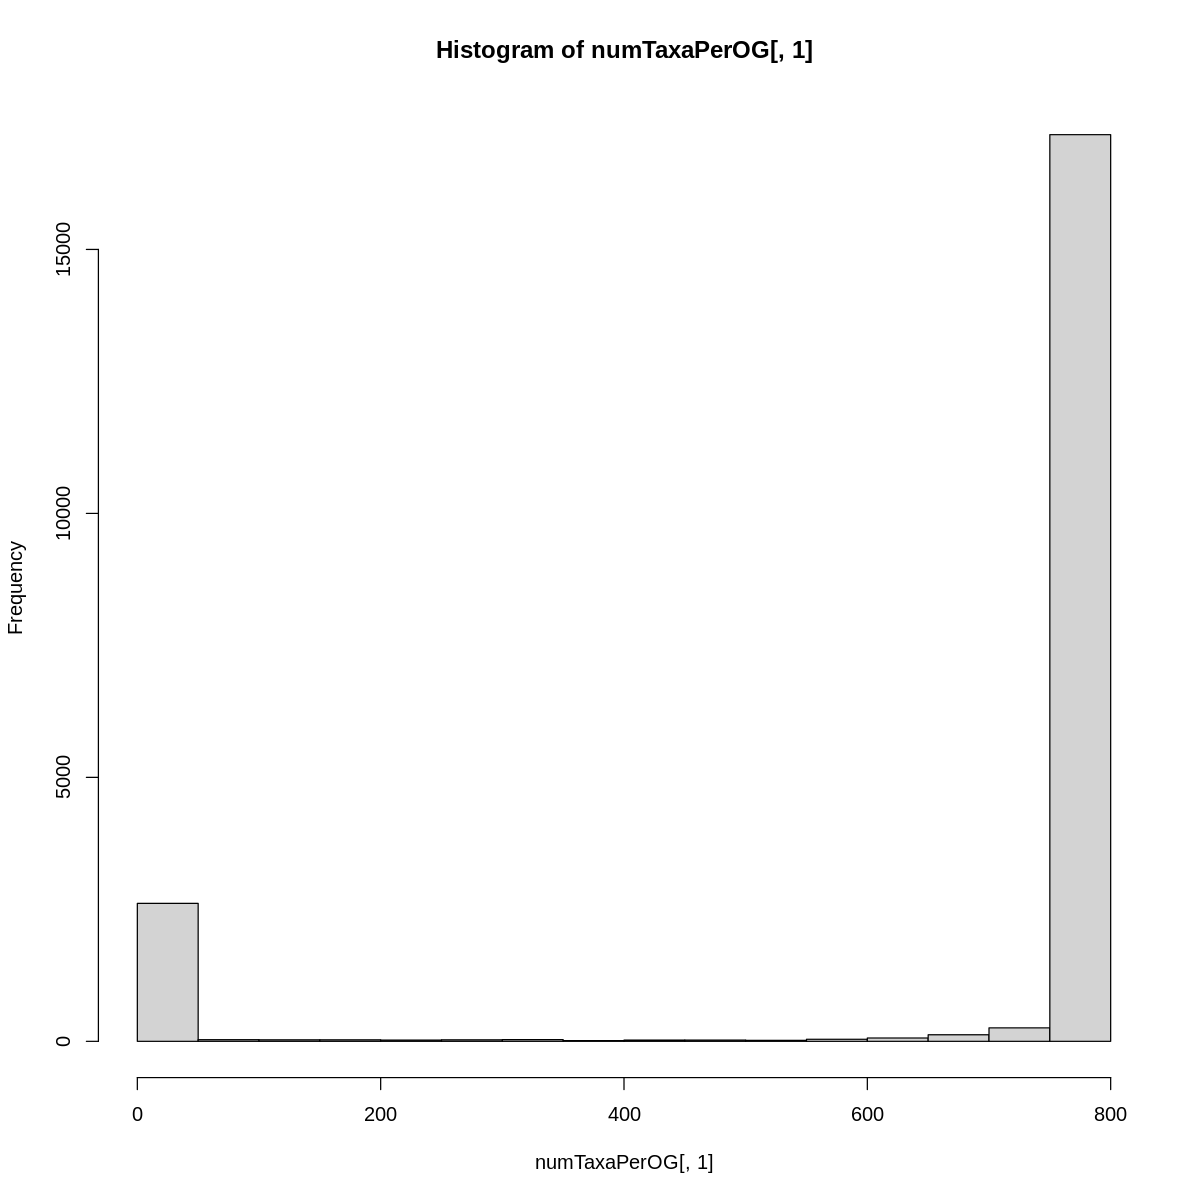

In [289]:
hist(numTaxaPerOG[,1],breaks = seq(0,800,50))

In [288]:
table(grepl("_R",numTaxaPerOG[numTaxaPerOG[,1]<50,2]))


FALSE  TRUE 
   34  2574 

In [291]:
numTaxaPerOG[numTaxaPerOG[,1]<50,]

V1 V2          
7760  12 OG0011273   
9857   6 OG0013549   
12291  8 OG0016209   
14359 37 OG0018584   
14616 16 OG0018913   
14816  7 OG0019169   
15130 19 OG0019703   
15357  8 OG0020214   
15384 12 OG0020251   
15401  3 OG0020320   
15556  2 OG0020627   
15579 23 OG0020664   
15624 47 OG0020790   
15728 14 OG0021048   
15844  6 OG0021356   
15909 42 OG0021463   
16140 12 OG0022154   
16146  2 OG0022166   
16251 11 OG0022451   
16443  7 OG0023021   
16484  2 OG0023091   
16485 33 OG0023092   
16773 28 OG0024136   
16930 34 OG0024725   
16941  4 OG0024749   
16952 12 OG0024766   
16960  5 OG0024781   
16969 18 OG0024825   
17190 43 OG0025886   
17352 41 OG0026709   
⋮     ⋮  ⋮           
20486  4 _R_OG0029898
20487  2 _R_OG0029899
20488  5 _R_OG0029910
20489  3 _R_OG0029926
20490  1 _R_OG0029966
20491 20 _R_OG0030010
20492  6 _R_OG0030093
20494 25 _R_OG0030163
20495  1 _R_OG0030396
20497  1 _R_OG0030611
20498  1 _R_OG0030622
20499 18 _R_OG0030668
20500  1 _R_OG0030673
20501  1 _R_OG0030824
20503  1 _R_OG0031384
20504  1 _R_OG0031409
20505  1 _R_OG0031429
20506  1 _R_OG0031457
20507  1 _R_OG0031522
20508  2 _R_OG0031638
20509 11 _R_OG0031782
20510  3 _R_OG0031809
20511  2 _R_OG0032119
20512  1 _R_OG0032221
20513  1 _R_OG0032319
20514  4 _R_OG0032380
20515  1 _R_OG0032433
20516  7 _R_OG0033554
20517  3 _R_OG0033814
20518  2 _R_OG0034047

In [86]:
setdiff(spTre.rooted$tip.label,rownames(ePCs$environmental.features))
length(setdiff(spTre.rooted$tip.label,rownames(ePCs$environmental.features)))

[1] "SRR23019235"                      "MCRTL028"                        
 [3] "AN21TSTL0183"                     "AN21TNTL0173"                    
 [5] "ASM3693692v1"                     "AN21TS37"                        
 [7] "AN21TS05"                         "MCRTL024"                        
 [9] "Zh-RIMHU001-REFERENCE-PanAnd-1.0" "Tz-DC_05_58_3A-DRAFT-PanAnd-1.0" 
[11] "AN21TSTL0206"                     "AN21TS44"                        
[13] "AN21TNTL0176"                     "AN21TS41"                        
[15] "AN21TNTL0138"                     "AN21TNTL0139"                    
[17] "AN22TNTL036"                      "AN22TSTL001"                     
[19] "AN21TSTL0205"                     "SRR20072574"                     
[21] "AN21TNTL0362"                     "AN21TNTL0178"                    
[23] "AN22TNTL165"                      "AN20T193"                        
[25] "AN22TNTL031"                      "AT20TS1MCRTL004"                 
[27] "AN22TNTL150"                      "AN21TSTL0215"                    
[29] "AN21TSTL0279"                     "AN21TSTL0036"                    
[31] "MCRTL047"                         "AN22TNTL117"                     
[33] "AN20T004"                         "AN21TS39"                        
[35] "MCRTL045"                         "AN20T021"                        
[37] "AN20T169"                         "AN21TSTL0186"                    
[39] "AN21TSTL0250"                     "AN22TNTL113"                     
[41] "AN22TNTL122"                      "Oryza_malampuzhaensis"           
[43] "SRR18907695"

[1] 43

In [62]:
setdiff(spTre.rooted$tip.label,rownames(ePCs$environmental.features))

[1] "SRR23019235"                          
 [2] "MCRTL028"                             
 [3] "AN21TSTL0183"                         
 [4] "AN21TNTL0173"                         
 [5] "ASM3693692v1"                         
 [6] "AN21TS37"                             
 [7] "Rt-Layton_Zhong169-DRAFT-PanAnd-1.0"  
 [8] "A1015002"                             
 [9] "Hp-KelloggPI404118-DRAFT-PanAnd-1.0"  
[10] "AN21TS05"                             
[11] "Et-Layton_Zhong168-DRAFT-PanAnd-1.0"  
[12] "MCRTL024"                             
[13] "Zv-TIL01-REFERENCE-PanAnd-1.0"        
[14] "Zv-TIL11-REFERENCE-PanAnd-1.0"        
[15] "Zh-RIMHU001-REFERENCE-PanAnd-1.0"     
[16] "Tz-DC_05_58_3A-DRAFT-PanAnd-1.0"      
[17] "AN21TSTL0206"                         
[18] "Td-FL_9056069_6-REFERENCE-PanAnd-2.0b"
[19] "Td-FL_9056069_6-REFERENCE-PanAnd-2.0a"
[20] "Td-KS_B6_1-REFERENCE-PanAnd-2.0b"     
[21] "Td-KS_B6_1-REFERENCE-PanAnd-2.0a"     
[22] "Td-McKain334_5-DRAFT-PanAnd-1.0"      
[23] "Rr-Malcomber3106-DRAFT-PanAnd-1.0"    
[24] "Vc-Pasquet1098-DRAFT-PanAnd-1.0"      
[25] "A1077002"                             
[26] "Ud-Pasquet1171-DRAFT-PanAnd-1.0"      
[27] "A1076001"                             
[28] "A1014002"                             
[29] "ChrysopogonNigritanus_v1.0"           
[30] "Te-Pasquet1246-DRAFT-PanAnd-1.0"      
[31] "AN21TS44"                             
[32] "Ab-Traiperm_572-DRAFT-PanAnd-1.0"     
[33] "AN21TNTL0176"                         
[34] "Sn-CAM1369-DRAFT-PanAnd-1.0"          
[35] "AN21TS41"                             
[36] "A1030002"                             
[37] "Ir-Pasquet1136-DRAFT-PanAnd-1.0"      
[38] "AN21TNTL0138"                         
[39] "AN21TNTL0139"                         
[40] "AN22TNTL036"                          
[41] "AN22TSTL001"                          
[42] "AN21TSTL0205"                         
[43] "SRR20072574"                          
[44] "A1031001"                             
[45] "A1033002"                             
[46] "AN21TNTL0362"                         
[47] "AN21TNTL0178"                         
[48] "AN22TNTL165"                          
[49] "AN20T025"                             
[50] "AN20T023"                             
[51] "AN20T024"                             
[52] "AN20T193"                             
[53] "AN22TNTL031"                          
[54] "Pi-Clark-DRAFT-PanAnd-1.0"            
[55] "A1063002"                             
[56] "AT20TS1MCRTL004"                      
[57] "AN22TNTL150"                          
[58] "AN21TSTL0215"                         
[59] "Bl-K1279B-DRAFT-PanAnd-1.0"           
[60] "AN21TSTL0279"                         
[61] "A1020001"                             
[62] "A1021002"                             
[63] "A1010002"                             
[64] "AN21TSTL0036"                         
[65] "Cr-AUB069-DRAFT-PanAnd-1.0"           
[66] "MCRTL047"                             
[67] "AN22TNTL117"                          
[68] "AN20T004"                             
[69] "AN21TS39"                             
[70] "Av-Kellogg1287_8-REFERENCE-PanAnd-1.0"
[71] "MCRTL045"                             
[72] "AN20T021"                             
[73] "AN20T169"                             
[74] "AN21TSTL0186"                         
[75] "Ss-CAM1384-DRAFT-PanAnd-1.0"          
[76] "AN21TSTL0250"                         
[77] "AN22TNTL113"                          
[78] "Ac-Pasquet1232-DRAFT-PanAnd-1.0"      
[79] "Ag-CAM1351-DRAFT-PanAnd-1.0"          
[80] "AN22TNTL122"                          
[81] "Oryza_malampuzhaensis"                
[82] "SRR18907695"

In [64]:
metadata3 = metadata[metadata[,1]%in%setdiff(spTre.rooted$tip.label,rownames(ePCs$environmental.features)),]

In [66]:
metadata3 = metadata3[!metadata3[,2]%in%c("Unknown","Omit","Hyparrhenia sp.","Andropogon sp."),]

assemblyID                            latest_name                       
36  MCRTL045                              "Andropogon" appendiculatus       
39  AN22TNTL031                           Andropogon aridus                 
45  AN22TNTL113                           "Andropogon" brazzae              
46  Ab-Traiperm_572-DRAFT-PanAnd-1.0      Andropogon burmanicus             
50  Ac-Pasquet1232-DRAFT-PanAnd-1.0       Andropogon chinensis              
56  AN22TNTL122                           "Andropogon" durifolius           
57  AN20T169                              Anatherum eucomum subsp. huillense
58  AN20T021                              Anatherum eucomum subsp. huillense
64  Ag-CAM1351-DRAFT-PanAnd-1.0           Andropogon gerardii               
85  MCRTL047                              Cymbopogon lividius               
88  AN22TNTL117                           "Andropogon" mannii               
99  AN21TSTL0186                          Anatherum arctatum                
105 Av-Kellogg1287_8-REFERENCE-PanAnd-1.0 Anatherum virginicum              
138 SRR23019235                           Avena occidentalis                
148 SRR18907695                           Bambusa grandis                   
160 AN21TSTL0279                          Bothriochloa grahamii             
166 A1010002                              Bothriochloa insculpta            
168 Bl-K1279B-DRAFT-PanAnd-1.0            Bothriochloa laguroides           
197 ASM3693692v1                          Cenchrus fungigraminus            
213 ChrysopogonNigritanus_v1.0            Chrysopogon nigritanus            
220 A1014002                              Chrysopogon zizanioides           
224 A1015002                              Coelorachis tuberculosa           
250 Cr-AUB069-DRAFT-PanAnd-1.0            Cymbopogon refractus              
261 A1020001                              Dichanthium annulatum             
265 AT20TS1MCRTL004                       Eremopogon foveolatum             
280 AN21TNTL0139                          Dimeria aristata                  
283 AN22TNTL036                           Dimeria mooneyi                   
307 A1021002                              Elionurus tripsacoides            
308 Et-Layton_Zhong168-DRAFT-PanAnd-1.0   Elionurus tripsacoides            
348 Hp-KelloggPI404118-DRAFT-PanAnd-1.0   Hemarthria compressa              
⋮   ⋮                                     ⋮                                 
438 AN20T025                              Lasiorhachis viguieri             
456 A1031001                              Miscanthus ecklonii               
459 A1033002                              Miscanthus junceus                
497 Oryza_malampuzhaensis                 Oryza malampuzhaensis             
552 A1063002                              Pogonatherum paniceum             
553 Pi-Clark-DRAFT-PanAnd-1.0             Pogonatherum paniceum             
569 Rr-Malcomber3106-DRAFT-PanAnd-1.0     Rhytachne rottboellioides         
582 Rt-Layton_Zhong169-DRAFT-PanAnd-1.0   Rottboellia tuberculosa           
593 SRR20072574                           Saccharum fulvum                  
597 AN20T024                              Lasiorhachis hildebrandtii        
609 AN21TNTL0362                          Saccharum strictum                
647 Ss-CAM1384-DRAFT-PanAnd-1.0           Schizachyrium scoparium           
672 Sn-CAM1369-DRAFT-PanAnd-1.0           Sorghastrum nutans                
680 AN21TSTL0215                          Bothriochloa woodrovii            
688 AN22TNTL165                           Sorghum controversum              
714 Te-Pasquet1246-DRAFT-PanAnd-1.0       Thelepogon elegans                
736 AN21TSTL0206                          Tripsacum cundinamarce            
737 Td-McKain334_5-DRAFT-PanAnd-1.0       Tripsacum dactyloides             
738 Td-FL_9056069_6-REFERENCE-PanAnd-2.0a Tripsacum dactyloides             
739 Td-FL_9056069_6-REFERENCE-PanAnd-2.0b Tripsacum dactyloides             


In [72]:
metadata3[,2] = gsub("\"","", metadata3[,2])
metadata3

assemblyID                            latest_name                       
36  MCRTL045                              Andropogon appendiculatus         
39  AN22TNTL031                           Andropogon aridus                 
45  AN22TNTL113                           Andropogon brazzae                
46  Ab-Traiperm_572-DRAFT-PanAnd-1.0      Andropogon burmanicus             
50  Ac-Pasquet1232-DRAFT-PanAnd-1.0       Andropogon chinensis              
56  AN22TNTL122                           Andropogon durifolius             
57  AN20T169                              Anatherum eucomum subsp. huillense
58  AN20T021                              Anatherum eucomum subsp. huillense
64  Ag-CAM1351-DRAFT-PanAnd-1.0           Andropogon gerardii               
85  MCRTL047                              Cymbopogon lividius               
88  AN22TNTL117                           Andropogon mannii                 
99  AN21TSTL0186                          Anatherum arctatum                
105 Av-Kellogg1287_8-REFERENCE-PanAnd-1.0 Anatherum virginicum              
138 SRR23019235                           Avena occidentalis                
148 SRR18907695                           Bambusa grandis                   
160 AN21TSTL0279                          Bothriochloa grahamii             
166 A1010002                              Bothriochloa insculpta            
168 Bl-K1279B-DRAFT-PanAnd-1.0            Bothriochloa laguroides           
197 ASM3693692v1                          Cenchrus fungigraminus            
213 ChrysopogonNigritanus_v1.0            Chrysopogon nigritanus            
220 A1014002                              Chrysopogon zizanioides           
224 A1015002                              Coelorachis tuberculosa           
250 Cr-AUB069-DRAFT-PanAnd-1.0            Cymbopogon refractus              
261 A1020001                              Dichanthium annulatum             
265 AT20TS1MCRTL004                       Eremopogon foveolatum             
280 AN21TNTL0139                          Dimeria aristata                  
283 AN22TNTL036                           Dimeria mooneyi                   
307 A1021002                              Elionurus tripsacoides            
308 Et-Layton_Zhong168-DRAFT-PanAnd-1.0   Elionurus tripsacoides            
348 Hp-KelloggPI404118-DRAFT-PanAnd-1.0   Hemarthria compressa              
⋮   ⋮                                     ⋮                                 
438 AN20T025                              Lasiorhachis viguieri             
456 A1031001                              Miscanthus ecklonii               
459 A1033002                              Miscanthus junceus                
497 Oryza_malampuzhaensis                 Oryza malampuzhaensis             
552 A1063002                              Pogonatherum paniceum             
553 Pi-Clark-DRAFT-PanAnd-1.0             Pogonatherum paniceum             
569 Rr-Malcomber3106-DRAFT-PanAnd-1.0     Rhytachne rottboellioides         
582 Rt-Layton_Zhong169-DRAFT-PanAnd-1.0   Rottboellia tuberculosa           
593 SRR20072574                           Saccharum fulvum                  
597 AN20T024                              Lasiorhachis hildebrandtii        
609 AN21TNTL0362                          Saccharum strictum                
647 Ss-CAM1384-DRAFT-PanAnd-1.0           Schizachyrium scoparium           
672 Sn-CAM1369-DRAFT-PanAnd-1.0           Sorghastrum nutans                
680 AN21TSTL0215                          Bothriochloa woodrovii            
688 AN22TNTL165                           Sorghum controversum              
714 Te-Pasquet1246-DRAFT-PanAnd-1.0       Thelepogon elegans                
736 AN21TSTL0206                          Tripsacum cundinamarce            
737 Td-McKain334_5-DRAFT-PanAnd-1.0       Tripsacum dactyloides             
738 Td-FL_9056069_6-REFERENCE-PanAnd-2.0a Tripsacum dactyloides             
739 Td-FL_9056069_6-REFERENCE-PanAnd-2.0b Tripsacum dactyloides             


In [73]:
metadata3 = data.frame(names = metadata3[,2],latest_name = metadata3[,2])

In [74]:
write.table(metadata3,"/workdir/sh2246/p_phyloGWAS/output/testMetadata3.txt",col.names = T,row.names = F,sep = "\t",quote = F)